In [2]:
### Preamble
# Imports:
import time
import datetime
import json
import math
import ast
import os
import csv
import sys
import requests
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import string
import warnings
import seaborn as sns
import copy
from functools import reduce

# Config
warnings.filterwarnings('ignore')
% matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (15,8)

In [3]:
### Data imports and clean-up
# Importing data from CDC
# These three datasets contain cumulated official United States death information in increasing detail
# Source: http://wonder.cdc.gov
cdc_chapter  = pd.read_csv('data/cdc_by_year_and_icd10_chapter_1999_2016.txt', sep = '\t')
cdc_cause113 = pd.read_csv('data/cdc_by_year_and_icd10_113_cause_1999_2016.txt', sep = '\t')
cdc_cause    = pd.read_csv('data/cdc_by_year_and_icd10_cause_1999_2016.txt', sep = '\t', low_memory = False)


# Clean up CDC data
cdc_chapter.rename(columns={'ICD Chapter':'Cause'}, inplace=True)
cdc_chapter.drop(axis=1,labels=["Crude Rate", "Year Code", "ICD Chapter Code", "Notes"] , inplace=True)

cdc_cause113.rename(columns={"ICD-10 113 Cause List": "Cause"}, inplace=True)
cdc_cause113.drop(labels=["Notes", "Year Code", "ICD-10 113 Cause List Code", "Crude Rate"], axis=1, inplace=True)

cdc_cause.rename(columns={'Cause of death':'Cause', 'Cause of death Code' : 'Code'}, inplace=True)
cdc_cause.drop(labels=["Year Code", "Notes", "Crude Rate"], axis=1, inplace=True)


# Load our normalized news data
NYT_df = pd.read_csv('results/new_nyt_counts_normalized.csv')
Guardian_df = pd.read_csv('results/new_guardian_normalized_counts.csv')
Google_df = pd.read_csv('results/new_google_normalized_trends.csv')

In [4]:
### A bunch of functions to analyze CDC data
import numpy as np
import pandas as pd
import string

cdc_cause    = pd.read_csv('data/cdc_by_year_and_icd10_cause_1999_2016.txt', sep = '\t', low_memory = False)

# Clean up data
cdc_cause.rename(columns={'Cause of death':'Cause', 'Cause of death Code' : 'Code'}, inplace=True)
cdc_cause.drop(labels=["Year Code", "Notes", "Crude Rate"], axis=1, inplace=True)

def get_cdc_icd_blocks(icd_block_range_str):
    """
    Returns sorted array of ICD-10 block names (first three chars, e.g. "I05")
    based on occurrences in CDC_cause.
    
        icd_block_range_str:    String containing a description of ICD-10 block name ranges,
                                using a lower and an upper boundary, separated by colons ("-")
    
    Example: "I05-I09" will return ["I05", "I06", ..., "I09"]
    """
    
    def get_icd_block_range(start_block, end_block):
        """
        Returns hypothetical (need not exist in cdc_cause) ICD-10 block range
        """
        
        def get_char_code(char):
            """
            "a" -> "00"
            "b" -> "01"
            ...
            """

            if not len(char) == 1:
                raise ValueError("char must be single letter")

            char_pos = np.where(np.array(list(string.ascii_lowercase)) == char.lower())[0][0]
            char_pos = "{:02d}".format(char_pos)
            return(char_pos)

        def get_codenum(block):
            """
            'A00' -> 0
            'A01' -> 1
            ...
            'A99' -> 99
            'B00' -> 100
            ...
            """
            
            return(int(get_char_code(block[0]) + block[1:3]))

        def get_blocks(codenums):
            """
            E.g., [0, 1, 101] -> ['A00', 'A01', 'B01']
            """
            
            def get_block(codenum):
                char   = list(string.ascii_lowercase)[int(np.floor(codenum/100))].upper()
                digits = "{:02d}".format(int(str(codenum)[-2:]))
                block  = char+digits
                return(block)

            return(list(map(get_block, codenums)))

        start_codenum = get_codenum(start_block)
        end_codenum = get_codenum(end_block)

        codenum_range = np.arange(start_codenum, end_codenum+1)

        block_range = get_blocks(codenum_range)

        return(block_range)
    
    # List with sorted unique Blocks (e.g., "I10") in CDC_cause
    all_cdc_blocks = np.array(cdc_cause['Code'].str.slice(0, 3).unique())
    all_cdc_blocks.sort()

    boundaries = np.array(icd_block_range_str.split("-"))
    if len(boundaries) == 1:
        start_block  = boundaries[0]
        end_block    = start_block
    elif len(boundaries) == 2:
        start_block  = boundaries[0]
        end_block    = boundaries[1]
    
    if(len(start_block) > 3 | len(end_block) > 3):
        print("Length of boundary start or end > 3, warning: information might be truncated")
        start_block  = start_block[:3]
        end_block    = end_block[:3]
    elif(len(start_block) < 3 | len(end_block) < 3):
        raise ValueError("Length of boundary start or end < 3, you might be trying to use this function in a way that hasn't been implemented yet")
    
    hypothetical_icd_block_range = get_icd_block_range(start_block, end_block)
    return(all_cdc_blocks[np.isin(all_cdc_blocks, hypothetical_icd_block_range)])


def get_mortality_by_icd_block_range(icd_block_range_str, years = 'all'):
    """
    Returns number of deaths in cdc_cause
    First output is raw sum, second is sum of #death rel to population (only if only one year)

        icd_block_range_str:    String containing a description of ICD-10 block name ranges,
                                using a lower and an upper boundary, separated by colons ("-").
        year:                   Array of years to filter cdc_cause.

    """
    
    block_range = icd_block_range_str

    if isinstance(years, int):
        years = [years]
    elif years == 'all':
        years = list(cdc_cause['Year'].unique())

    block_list  = get_cdc_icd_blocks(block_range)
    
    cdc_block_and_year_match_idx = np.logical_and(np.isin(cdc_cause['Code'].str.slice(0, 3), block_list),
                                                  np.isin(cdc_cause['Year'], years))
    
    cdc_matches_death_pop = cdc_cause.loc[cdc_block_and_year_match_idx, ['Deaths']]
    return(int(cdc_matches_death_pop.sum(axis=0)))


def get_mortality_by_category(cat_codename_icd_dict, years = "all"):
    """
    Returns number of deaths per category as a df.
    First output is raw sum, second is sum of #death rel to population (only if only one year).

        cat_codename_icd_dict:      dict with category codenames as keys and ICD-10 block range descriptions as values.
        years:                      Array of years to filter cdc_cause.

    """

    categories = []
    mortality = []
    for codename, icd_block_range_str_arr in cat_codename_icd_dict.items():
        cat_sum = 0

        for icd_block_range_str in icd_block_range_str_arr:
            cat_sum += get_mortality_by_icd_block_range(icd_block_range_str, years)

        categories.append(codename)
        mortality.append(cat_sum)
    
    df = pd.DataFrame(np.matrix(mortality).T,
                      index = categories,
                      columns = ['mortality'])
    
    # Now normalize data by dividing by sum of mortality for years in consideration
    mortality_normalized = np.array(mortality)/sum(mortality)
    df['mortality_normalized'] = mortality_normalized
    
    return(df)


def get_raw_rel_mortality_by_cat_and_year_range(cat_dict, year_range):
    """
    Arguments
    ---------
        cat_dict: dict with category names as keys and ICD-10 block ranges as values
        
        year_range: e.g., [2001, 2002, 2003]

    Returns
    -------
    	first: df with raw mortality, second: df with rel mortality
    """
    
    raw_mortality_by_cat_and_year = pd.DataFrame()
    rel_mortality_by_cat_and_year = pd.DataFrame()

    for year in year_range:
        mortality = get_mortality_by_category(cat_dict, year)
        mortality_raw = mortality['raw_mortality']
        mortality_rel = mortality['rel_mortality']
        raw_mortality_by_cat_and_year[year] = mortality_raw
        rel_mortality_by_cat_and_year[year] = mortality_rel

    return(raw_mortality_by_cat_and_year, rel_mortality_by_cat_and_year)

# Introduction

On the data science and machine learning platform Kaggle, the competition with the currently highest prize is for a passenger screening algorithm, awarded by the US Department of Homeland Security. Judging from the attention that the threat of terrorism is receiving in the media, these efforts meet a considerable public interest in the danger arising from terrorism. At the same time, the amount of attention that media allocates on multiple other causes of death that are more relevant by orders of magnitude seems to fall behind disproportionately. According to [businessinsider.com](http://www.businessinsider.com/death-risk-statistics-terrorism-disease-accidents-2017-1), the lifetime odds of dying from foreign-born terrorism in the US are 1 in 45808. For comparison, it is approximately five times as likely to die in an airplane or spaceship incident, five and a half times as likely to die from police, almost five hundred times as likely to die from suicide, and respectively about 6500 times as likely to die from a heart disease or cancer, the two most common death causes in the US.

Combs and Slovic (1979) compared the frequency distribution of all death causes reported by two US newspapers during a time span of six months in 1975 with the actual mortality rates of that year and people's reported estimates of death cause frequencies. They found that "The frequency with which the two newspapers [...] reported various causes of death differed considerably from the statistical frequencies of those causes in the U.S. population. The finding that both newspapers, locate on opposite coasts of the U.S., allocated their coverage to causes of death in very similar ways suggests that the particular reporting biases observbed here may be widespread. Violent, often catastrophic causes of death such as homicides, natural disasters and accidents were overreported. Diseases were underreported. These biases in coverage corresponded closely to biases found in a previous study in which people were asked to judge the frequency of the same causes of death."

From the above two points, we think it's worthwhile to take a data-driven approach to see how causes of death stack up with people's expectations from the media. Attention is zero-sum in today's news environment. Thus, we think it's worthwhile to see if exposure is well-calibrated to the actual scale of the deaths involved.

We derive the following working hypothesis:

We hypothesize that there is a discrepancy between media attention and the actual numbers of people who die from specific causes, i.e. that media coverage is *not* proportional to the number of people who die.

# Methods

The following sections describe our analysis and scraping of the data we will compare in the end. We use four data sources:
- Centers for Disease Control and Prevention (CDC) 'Underlying Cause of Death'. Dataset contains information including the International Catalogue of Diseases (ICD) 10 diagnosis code for most deaths that occurred in the United States between 1999 and 2016.
- All _New York Times_ and _The Guardian_ headlines between 1999 and 2016, scraped from their archives and filtered by keywords matching a selection of death causes
- Google Trends search data for the time between 2004 and 2016 based on the same keywords

## Gathering Data

### Newspaper Mentions

We'd like to see how often our different causes of death are mentioned in the news. Both the New York Times and the Guardian provide helpful APIs that allow us to query their database for how often a word is mentioned. Using the code below, we can load up our API keys to allow us make the appropriate function calls.

In [14]:
# Importing API key
nytAPIPath = 'nytDevKey.txt'
fin=open(nytAPIPath,'r')
nyt_api_key = str(fin.readline()).rstrip()

guardianAPIPath = 'guardianAPI.txt'
fin=open(guardianAPIPath,'r')
guardian_api_key = str(fin.readline()).rstrip()

FileNotFoundError: [Errno 2] No such file or directory: 'nytDevKey.txt'

Now that we've got our API keys set, we'll write two functions which can search both the NYT and the Guardian's databases. We'll use Requests to make the HTTP request and parse the resulting JSON to grab the number of hits, which is either denoted as 'hits' or as 'total'.

In [ ]:
# NYT API:
nyt_url = "https://api.nytimes.com/svc/search/v2/articlesearch.json";

def searchNYT(string, startDate, endDate, page="0", justHits=False):
    searchString = (nyt_url + '?fq=' + '"' + string + '"' + '&page=' + page 
                    + '&begin_date=' + startDate + '&end_date=' + endDate + '&api-key=' + nyt_api_key)
    
    response = requests.get(searchString).json();

    if (justHits):
        
        # logic to handle different response types, standardizes them
        if 'response' not in response.keys():
            response = ast.literal_eval(response['message'])
    
        return response['response']['meta']['hits']
    
    else:
        return response
    
        
# The Guardian's API
guardian_url = "https://content.guardianapis.com/search"

def searchGuardian(string, startDate, page='1', justHits=False):
    searchString = (guardian_url + '?q=' + '"' + string + '"' + '&from-date=' + startDate + 
                    '&page=' + page + '&page-size=50' + '&order-by=oldest' + 
                    '&api-key=' + guardian_api_key)
    
    response = requests.get(searchString);
    
    response = response.json()
    
    if (justHits):
        return response['response']['total']
    else:
        return response

In order to do our search, we'll load in our CSV of all our keywords:

In [ ]:
wordsList = pd.read_csv('./keywords.csv')

Now we'll go through our list of keywords and record their counts and save it as a CSV for both the NYT and the Guardian. (Note that because this takes quite a while, we've just shown some of the output and not all of it, but you can see that the code is indeed designed to iterate over all years.)

#### Scraping The New York Times

In [ ]:
try:
    for year in range(1999, 2017):
        tempList = []

        for j in range(len(wordsList)):
            time.sleep(0.7)
            tempList.append(searchNYT(wordsList.iloc[j][0], str(year)+"-01-01", str(year+1)+"-01-01", justHits=True))
            print(tempList[j], end=' ')

        # np.savetxt(str(year) + '.csv', tempList)

        print("Done!")
        
except KeyboardInterrupt:
    sys.exit(0)

#### Scraping The Guardian

In [ ]:
try:
    for year in range(1999, 2017):
        tempList = []

        for j in range(len(wordsList)):

            time.sleep(0.1)

            diff1 = (searchGuardian(wordsList.iloc[j][0], str(year)+"-01-01", justHits=True))

            time.sleep(0.1)

            diff2 = (searchGuardian(wordsList.iloc[j][0], str(year+1)+"-01-01", justHits=True))

            # The Guardian's hits number is the number from that the past to the time specified, so we must make two calls
            # and take the difference to get an accurate number.
            
            diff = diff1 - diff2
            
            tempList.append(diff)

            print(diff, end=' ')

        np.savetxt('./results/' + str(year) + '.csv', tempList)

        print('Done!')
        
except KeyboardInterrupt:
    sys.exit(0)

#### Google Trends

For Google Trends, there is an API called pytrends that makes queries to Google for us and returns data from 2004 onwards about the relative search frequencies of different terms.

In [ ]:
from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-US', tz=360)

It makes less sense, though, to aggregate search results for related words, especially as Google Trends data might not be necessarily additive. So instead we'll import our "main list" of the general categories we care about:

In [ ]:
majorKeywords = pd.read_csv('./majorKeywords.csv')

In [ ]:
majorKeywords

Now we'll run pytrends and get back a new dataframe that includes the counts, month-by-month, of our data. (Note that below, we've slightly modified the names of the majorKeywords to allow us better search coverage.)

In [ ]:
googleTrendSum = pd.DataFrame();

majorWords = ['heart disease', 'cancer', 'respiratory disease', 'car accidents', 'stroke', 'diabetes', 
              'alzheimer\'s', 'pneumonia', 'kidney disease', 'suicide', 'homicide', 'terrorism', 'overdose']

for i in majorWords:
    kw_list = []
    kw_list.append(i)
    pytrends.build_payload(kw_list, cat=0, 
                       timeframe='all', geo='', gprop='')
    df = pytrends.interest_over_time()[i]
    googleTrendSum[i] = df

Here is a preview of our data:

In [ ]:
googleTrendSum = googleTrendSum.transpose()

In [ ]:
googleTrendSum.iloc[:, 0:5]

#### Cleaning The News Data

#### NYT and Guardian

We need to modify our NYT and Guardian hit list to make sure it conforms to our majorKeywords list. Let's load up their CSVs first and see what they look like:

In [ ]:
nyt_final = pd.read_csv('./results/NYT/nyt_counts.csv').drop(['Unnamed: 0'], axis=1)
guardian_final = pd.read_csv('./results/Guardian/guardian_counts.csv').drop(['Unnamed: 0'], axis=1)

In [ ]:
nyt_final

In [ ]:
guardian_final

Okay, so there are a lot more categories here than we care about. So let's merge the related ones into our majorKeywords list so we can start to do some better comparisons.

In [ ]:
nyt_total = pd.DataFrame()

nyt_total['Heart Disease'] = nyt_final.iloc[0:3, 1:].sum()
nyt_total['Cancer'] = nyt_final.iloc[3:5, 1:].sum()
nyt_total['Lower Respiratory Disease'] = nyt_final.iloc[5:9, 1:].sum()
nyt_total['Car Accidents'] = nyt_final.iloc[10:13, 1:].sum()
nyt_total['Stroke'] = nyt_final.iloc[13:15, 1:].sum()
nyt_total['Alzheimer\'s Disease'] = nyt_final.iloc[15:16, 1:].sum()
nyt_total['Diabetes'] = nyt_final.iloc[16:17, 1:].sum()
nyt_total['Pneumonia & Influenza'] = nyt_final.iloc[17:20, 1:].sum()
nyt_total['Kidney'] = nyt_final.iloc[20:24, 1:].sum()
nyt_total['Suicide'] = nyt_final.iloc[24:26, 1:].sum()
nyt_total['Homicide'] = nyt_final.iloc[26:30, 1:].sum()
nyt_total['Terrorism'] = nyt_final.iloc[30:33, 1:].sum() + nyt_final.iloc[33:35, 1:].sum() 
nyt_total['Overdose'] = nyt_final.iloc[38:39, 1:].sum()

nyt_total = nyt_total.transpose()

guardian_total = pd.DataFrame()

guardian_total['Heart Disease'] = guardian_final.iloc[0:3, 1:].sum()
guardian_total['Cancer'] = guardian_final.iloc[3:5, 1:].sum()
guardian_total['Lower Respiratory Disease'] = guardian_final.iloc[5:9, 1:].sum()
guardian_total['Car Accidents'] = guardian_final.iloc[10:13, 1:].sum()
guardian_total['Stroke'] = guardian_final.iloc[13:15, 1:].sum()
guardian_total['Alzheimer\'s Disease'] = guardian_final.iloc[15:16, 1:].sum()
guardian_total['Diabetes'] = guardian_final.iloc[16:17, 1:].sum()
guardian_total['Pneumonia & Influenza'] = guardian_final.iloc[17:20, 1:].sum()
guardian_total['Kidney'] = guardian_final.iloc[20:24, 1:].sum()
guardian_total['Suicide'] = guardian_final.iloc[24:26, 1:].sum()
guardian_total['Homicide'] = guardian_final.iloc[26:30, 1:].sum()
guardian_total['Terrorism'] = guardian_final.iloc[30:33, 1:].sum() + guardian_final.iloc[33:35, 1:].sum()
guardian_total['Overdose'] = guardian_final.iloc[38:39, 1:].sum()

guardian_total = guardian_total.transpose()

In [ ]:
nyt_total

In [ ]:
guardian_total

Now the two dataframes are looking a lot cleaner! Our last step is to normalize them across each year, so we don't need to worry about problems with increased traffic over time, and this makes it easier to graph.

In [ ]:
nyt_sums = nyt_total.iloc[:, 0:].sum()
guardian_sums = guardian_total.iloc[:, 0:].sum()

In [ ]:
nyt_total.divide(nyt_sums)

In [ ]:
guardian_total.divide(guardian_sums)

In [ ]:
guardian_total

#### Google Trends

First off, we need to group up our data by years, as the raw Google trends data is month by month.

In [ ]:
newGoogle = pd.DataFrame()
for i in range(0,13):
    newGoogle[str(i+2004)] = googleTrendSum.iloc[:, (i*12):(i+1)*12].sum(axis=1)

Now our data looks like this:

In [ ]:
newGoogle

Looking good! Once more, we just normalize, and then we are done:

In [ ]:
google_totals = newGoogle.iloc[:, :].sum()

In [ ]:
newGoogle.divide(google_totals)

### Actual Death Data: CDC

We will compare news and Google Trends data with the actual numbers of how many people die from specific causes of death. A dataset encompassing every death that occurred in the US since 1999 is available at https://wonder.cdc.gov/. A dataset that summarizes the number of people who died from causes as specified in the International Catalogue of Diseases (ICD-10) is saved in data/cdc_by_year_and_icd10_cause_1999_2016.txt.

#### Define death cause categories

We will now define death cause categories of interest and gather the numbers for these categories from the CDC dataset. The categories are defined by a name (dictionary keys) and ranges of ICD-10 blocks. The information that was used to define these categories comes mostly from looking up ICD-10 diagnoses on Wikipedia and other online resources.

In [5]:
cat_codename_icd_dict = {'heart':           ['I05-I09',
                                             'I11',
                                             'I20-I25',
                                             'I26-I28',
                                             'I30-I52'],
                        'cancer_all':       ['C00-D48'],
                        'cancer_lung':      ['C34'],
                        'cancer_anal':      ['C13-C21'],
                        'cancer_breast':    ['C50'],
                        'loresp':           ['J40-J47'],
                        'accident':         ['V01-X59'],
                        'stroke':           ['I61-I64'],
                        'alzheimer':        ['F00',
                                             'G30'],
                        'diabetes':         ['E10-E14'],
                        'influpneu':        ['J09-J18'],
                        'kidney':           ['N00-N29'],
                        'suicide':          ['X60-X84'],
                        'homicide_all':     ['X85-Y09'],
                        'homicide_firearm': ['X93-X95'],
                        'homicide_legmil':  ['Y35-Y36'],
                        'overdose':         ['X40-X49'],
                        'terrorism':        ['U01']}

#### Build a function that returns death numbers per category

Next, we define a function that understands these ICD-10 block ranges. The function takes a ICD-10 block range string (such as 'I05-I09') and returns a list of all ICD-10 blocks that are within the specified range and also occur at least once in the CDC dataset. For better readability, the function is outsourced to cdc_analysis_methods.py. Let's see what it does:

In [5]:
cdc_analysis_methods.get_cdc_icd_blocks('I05-I09')

array(['I05', 'I06', 'I07', 'I08', 'I09'], dtype=object)

In [6]:
cdc_analysis_methods.get_cdc_icd_blocks('V90-W09')

array(['V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98',
       'V99', 'W00', 'W01', 'W02', 'W03', 'W04', 'W05', 'W06', 'W07',
       'W08', 'W09'], dtype=object)

The next step is to define a method that returns the number of people who died from a cause that falls within a specified ICD-10 block range. The method also takes years to consider (the default is 'all', which scrapes data from all available years 1999-2016). The first number that is returned is the absolute number of people, the second number is the first number divided by the population of the US in that year (which is specified in the CDC dataset, as well)

In [7]:
cdc_analysis_methods.get_mortality_by_icd_block_range('I05-I10', years=2002)

15184

Based on this method, we can now build another method that takes in the dictionary of death cause categories that we defined above and that returns the number of people who died from a cause that falls within any of these categories. Again, the function is in the cdc_analysis_methods package, it optionally takes years, returns the normalized mortality, and it looks like this:

In [3]:
cdc_analysis_methods.get_mortality_by_category(cat_codename_icd_dict, years='all')

,mortality,mortality_normalized
heart,11512237,0.288245
cancer_all,10504850,0.263022
cancer_lung,2817213,0.070538
cancer_anal,1483182,0.037136
cancer_breast,747919,0.018726
loresp,2434726,0.060961
accident,2146673,0.053749
stroke,1988802,0.049796
alzheimer,1373412,0.034388
diabetes,1316379,0.032960


Next, we want to collect mortality data year by year:

In [6]:
## Year by year df - read results from data, since this is very inefficiently looped
# cdc_years_raw  = pd.DataFrame()
# cdc_years_norm = pd.DataFrame()
# for year in np.arange(1999, 2017):
#     year_mortality      = cdc_analysis_methods.get_mortality_by_category(cat_codename_icd_dict, years=year)
#     cdc_years_raw[year]  = year_mortality['mortality']
#     cdc_years_norm[year] = year_mortality['mortality_normalized']
# cdc_years_norm.to_csv('data/cdc_years_norm.csv')
# cdc_years_raw.to_csv('data/cdc_years_raw.csv')
cdc_years_raw = pd.read_csv('./data/cdc_years_raw.csv', index_col=0)
cdc_years_norm = pd.read_csv('./data/cdc_years_norm.csv', index_col=0)

#### Validate results

We have now defined our categories and are able to gather the related data from CDC. Time to see if our data processing pipeline is valid. We check that by comparing our results with summarized data available on the Internet:

In [7]:
def compare_top_causes_2016(our_data_df):
    # Comparison data
    comp_top10 = pd.read_csv('./data/medicalnewstoday_statista_top_deaths_2016.csv')
    comp_top10 = comp_top10.set_index('cause')
    comp_top10[comp_top10 == 0] = None

    # Data for normalization, extracted from cdc:
    pop_2016      = 318810586
    n_deaths_2016 = 2744248

    # Normalize data by number of deaths in 2016
    comp_top10['mnt_ratio'] = comp_top10['mnt_deaths']/n_deaths_2016
    comp_top10['statista_ratio'] = comp_top10['statista_deaths']/n_deaths_2016
    comp_top10['cdc_ratio'] = our_data_df['mortality']/n_deaths_2016

    comp_top10.loc[:, ['cdc_ratio', 'mnt_ratio', 'statista_ratio']].plot.bar()


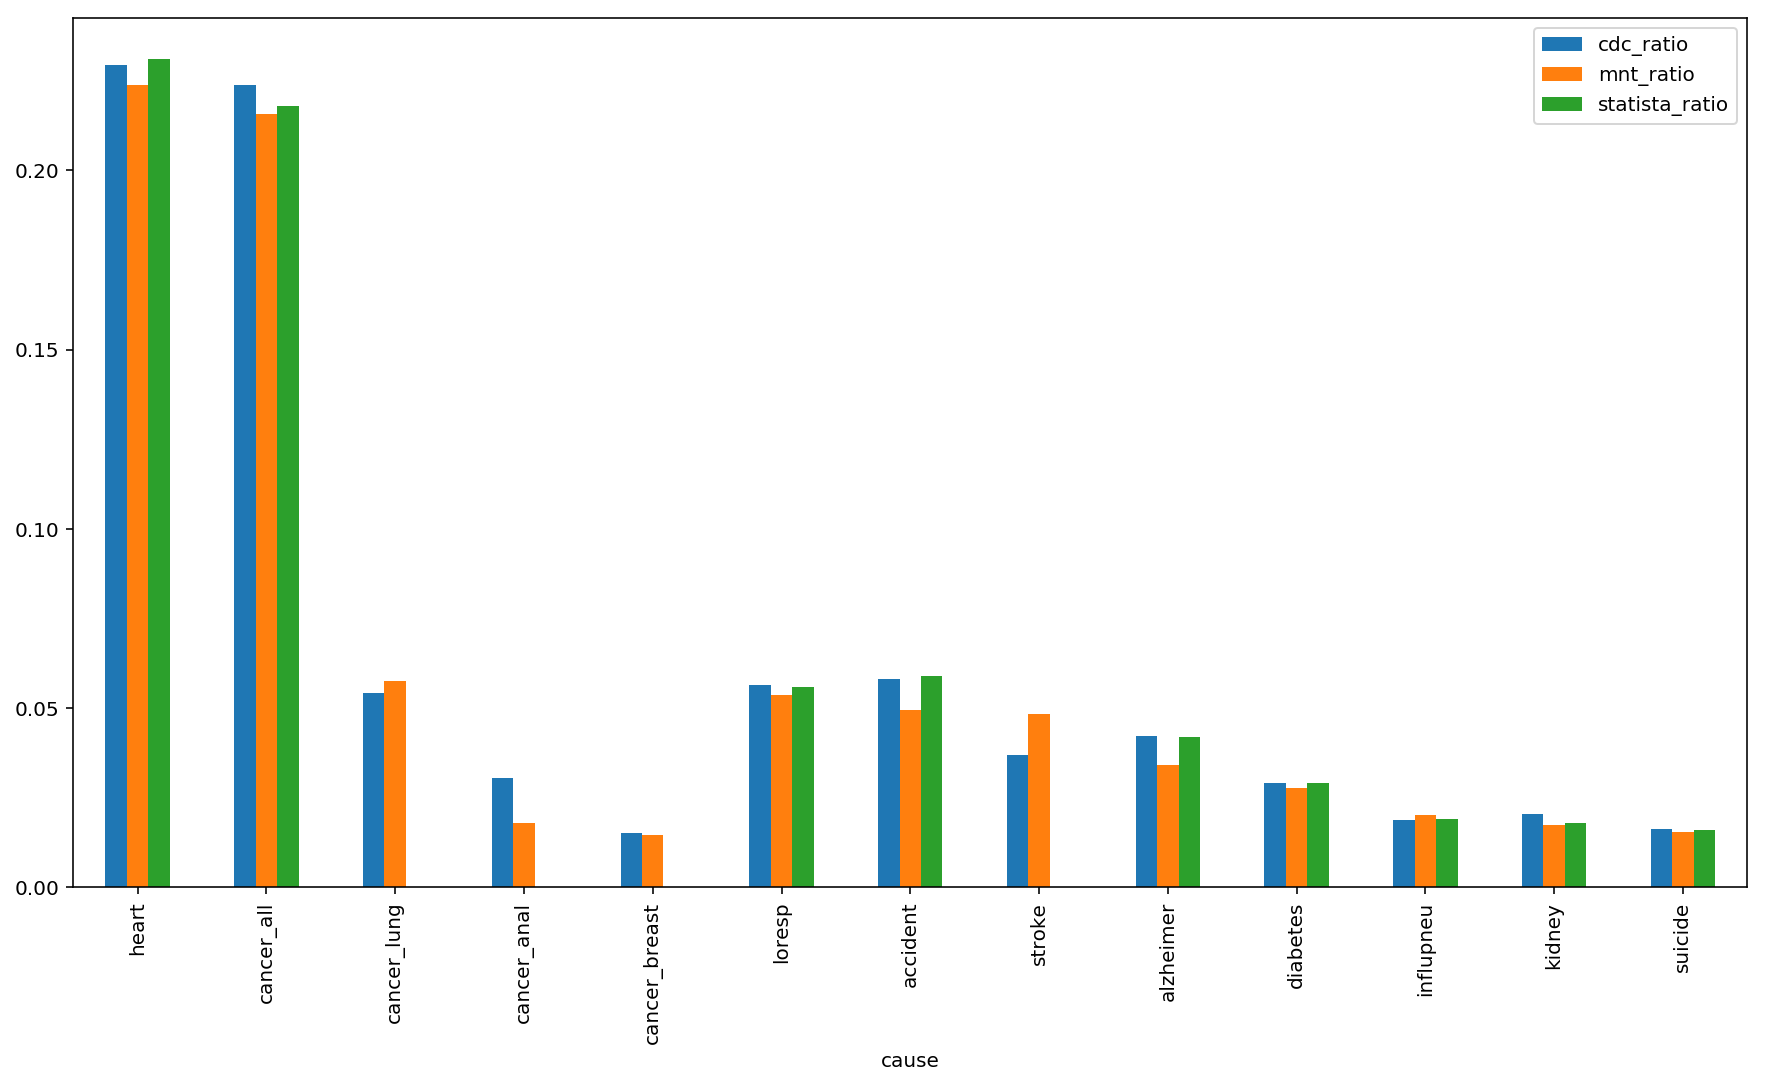

In [9]:
# Our data
cdc_data_2016 = get_mortality_by_category(cat_codename_icd_dict, years=2016)

compare_top_causes_2016(cdc_data_2016)

That looks overall very decent. The small fluctuations in the numbers by information source are within a reasonable range. We can go on!

### Putting together CDC and Media data

First, we will map the row names in the CDC df to the corresponding row names in the scraped media data

In [10]:
cdc_to_news = {'heart':       'Heart Disease',
               'cancer_all':  'Cancer',
               'loresp':      'Lower Respiratory Disease',
               'accident':    'Car Accidents',
               'stroke':      'Stroke',
               'alzheimer':   'Alzheimer\'s Disease',
               'diabetes':    'Diabetes',
               'influpneu':   'Pneumonia & Influenza',
               'kidney':      'Kidney',
               'suicide':     'Suicide',
               'homicide_all':'Homicide',
               'overdose':    'Overdose',
               'terrorism':   'Terrorism'}

cdc_years_raw_renamed  = copy.deepcopy(cdc_years_raw)
cdc_years_norm_renamed = copy.deepcopy(cdc_years_norm)

cdc_years_raw_renamed.index  = pd.Series(list(cdc_years_raw_renamed.index)).map(cdc_to_news).tolist()
cdc_years_norm_renamed.index = pd.Series(list(cdc_years_norm_renamed.index)).map(cdc_to_news).tolist()

cdc_years_raw_renamed['cause']  = cdc_years_raw_renamed.index
cdc_years_norm_renamed['cause'] = cdc_years_norm_renamed.index

### Remove rows where cause of death is NaN (here we have CDC data but no news data)
cdc_years_raw_renamed  = cdc_years_raw_renamed.dropna()
cdc_years_norm_renamed = cdc_years_norm_renamed.dropna()

In [37]:
### Now put together all the normalized data from CDC, Guardian, NYT, and Google, year by year

all_data_by_years_dict = {}
for year in np.arange(1999, 2017): # actually only goes up to 2016:
    Guardian_df_renamed = copy.deepcopy(Guardian_df)
    Guardian_df_renamed.rename(columns={'Unnamed: 0': 'cause'}, inplace=True)

    NYT_df_renamed = copy.deepcopy(NYT_df)
    NYT_df_renamed.rename(columns={'Cause of Death': 'cause'}, inplace=True)

    Google_df_renamed = copy.deepcopy(Google_df)
    Google_df_renamed.rename(columns={'Unnamed: 0': 'cause'}, inplace=True)
    google_to_news = {'heart disease':'heart',
                    'cancer':               'cancer_all',
                    'respiratory disease':               'loresp',
                    'car accidents':               'accident',
                    'stroke':               'stroke',
                    'alzheimer\'s':               'alzheimer',
                    'diabetes':               'diabetes',
                    'pneumonia':               'influpneu',
                    'kidney disease':               'kidney',
                    'suicide':               'suicide',
                    'homicide':               'homicide_all',
                    'overdose':               'overdose',
                    'terrorism':               'terrorism'}
    Google_df_renamed.cause = (Google_df_renamed.cause.map(google_to_news).map(cdc_to_news))
    
    dfs = [pd.DataFrame(cdc_years_norm_renamed.loc[:, ['cause', str(year)]]),
           pd.DataFrame(Guardian_df_renamed.loc[:, ['cause', str(year)]]),
           pd.DataFrame(NYT_df_renamed.loc[:, ['cause', str(year)]]),
           pd.DataFrame(Google_df_renamed.loc[:, ['cause', str(year)]])]
    
    dfs_merged = reduce(lambda left, right: pd.merge(left, right, on='cause'), dfs)
    
    dfs_merged.columns = ['Cause of Death', 'CDC', 'Guardian', 'NYT', 'Google']
    
    all_data_by_years_dict[year] = dfs_merged

In [38]:
### Let's also have a df that includes all data from all data sources summed over all years
Guardian_df_renamed2 = copy.deepcopy(Guardian_df_renamed)
NYT_df_renamed2      = copy.deepcopy(NYT_df_renamed)
Google_df_renamed2   = copy.deepcopy(Google_df_renamed)

Guardian_df_renamed2.index = Guardian_df_renamed2.cause
NYT_df_renamed2.index = NYT_df_renamed2.cause
Google_df_renamed2.index = Google_df_renamed2.cause

cdc_years_norm_renamed_sums = pd.DataFrame(cdc_years_norm_renamed.sum(axis=1))
Guardian_df_renamed2_sums = pd.DataFrame(Guardian_df_renamed2.sum(axis=1))
NYT_df_renamed2_sums = pd.DataFrame(NYT_df_renamed2.sum(axis=1))
Google_df_renamed2_sums = pd.DataFrame(Google_df_renamed2.sum(axis=1))

sums_dfs = [cdc_years_norm_renamed_sums,
            Guardian_df_renamed2_sums,
            NYT_df_renamed2_sums,
            Google_df_renamed2_sums]

all_years_all_data = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), sums_dfs)
all_years_all_data.columns = ['CDC', 'Guardian', 'NYT', 'Google']

# Results

## Plots: Comparing distributions year by year

Text(0,0.5,'Normalized frequency')

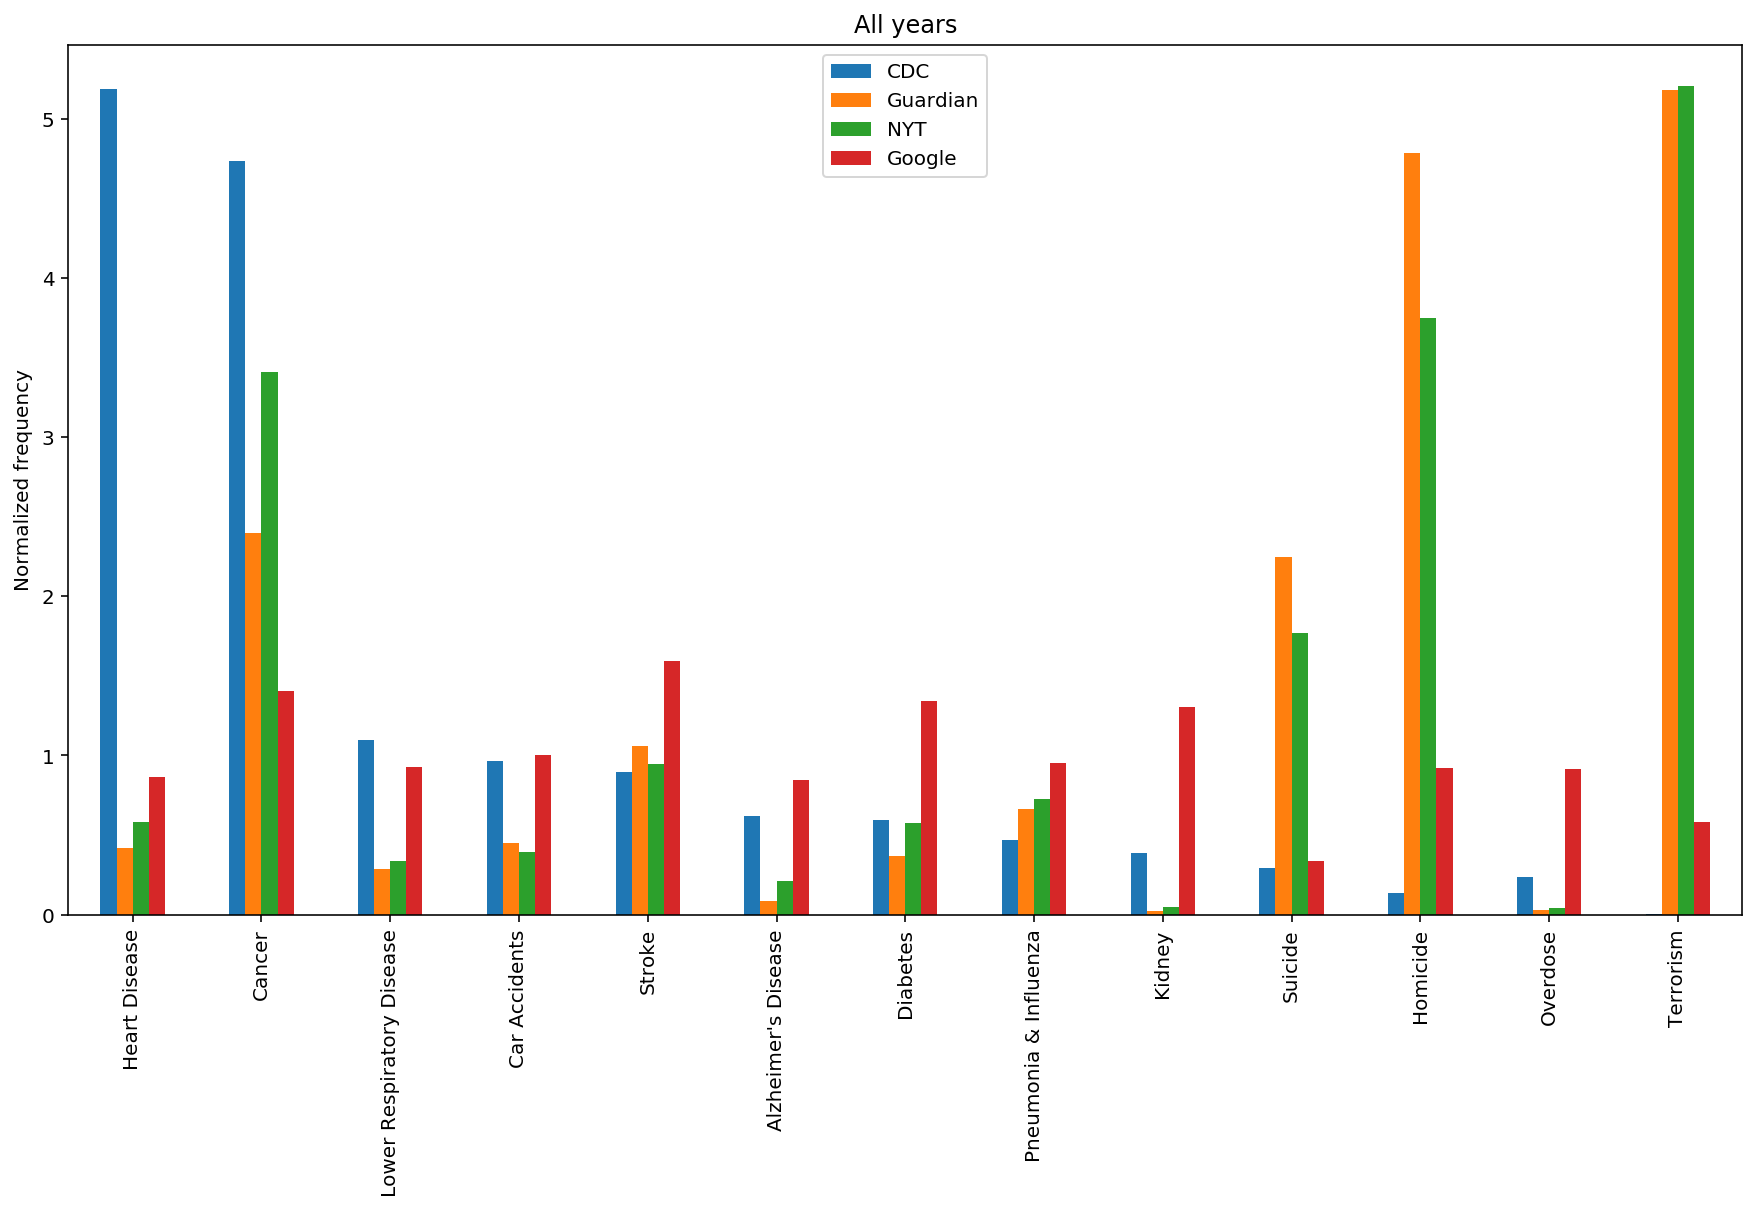

In [39]:
### All years
all_years_all_data.plot(kind = 'bar')
plt.title('All years')
plt.ylabel('Normalized frequency')

In [42]:
all_years_all_data

,CDC,Guardian,NYT,Google
Heart Disease,5.191726,0.416570,0.583003,0.866303
Cancer,4.734958,2.397238,3.408519,1.407393
Lower Respiratory Disease,1.096438,0.287302,0.335598,0.925492
Car Accidents,0.965807,0.450617,0.394742,1.005261
Stroke,0.897419,1.060049,0.948786,1.591776
Alzheimer's Disease,0.616875,0.084042,0.211684,0.843298
Diabetes,0.593087,0.368032,0.573005,1.344091
Pneumonia & Influenza,0.468638,0.664576,0.728518,0.951265
Kidney,0.387852,0.022375,0.049494,1.307066
Suicide,0.291868,2.247904,1.767162,0.339025


In [44]:
## Plot
# for year, year_data in all_data_by_years_dict.items():
#     all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
#     plt.title(year)

Text(0.5,1,'1999')

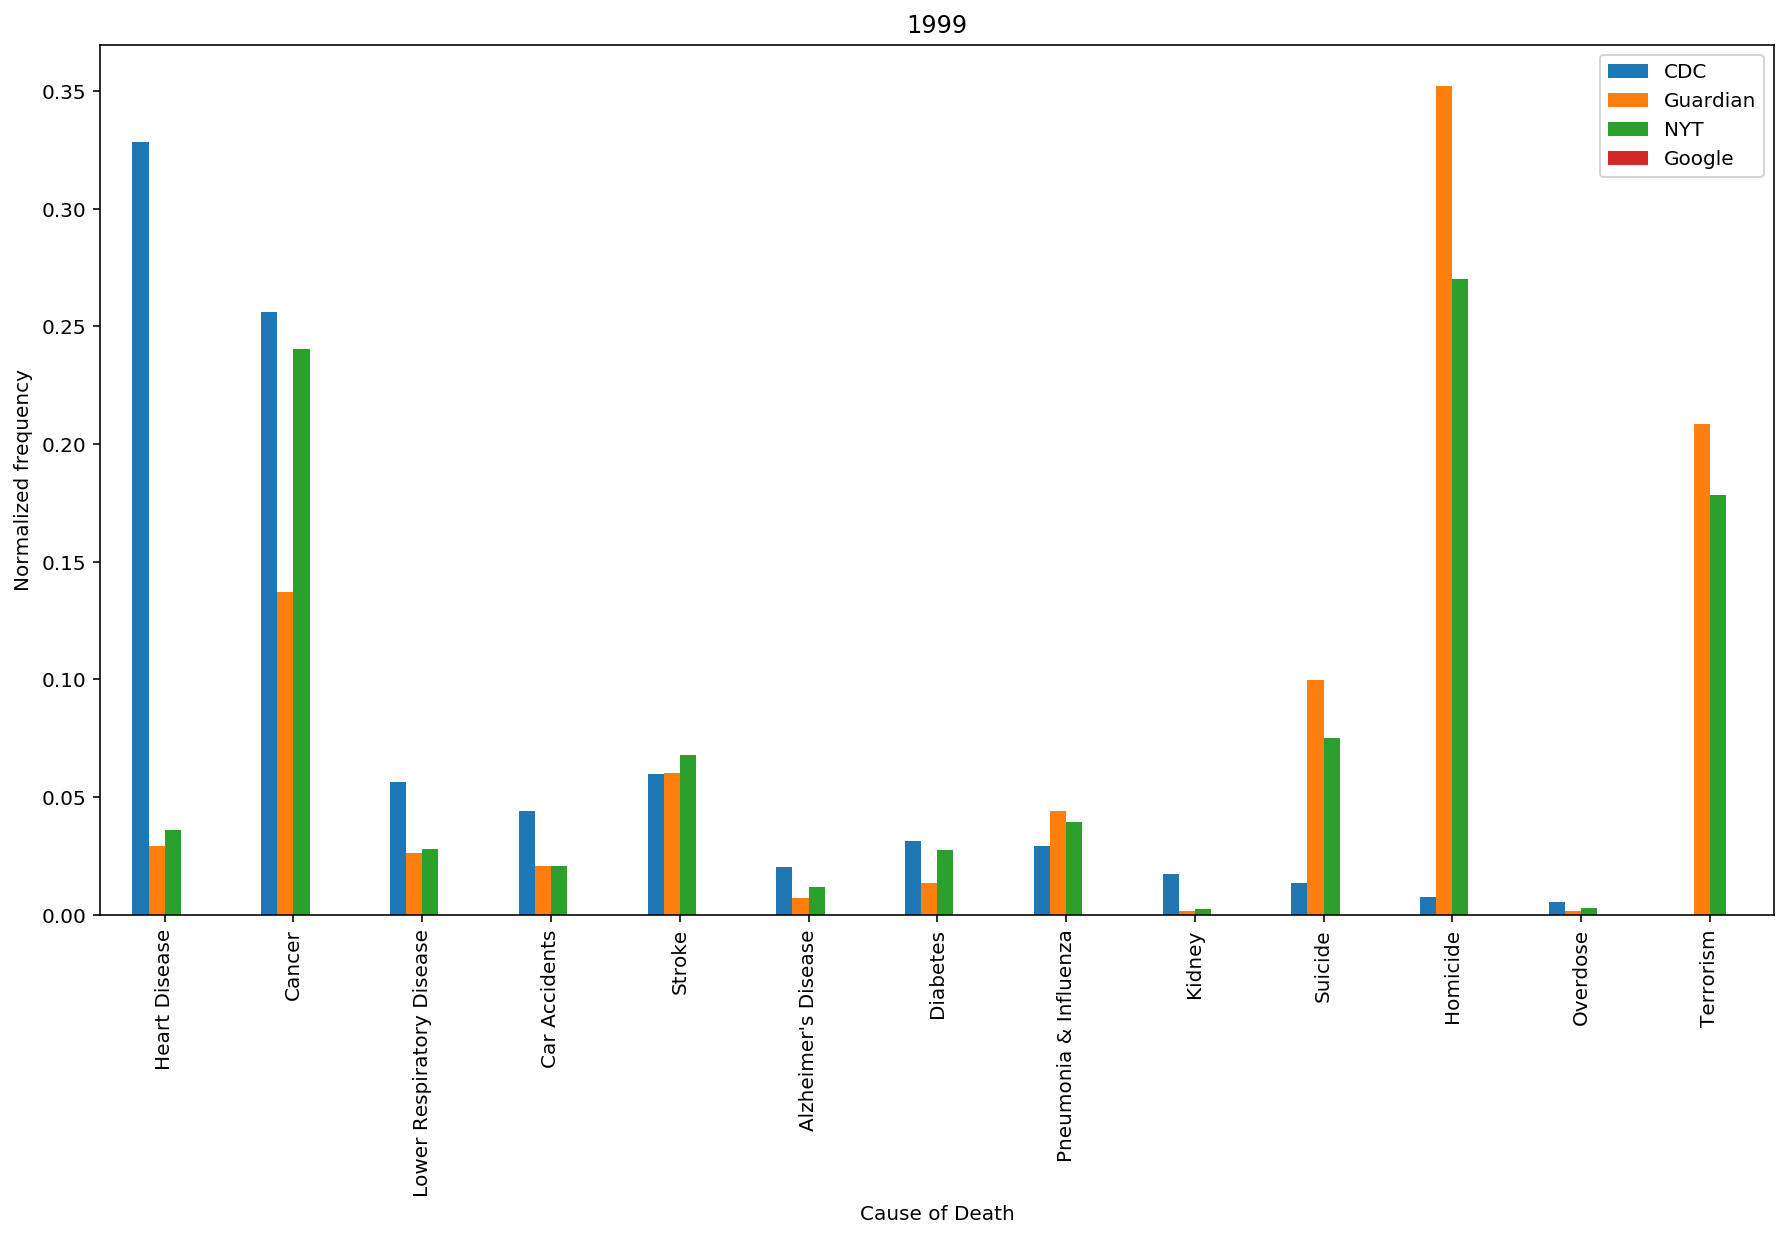

In [45]:
year = 1999
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

Text(0.5,1,'2000')

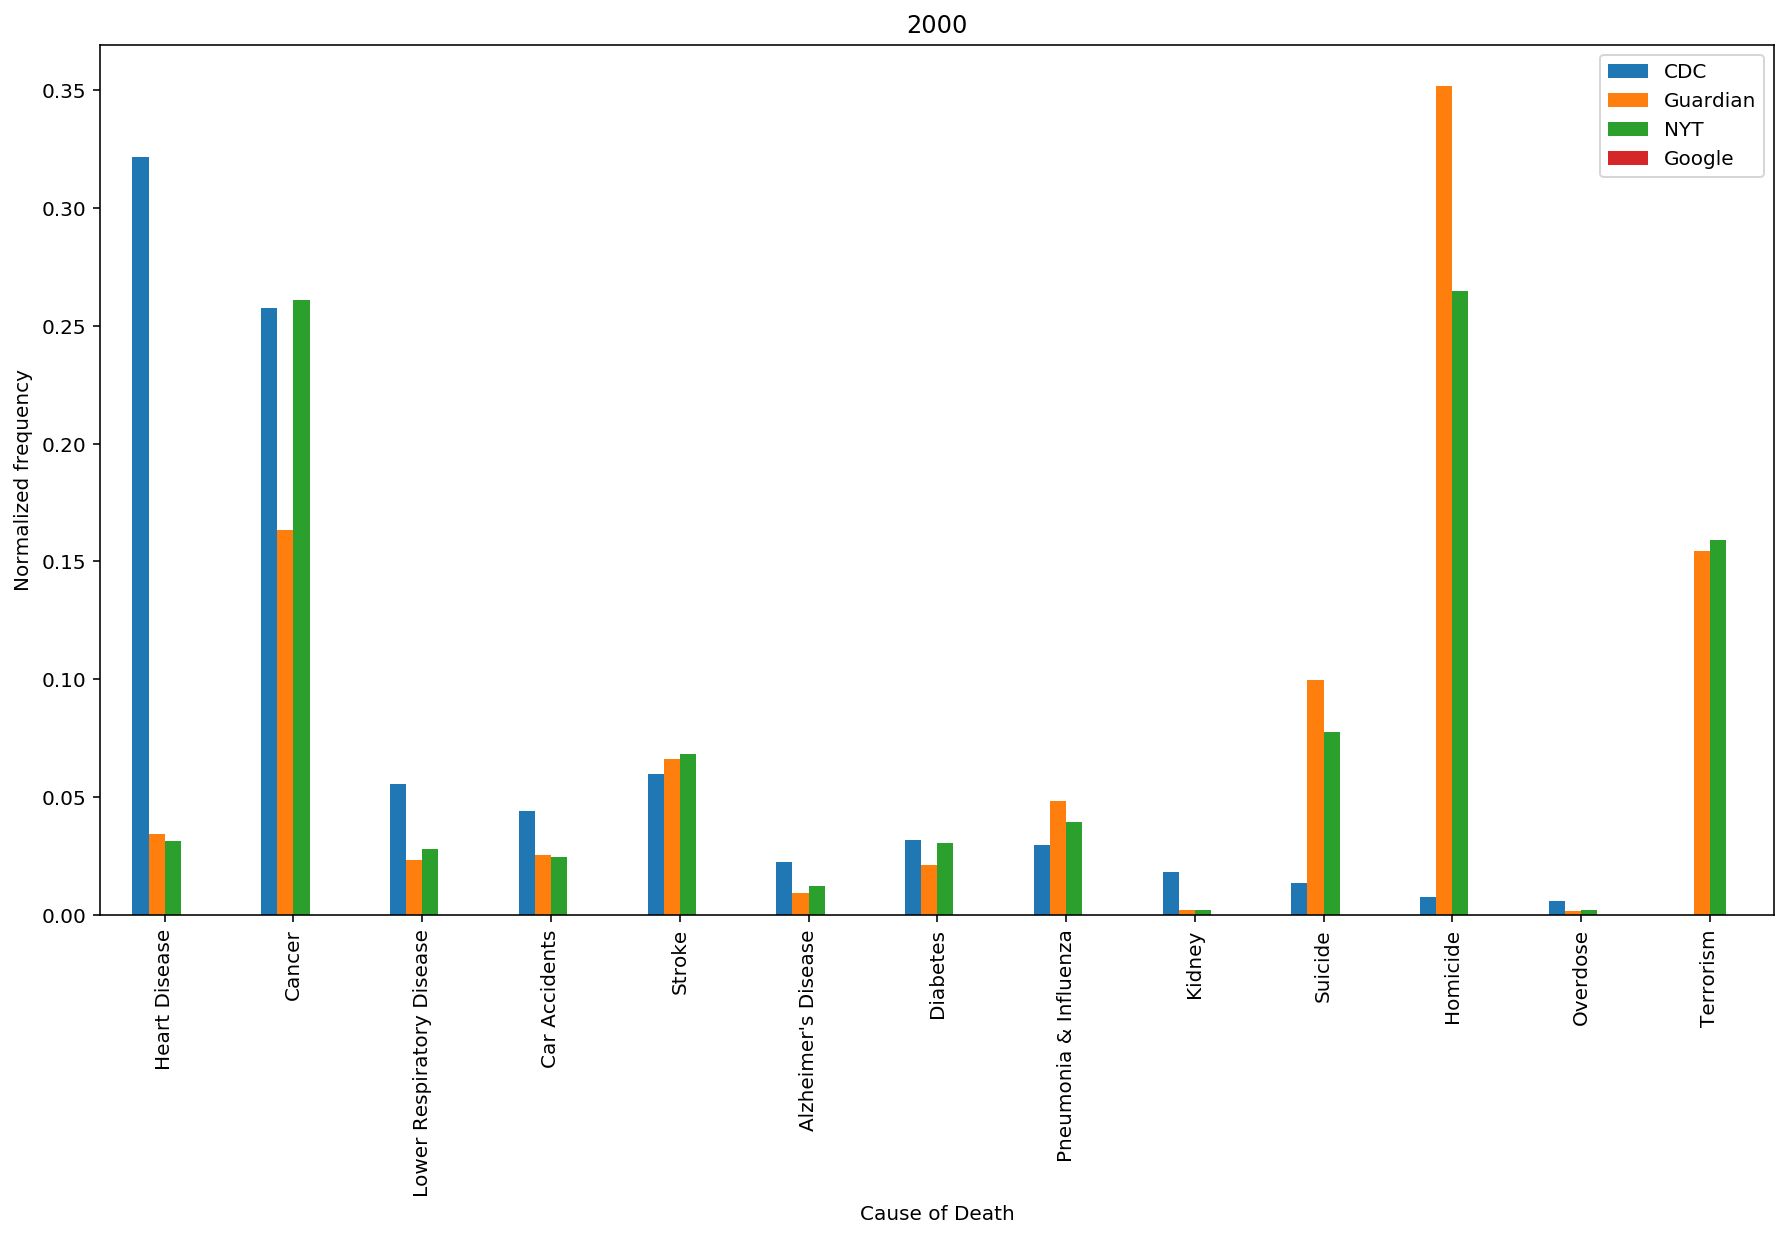

In [24]:
year = 2000
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

Text(0.5,1,'2001')

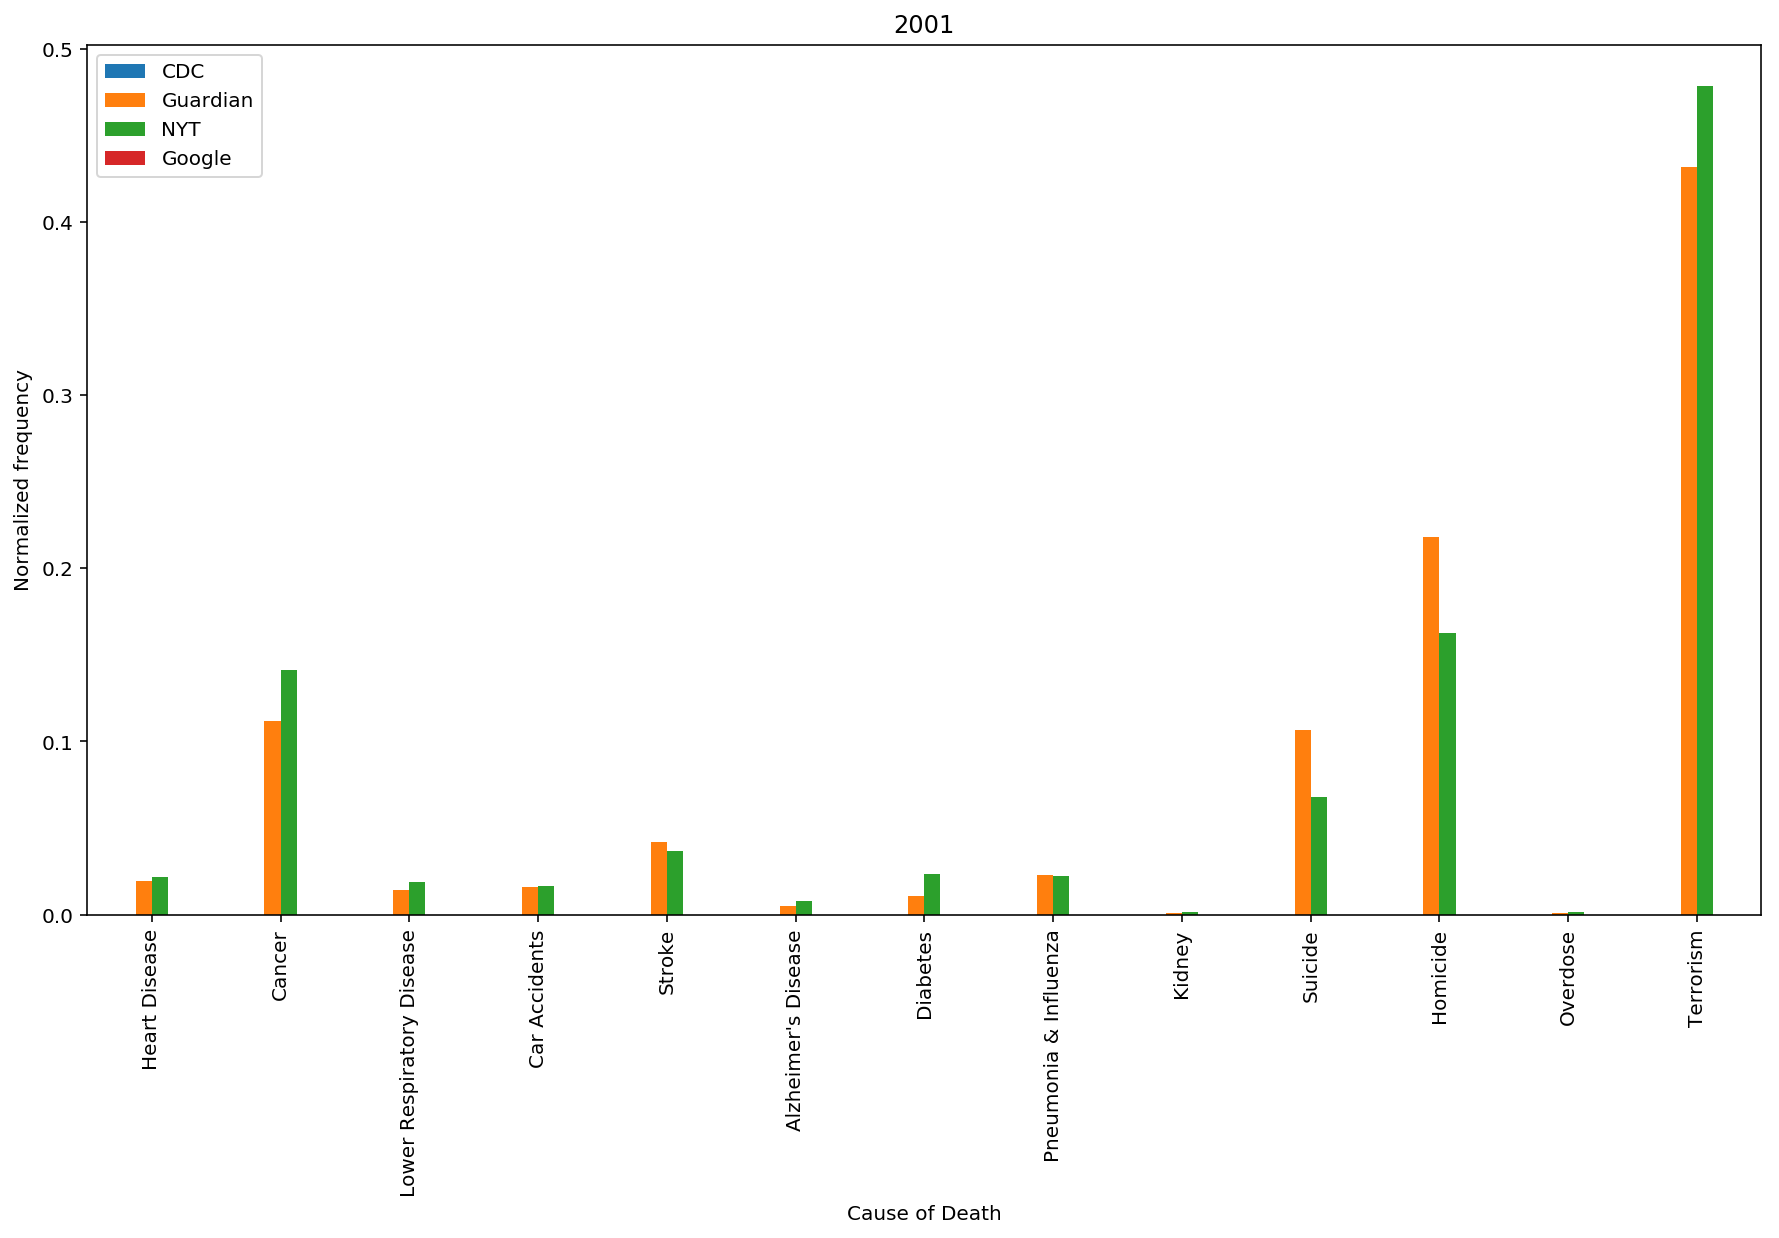

In [16]:
year = 2001
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

Text(0.5,1,'2002')

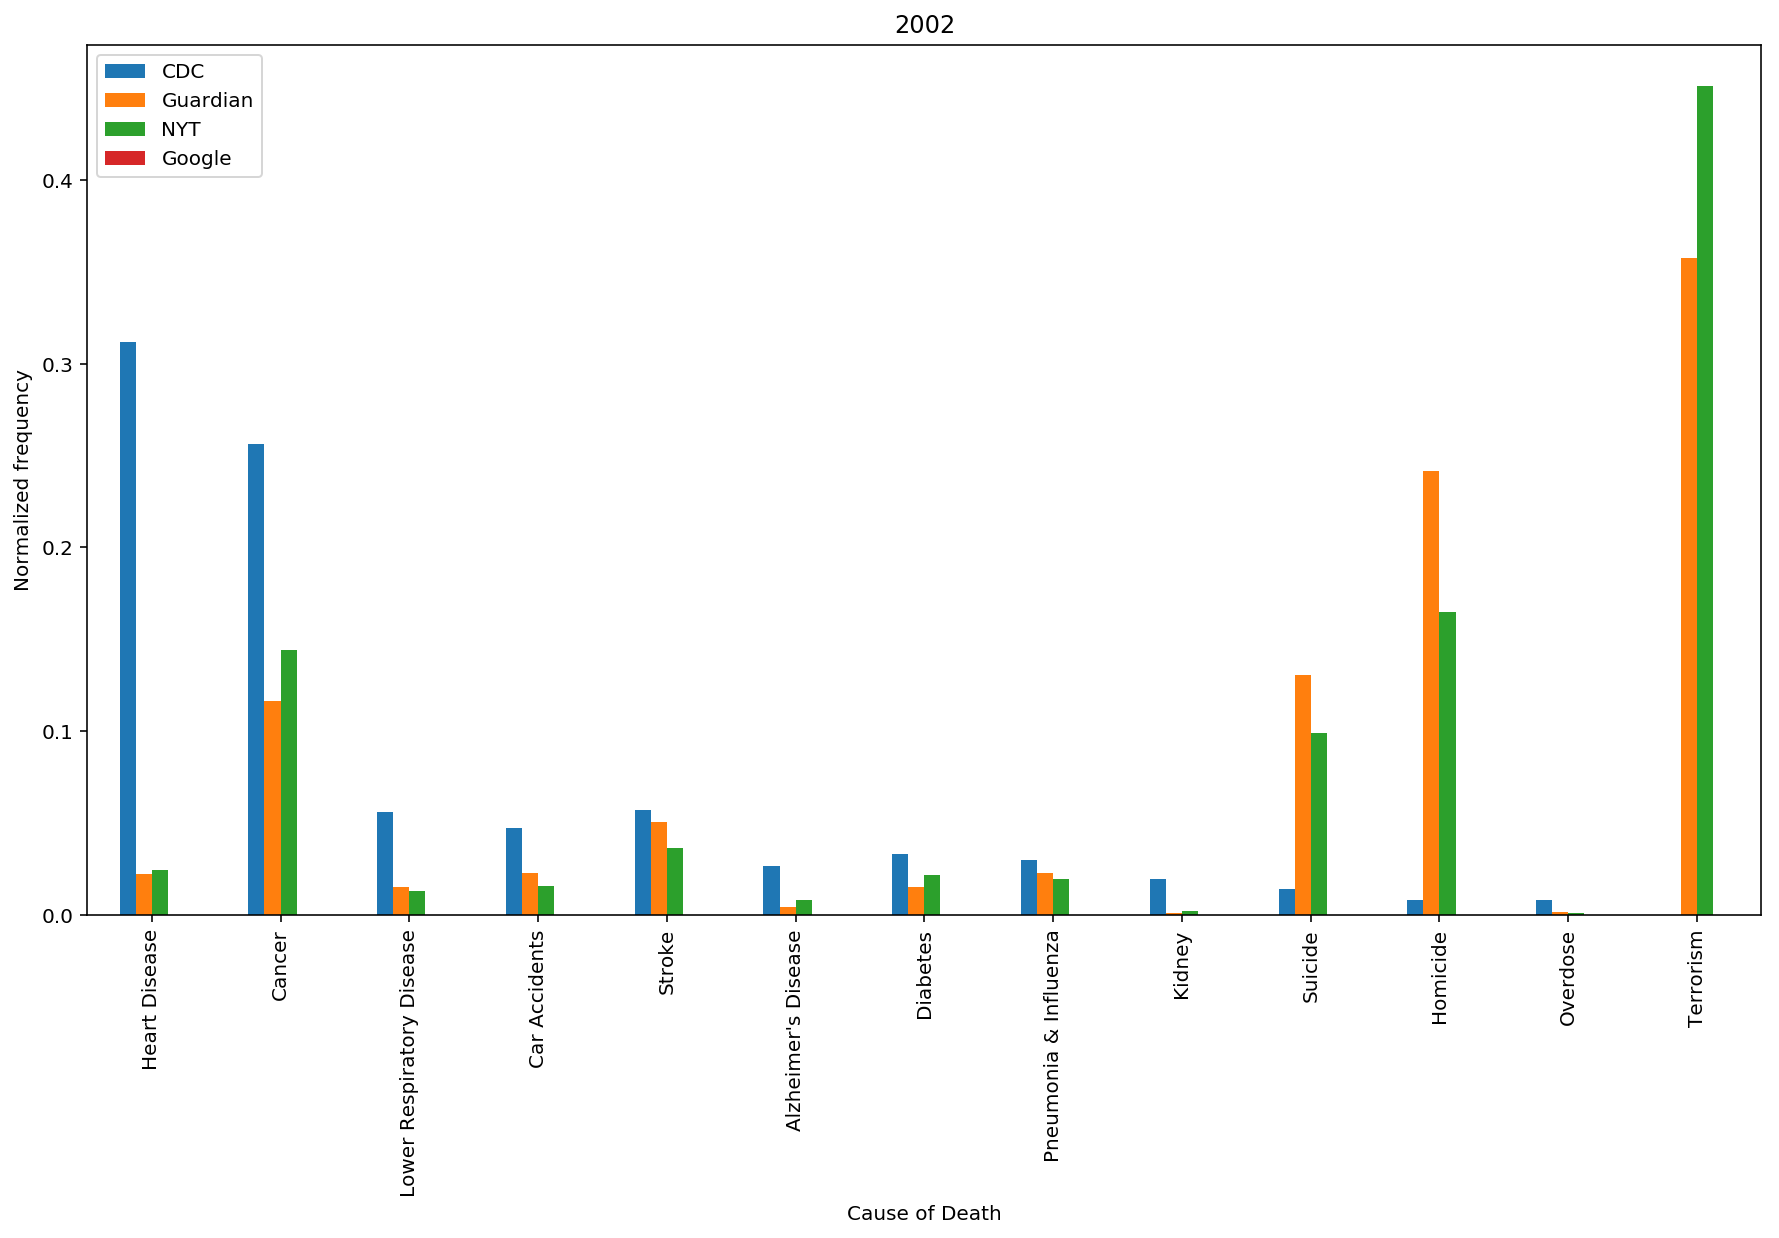

In [26]:
year = 2002
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

Text(0.5,1,'2003')

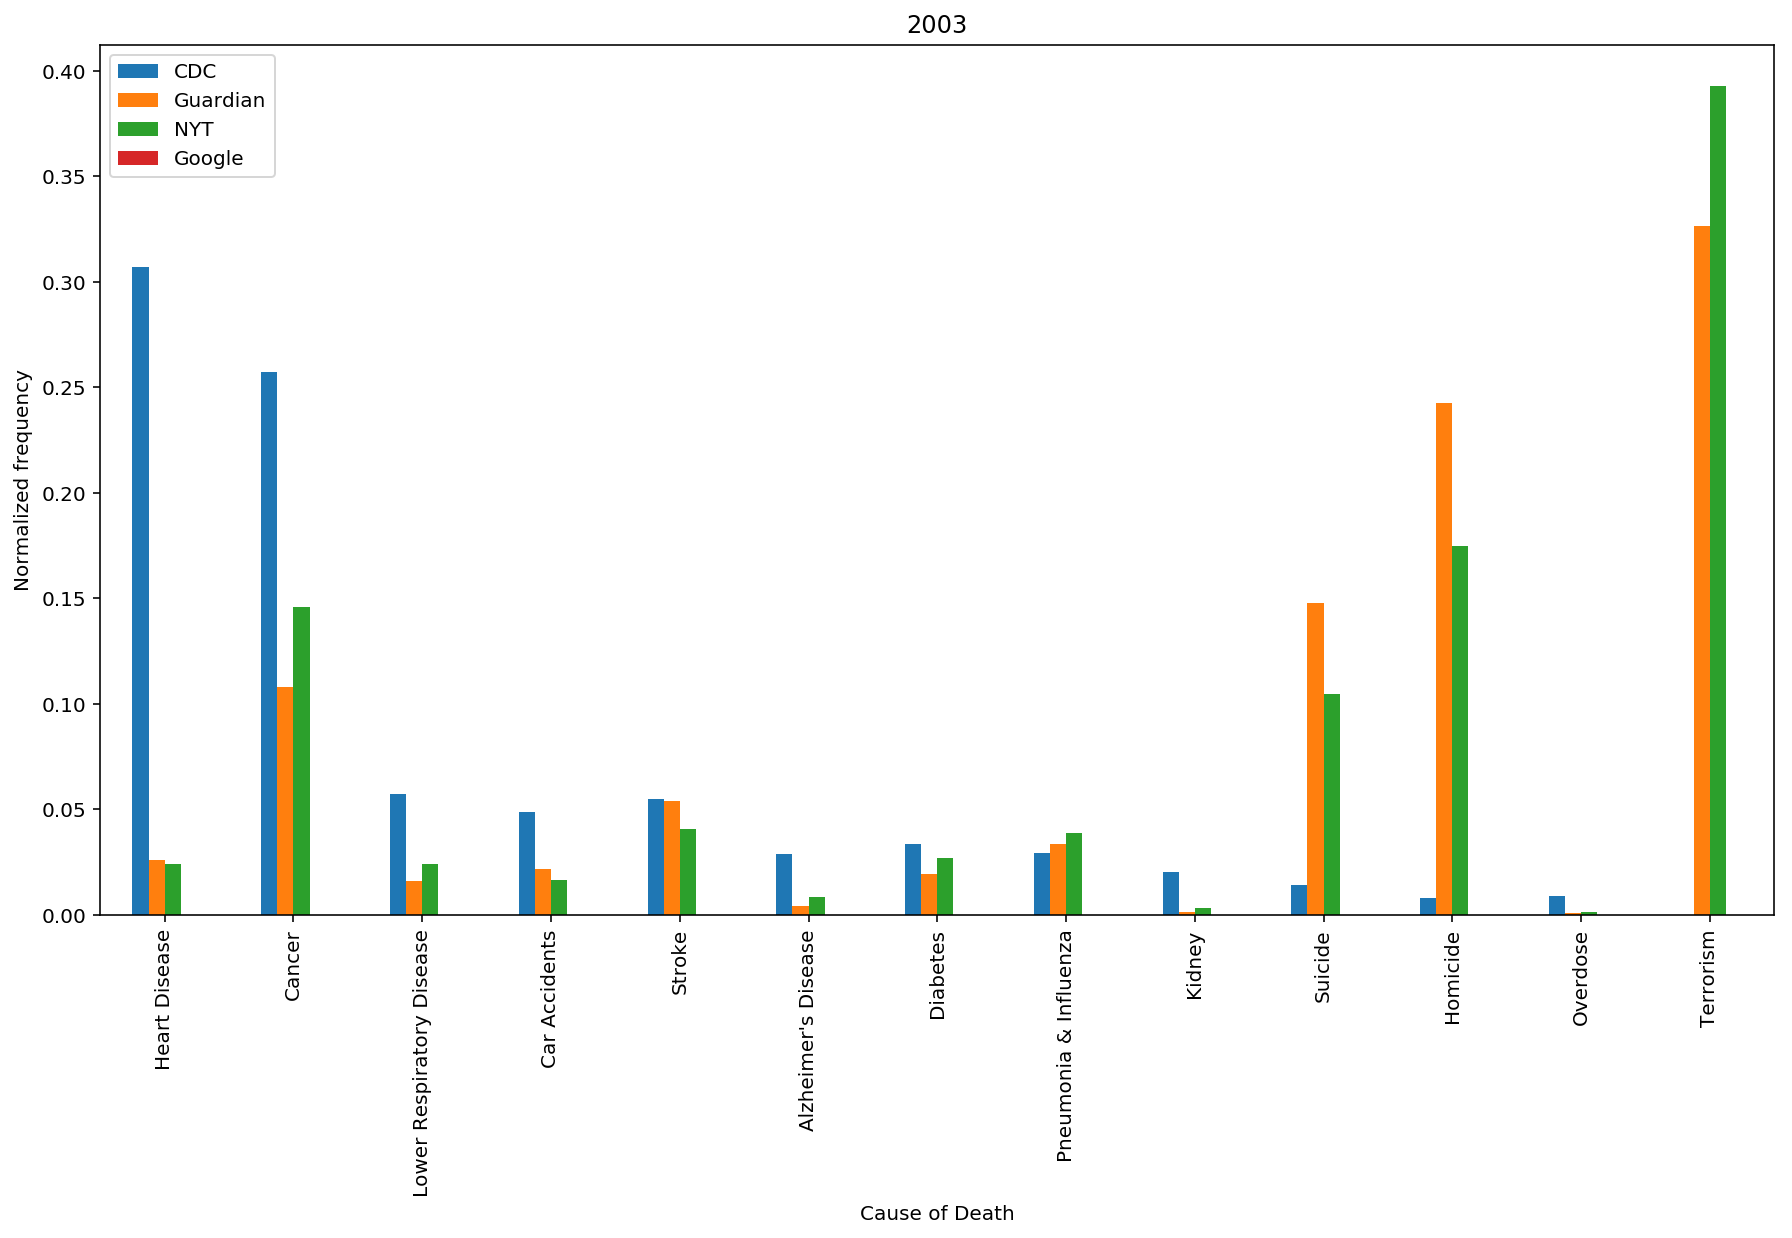

In [27]:
year = 2003
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

Text(0.5,1,'2004')

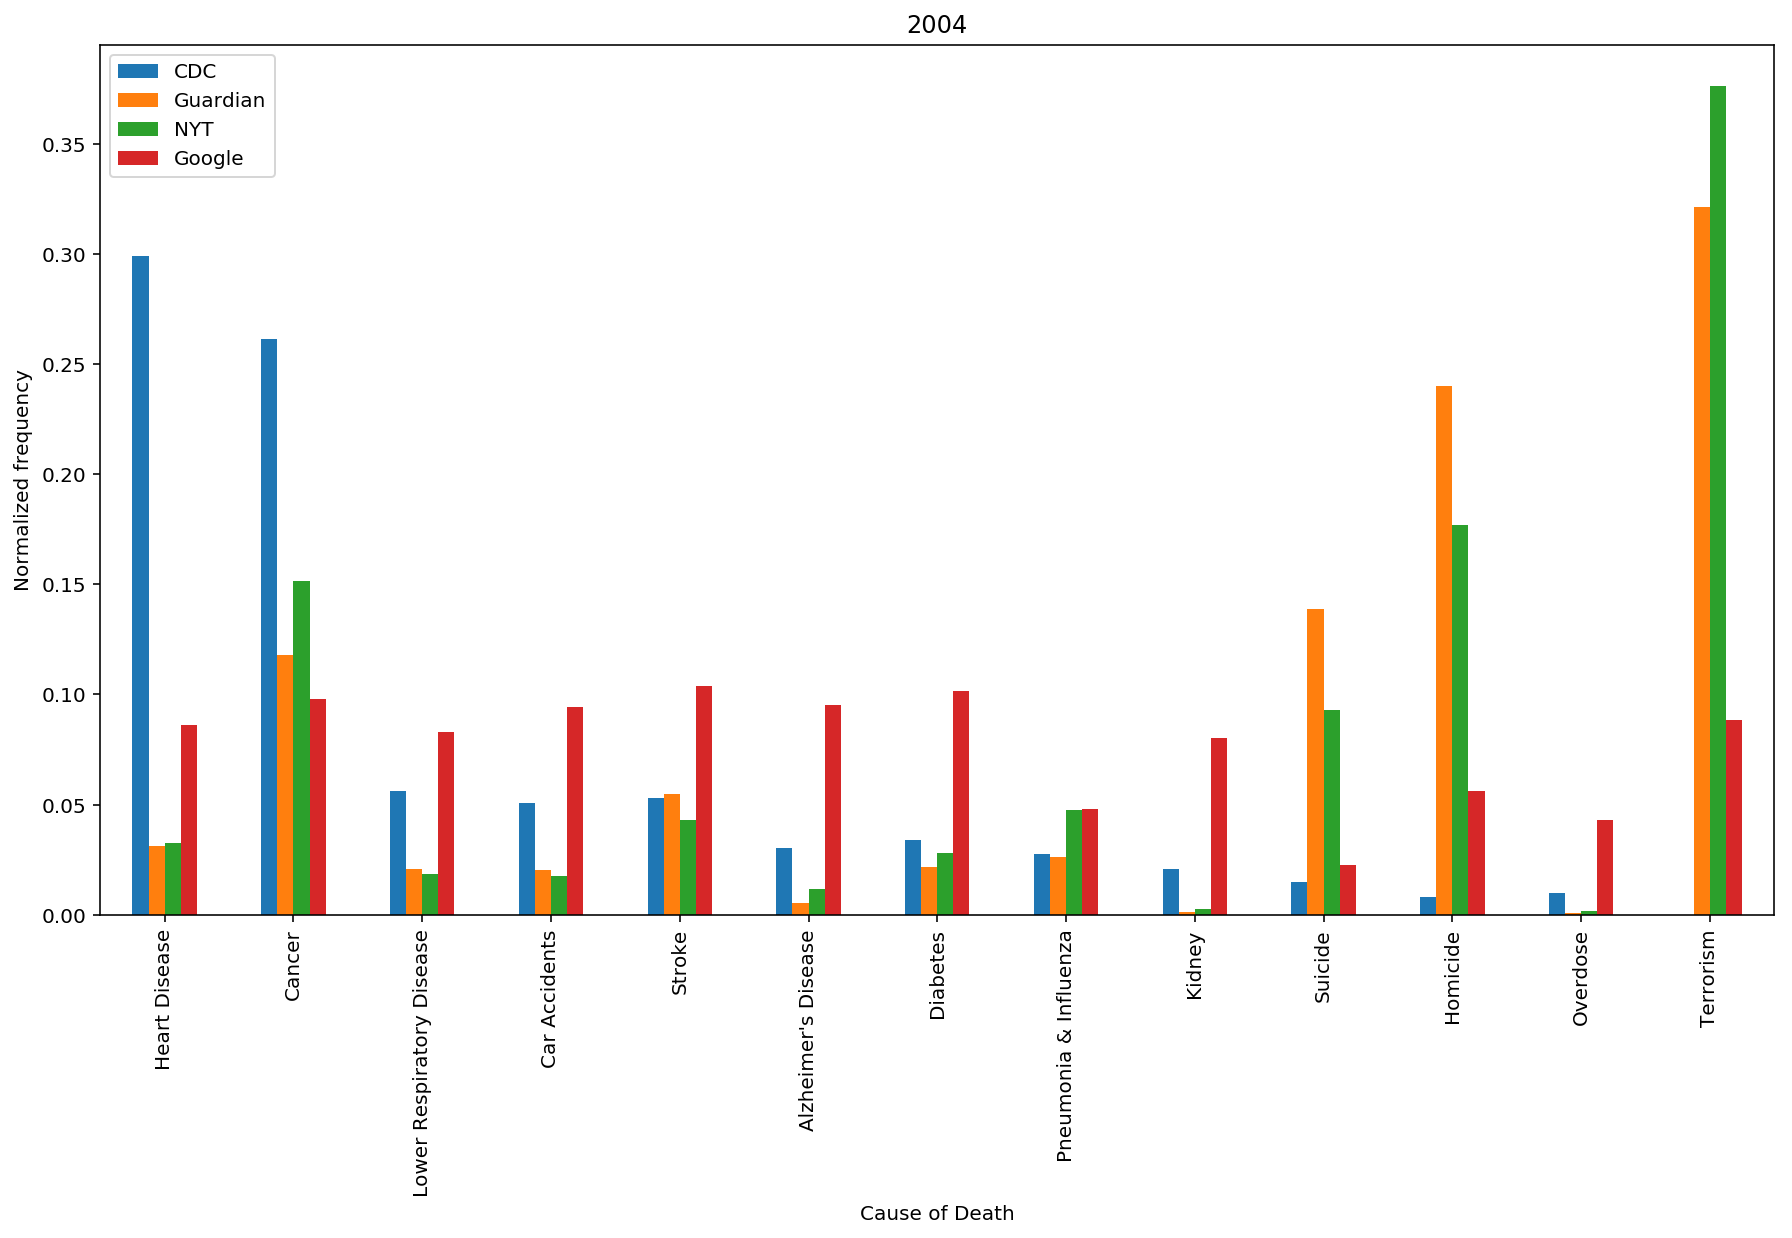

In [28]:
year = 2004
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

Text(0.5,1,'2005')

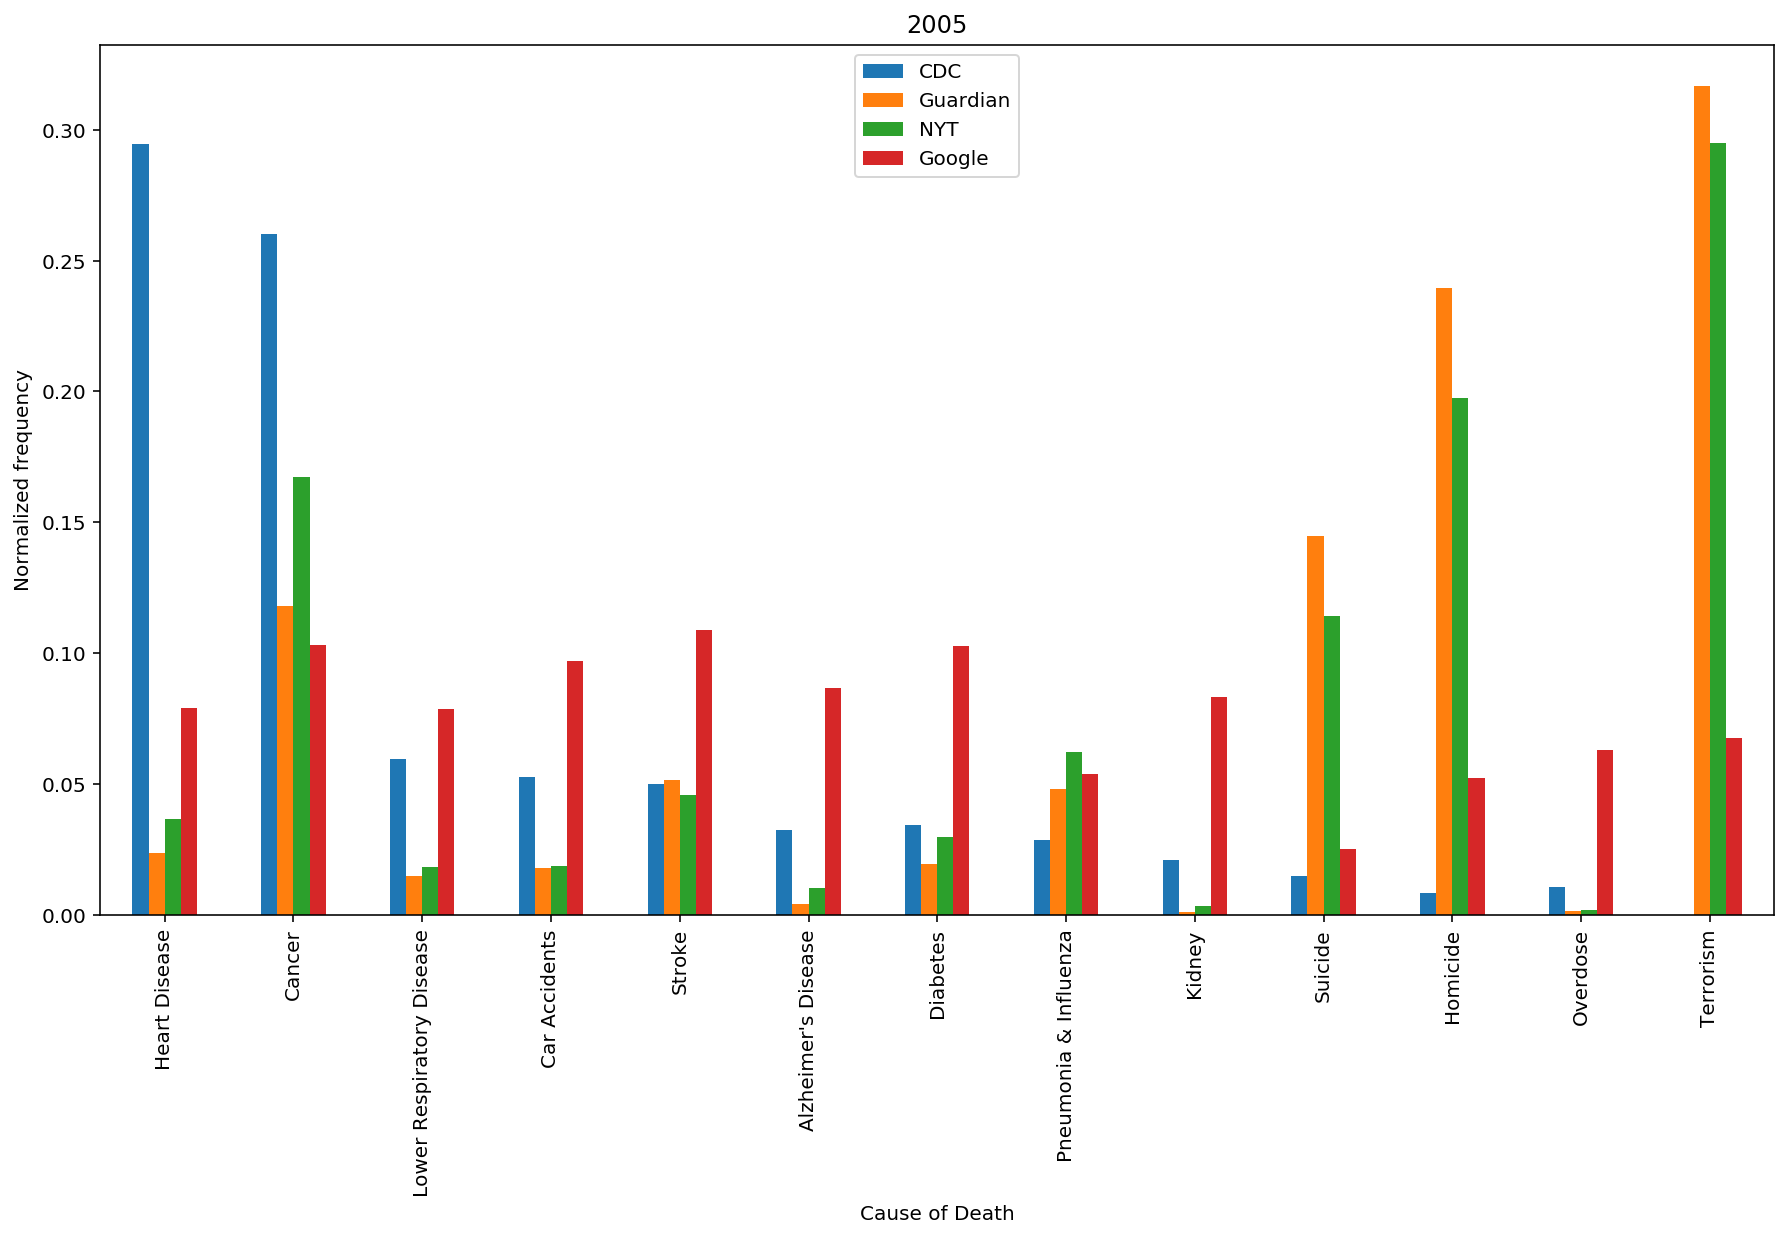

In [29]:
year = 2005
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

Text(0.5,1,'2006')

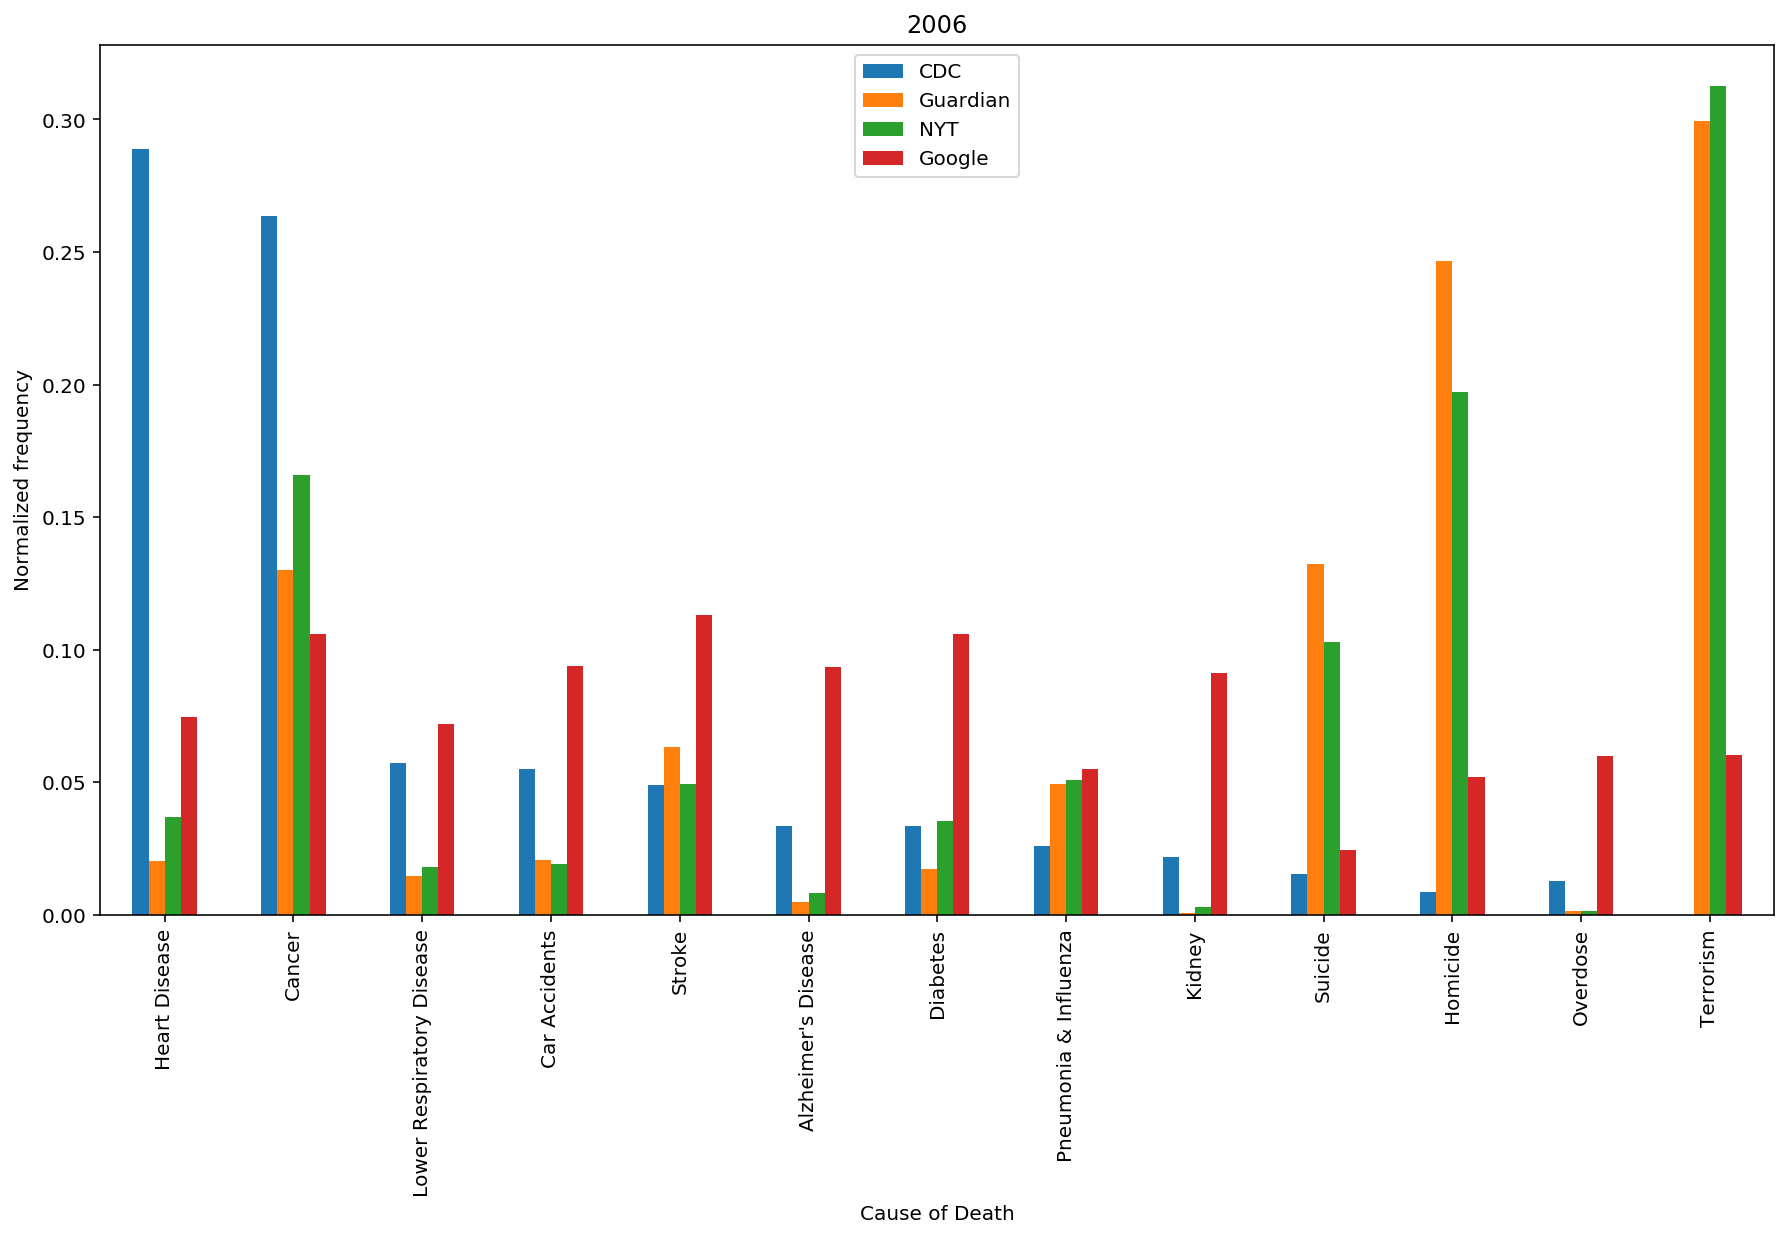

In [30]:
year = 2006
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

Text(0.5,1,'2007')

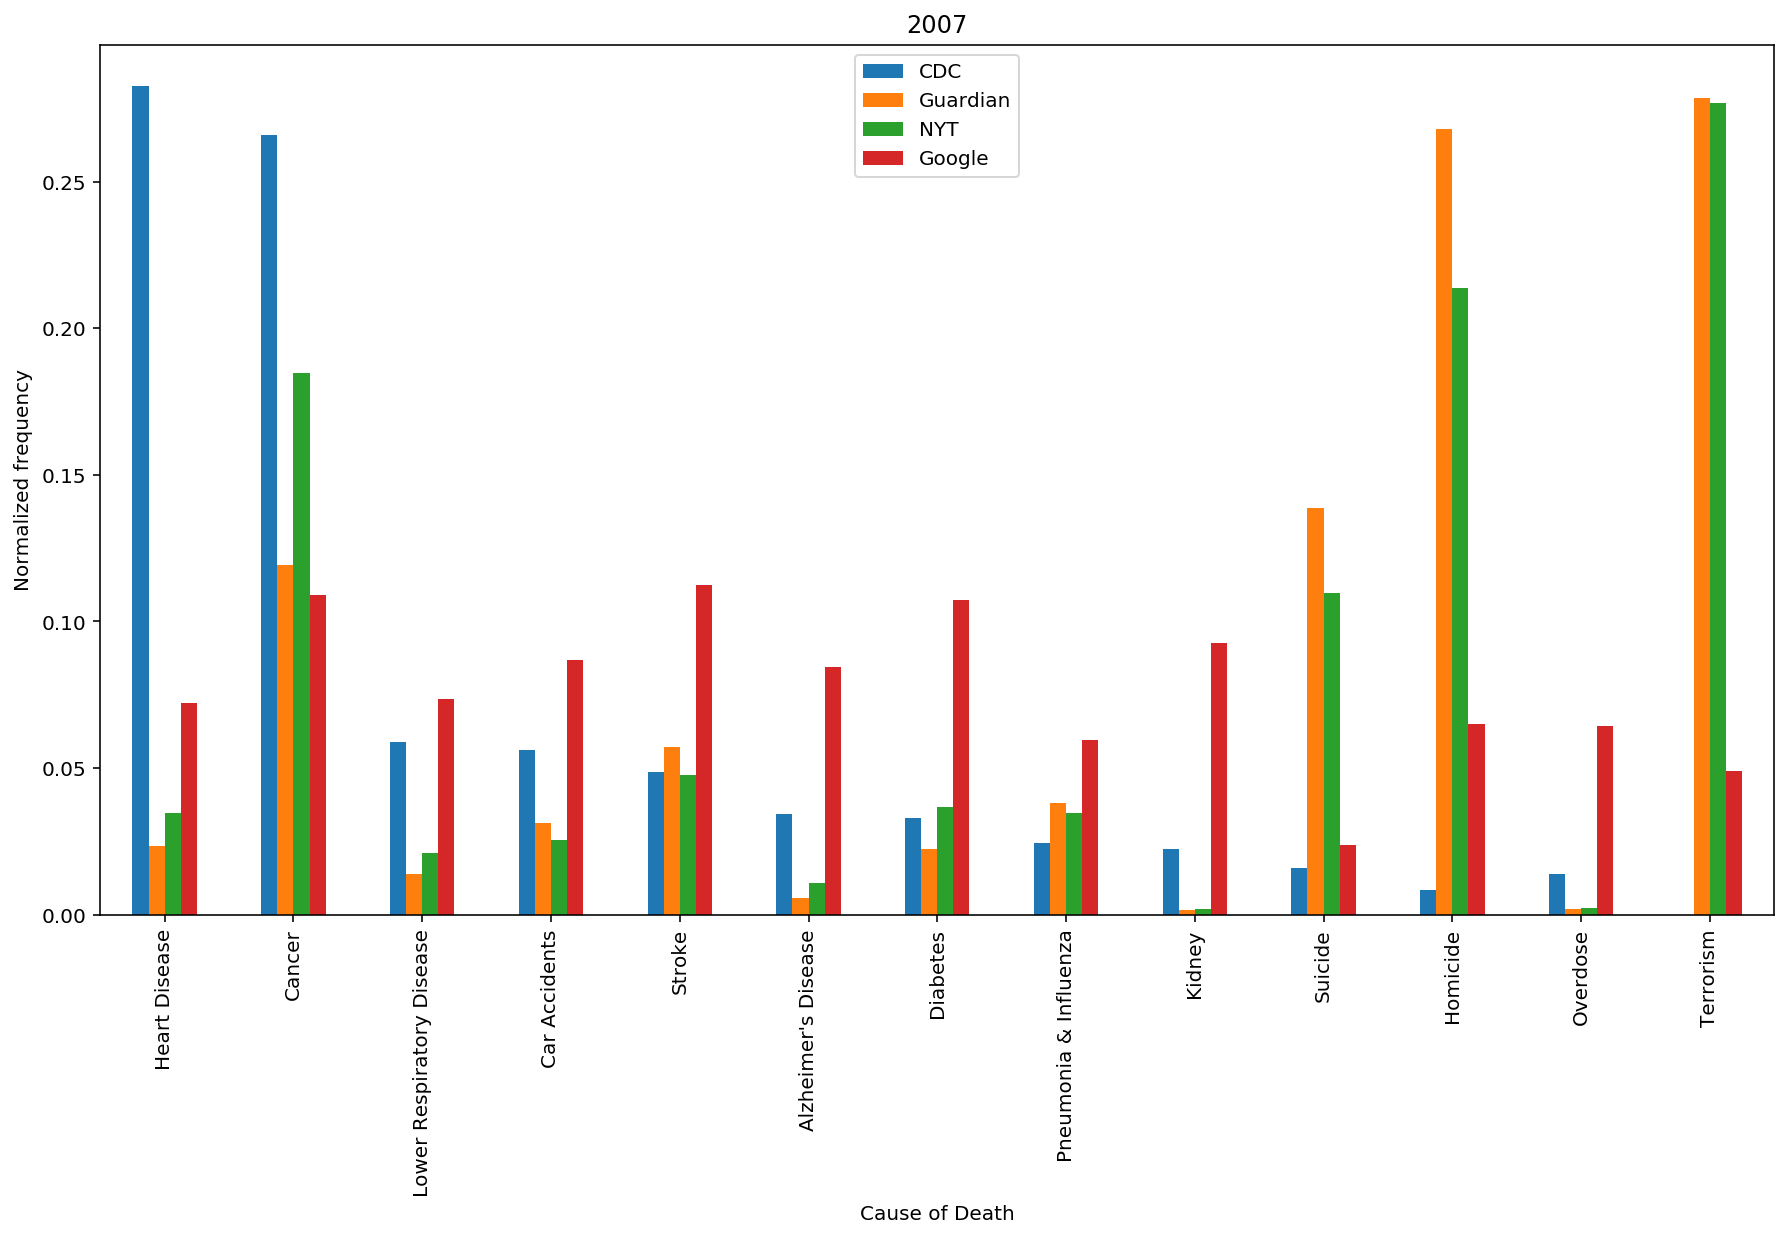

In [31]:
year = 2007
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

Text(0.5,1,'2008')

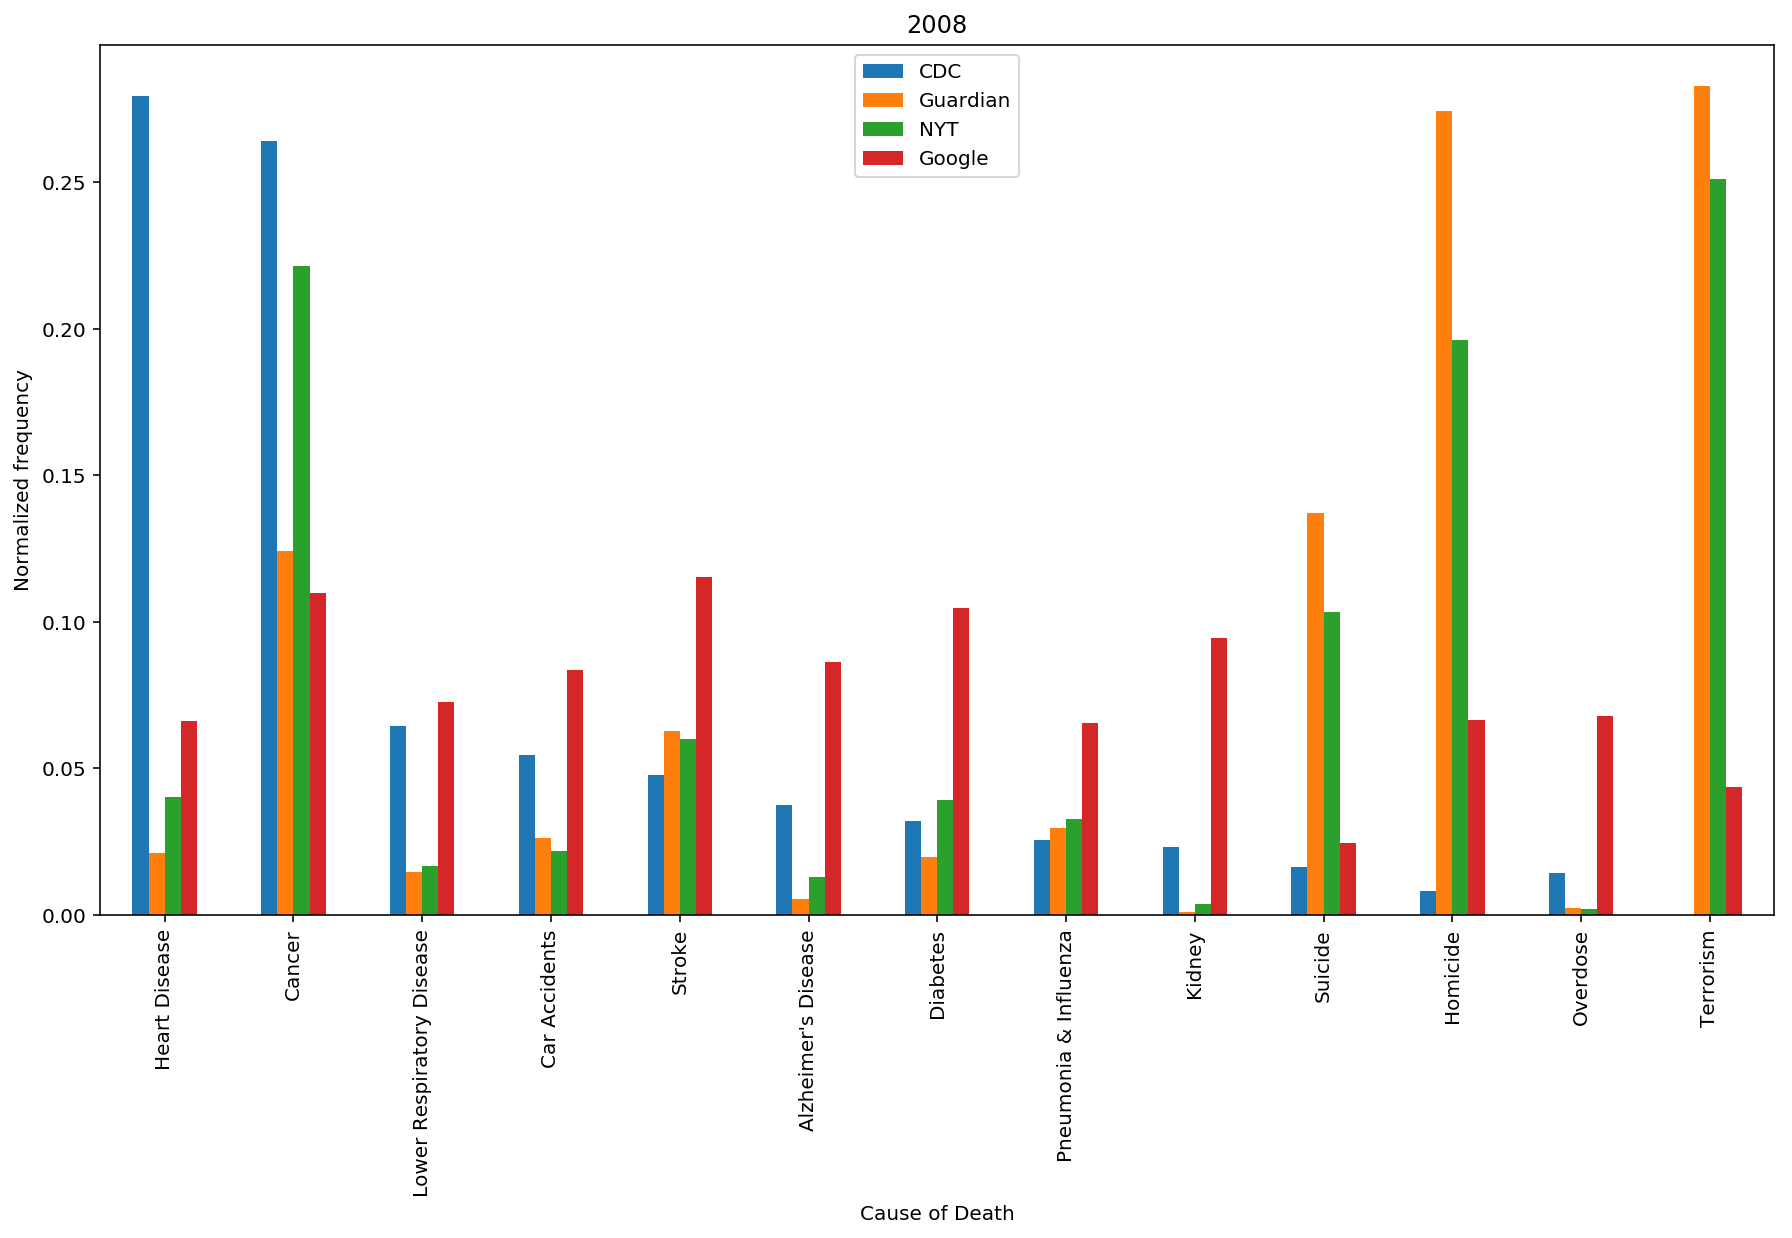

In [32]:
year = 2008
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

Text(0.5,1,'2009')

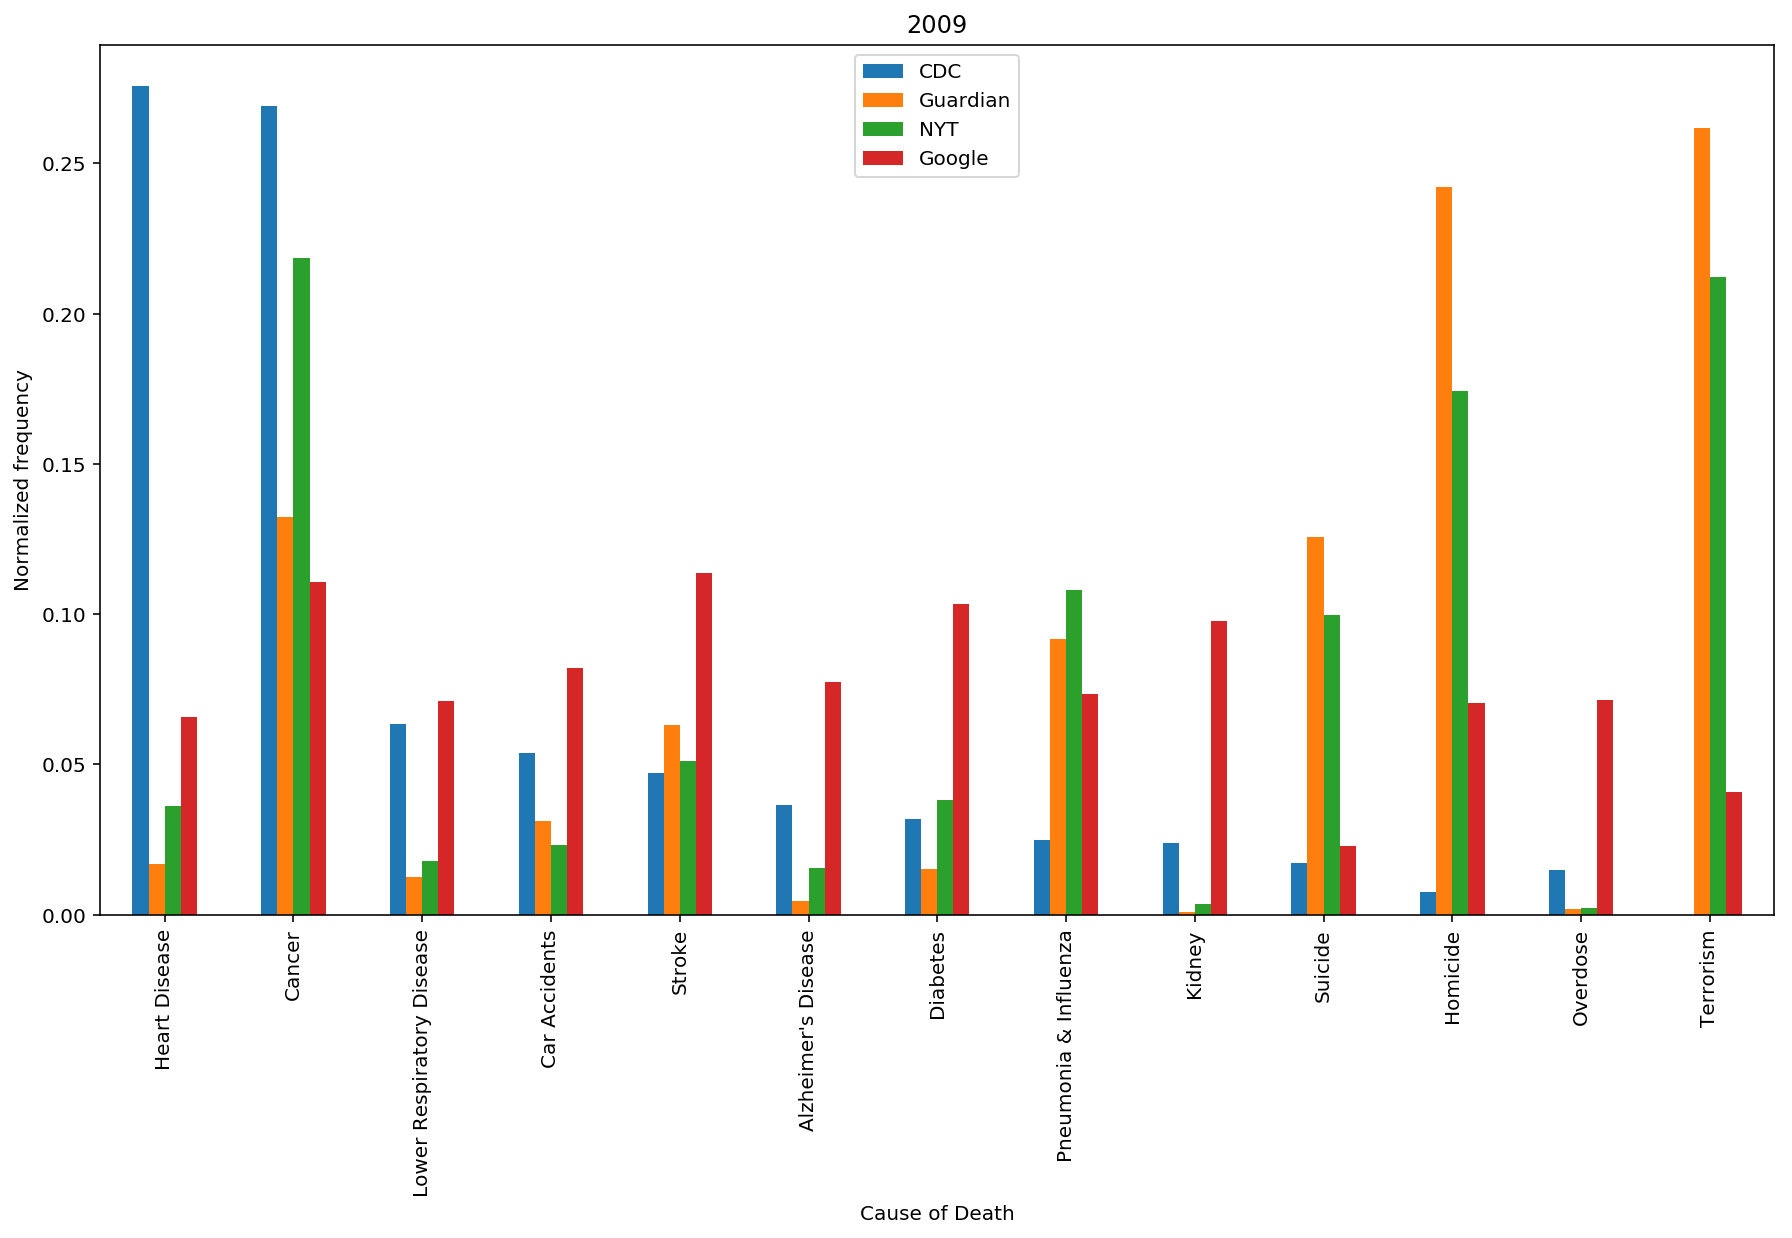

In [33]:
year = 2009
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

Text(0.5,1,'2010')

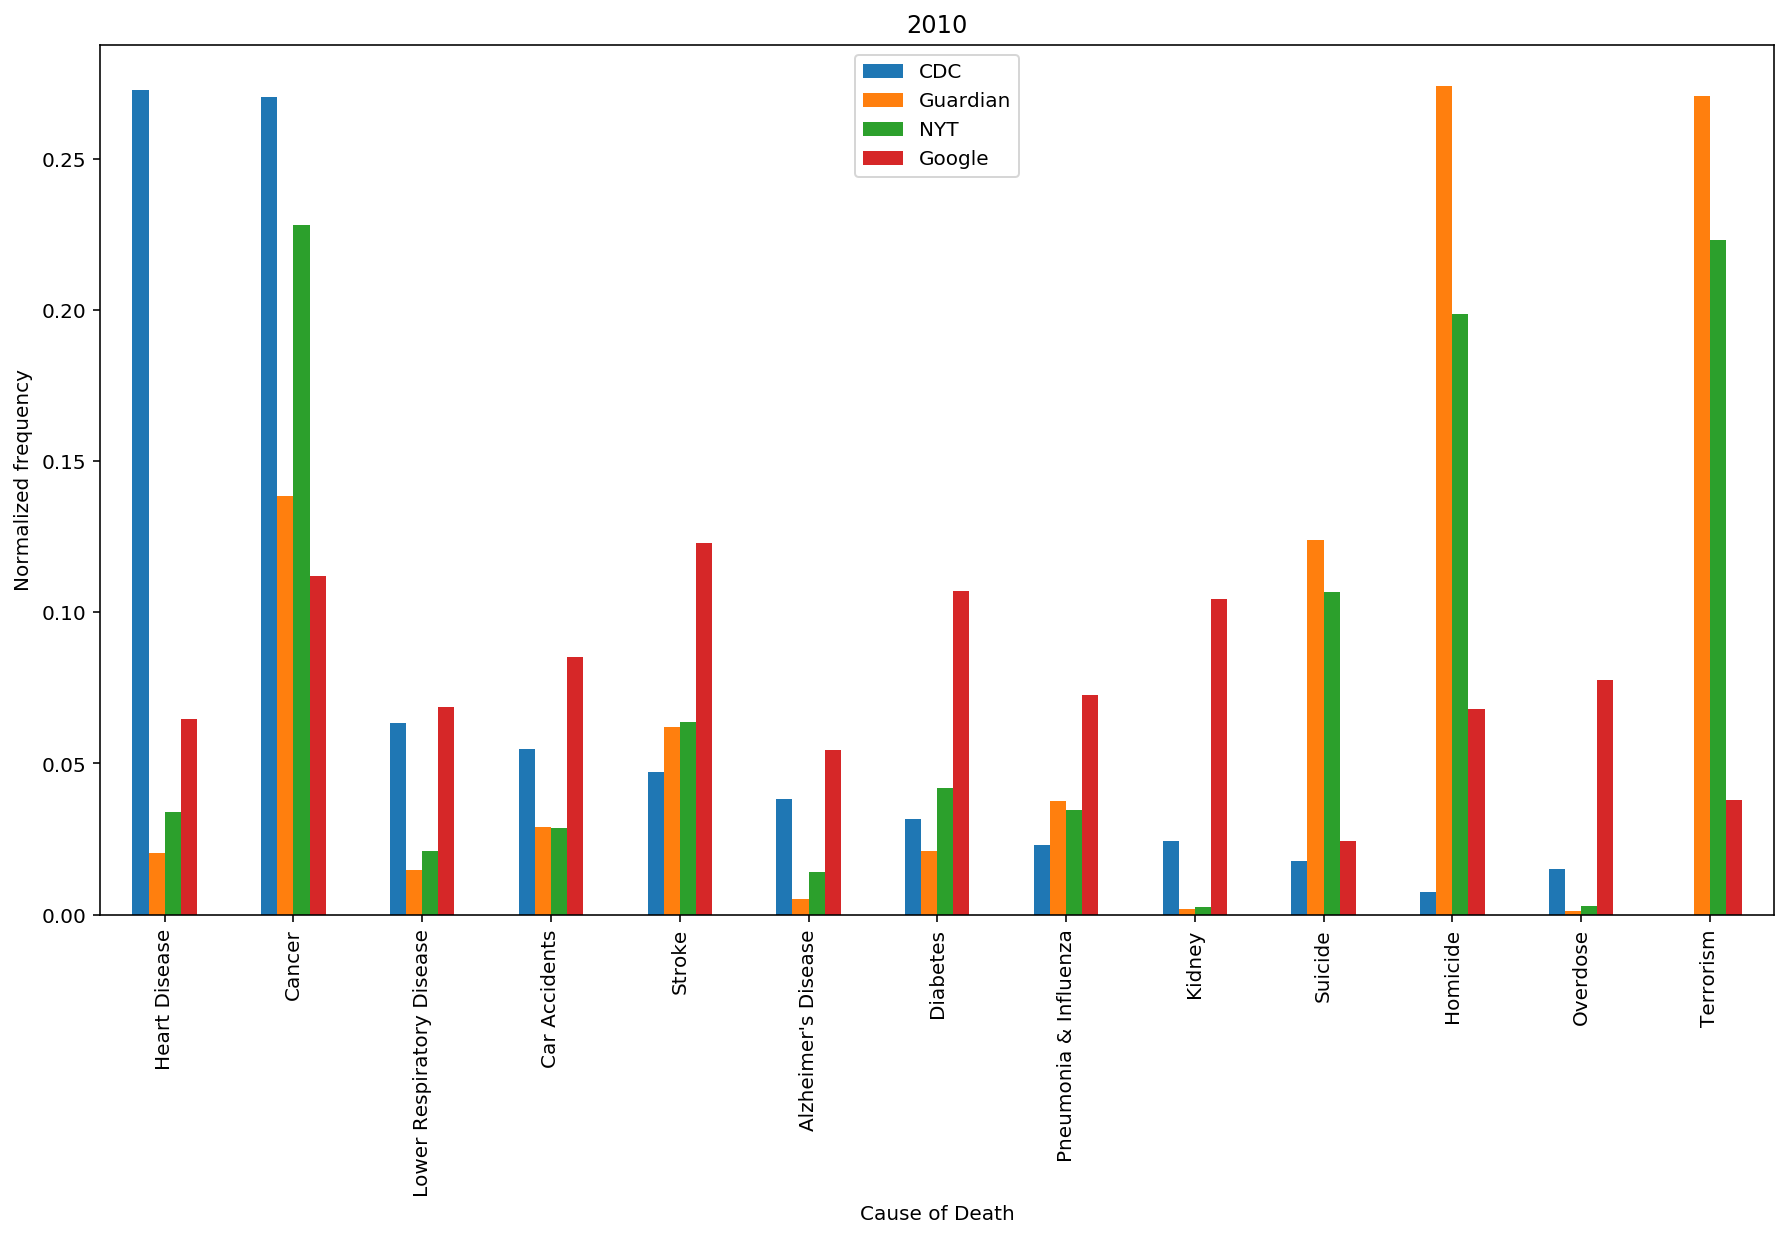

In [34]:
year = 2010
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

Text(0.5,1,'2011')

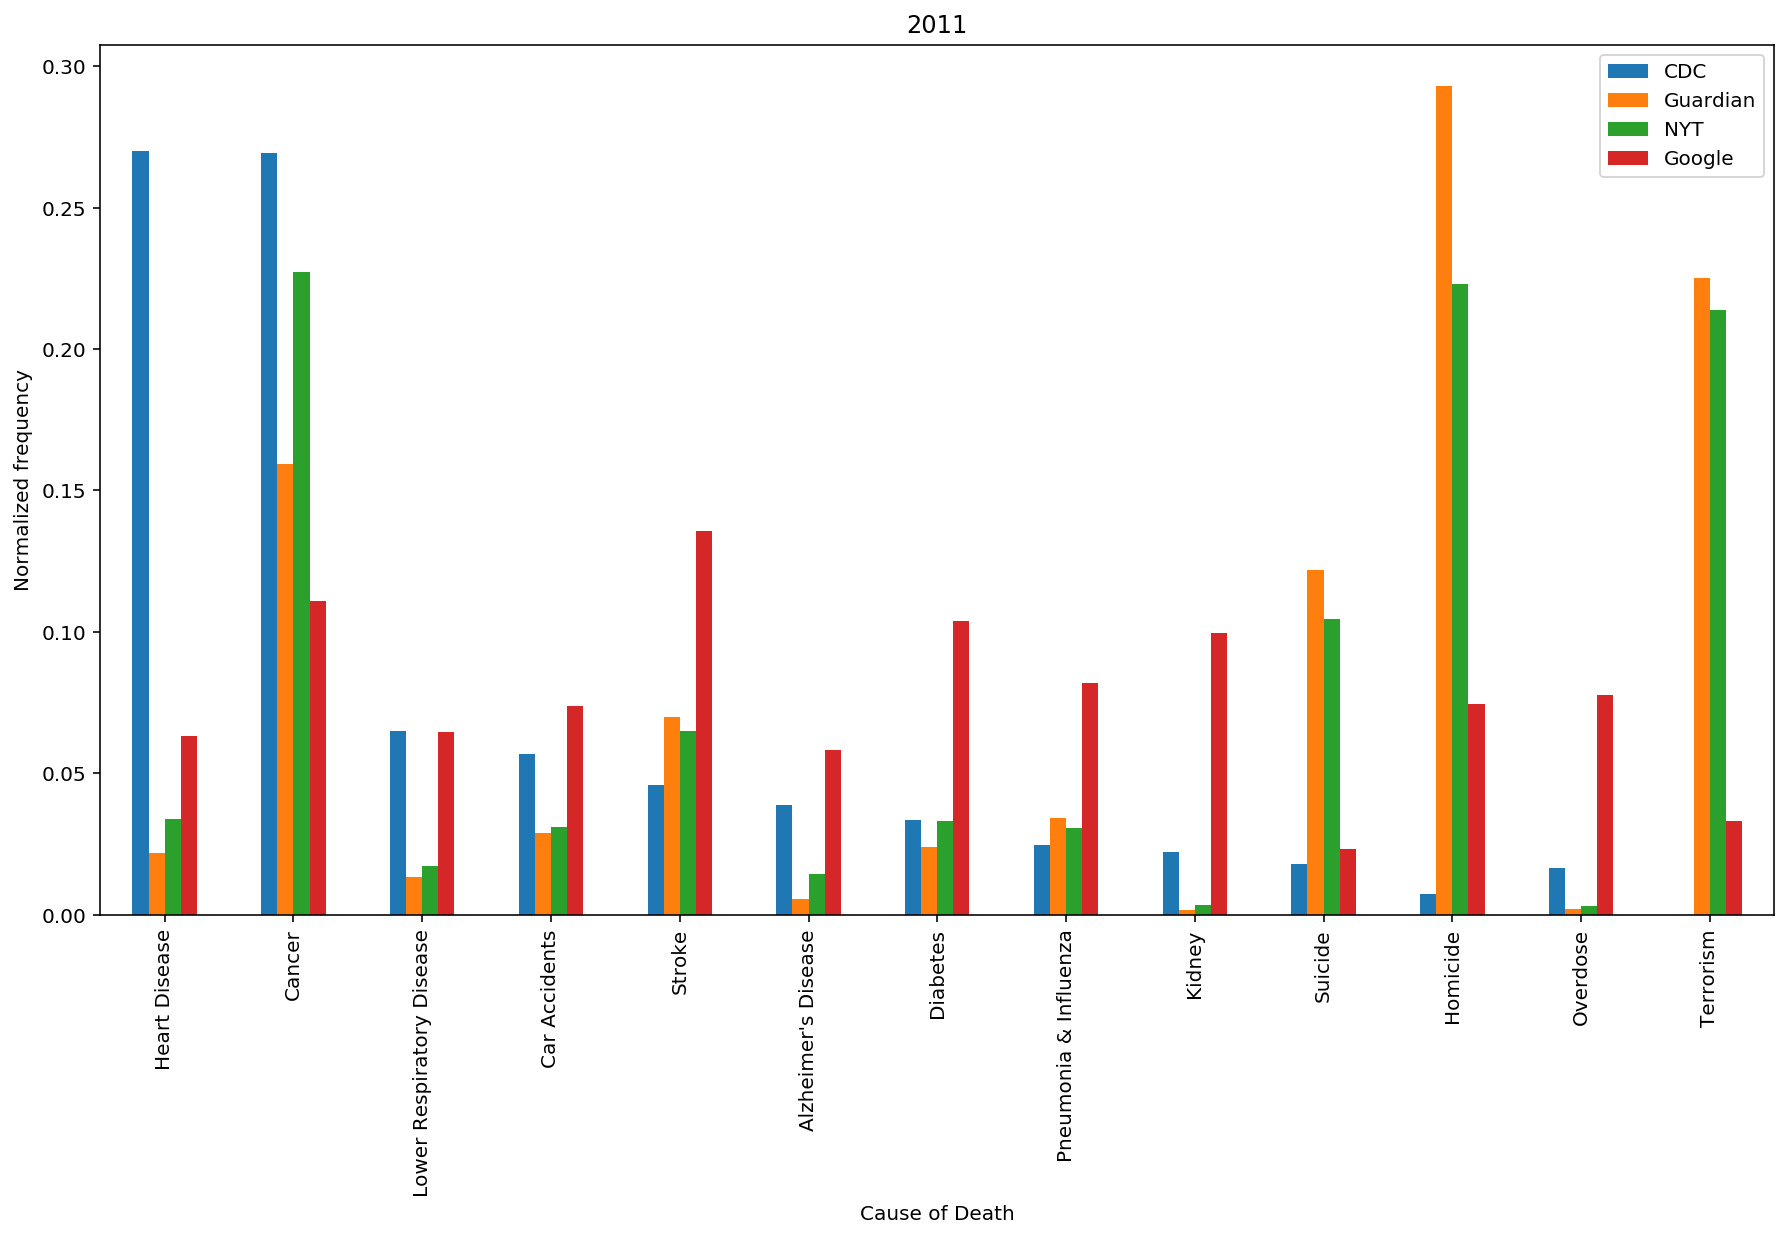

In [35]:
year = 2011
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

Text(0.5,1,'2012')

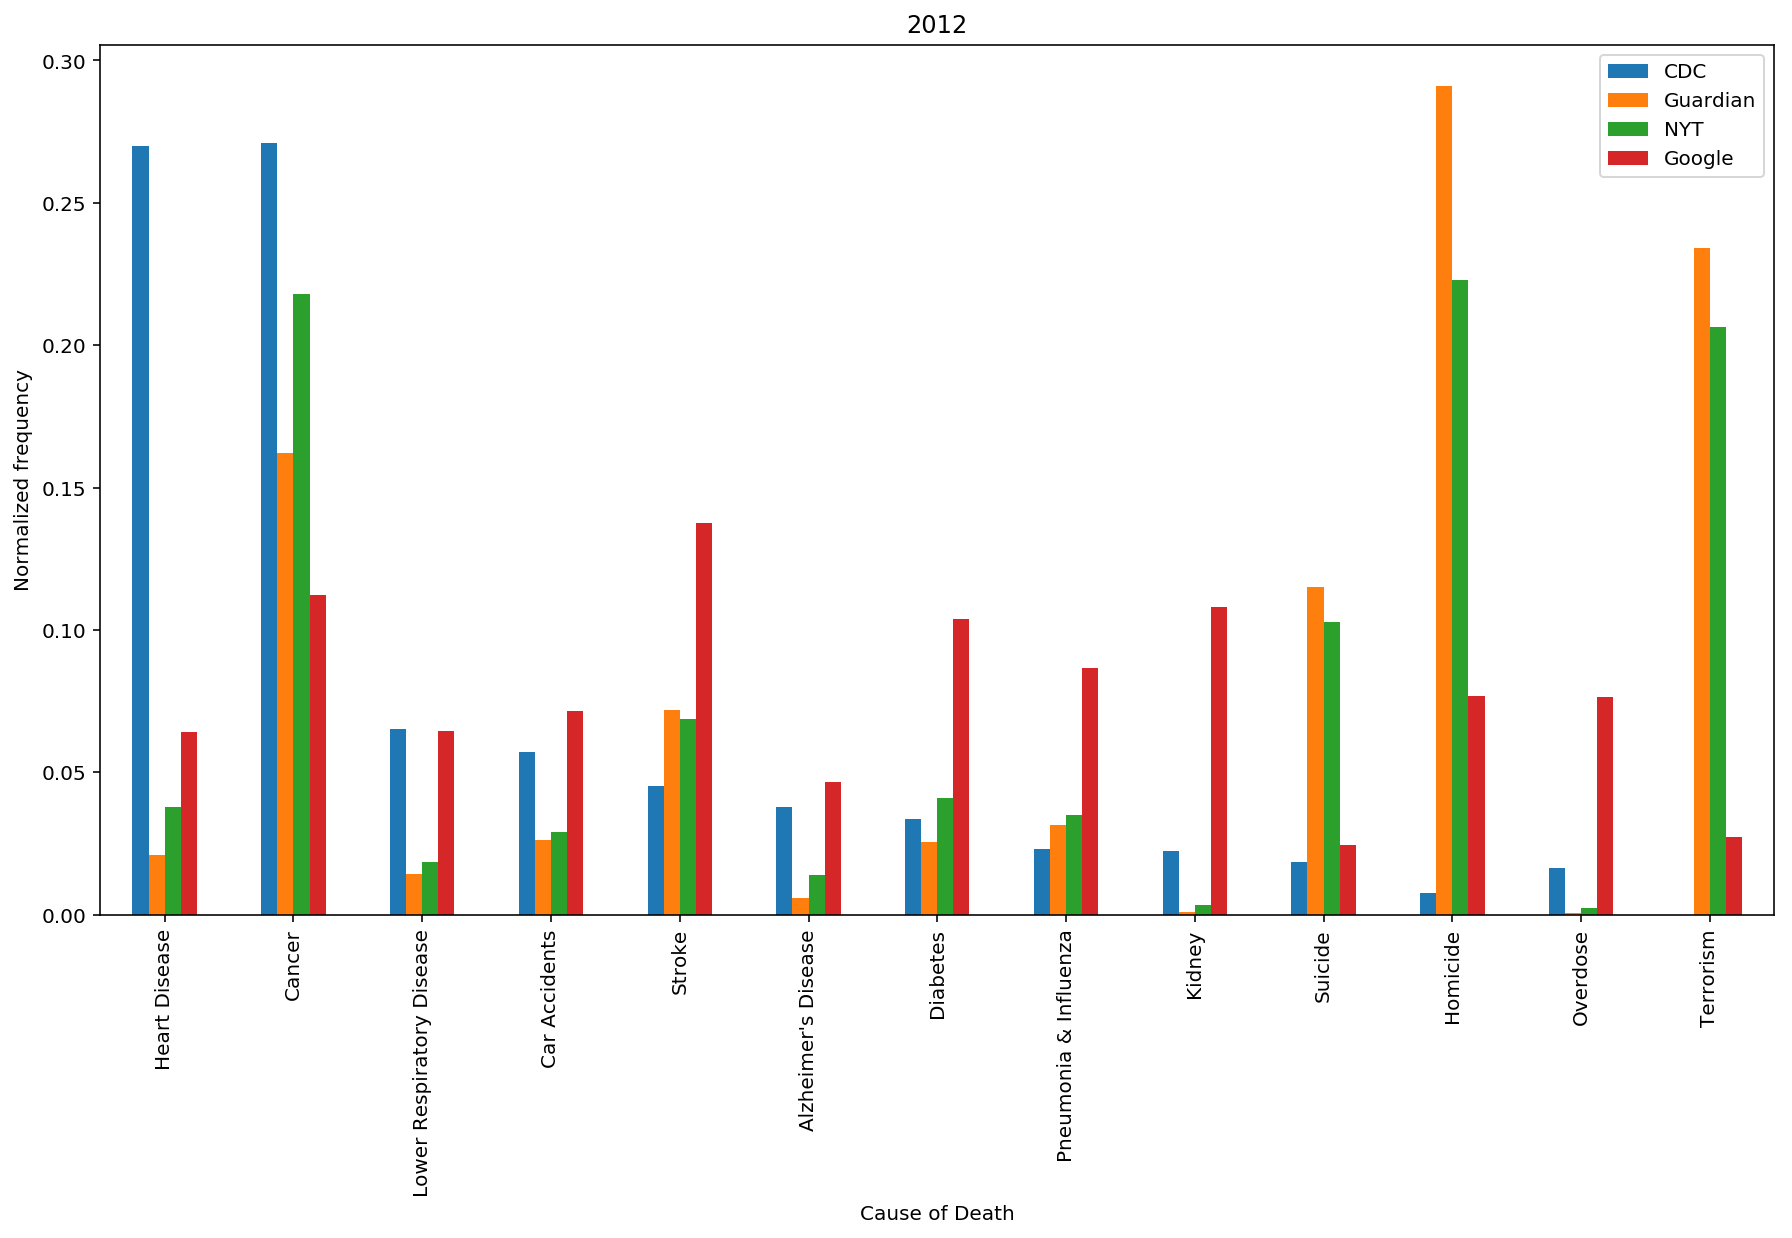

In [36]:
year = 2012
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

Text(0.5,1,'2013')

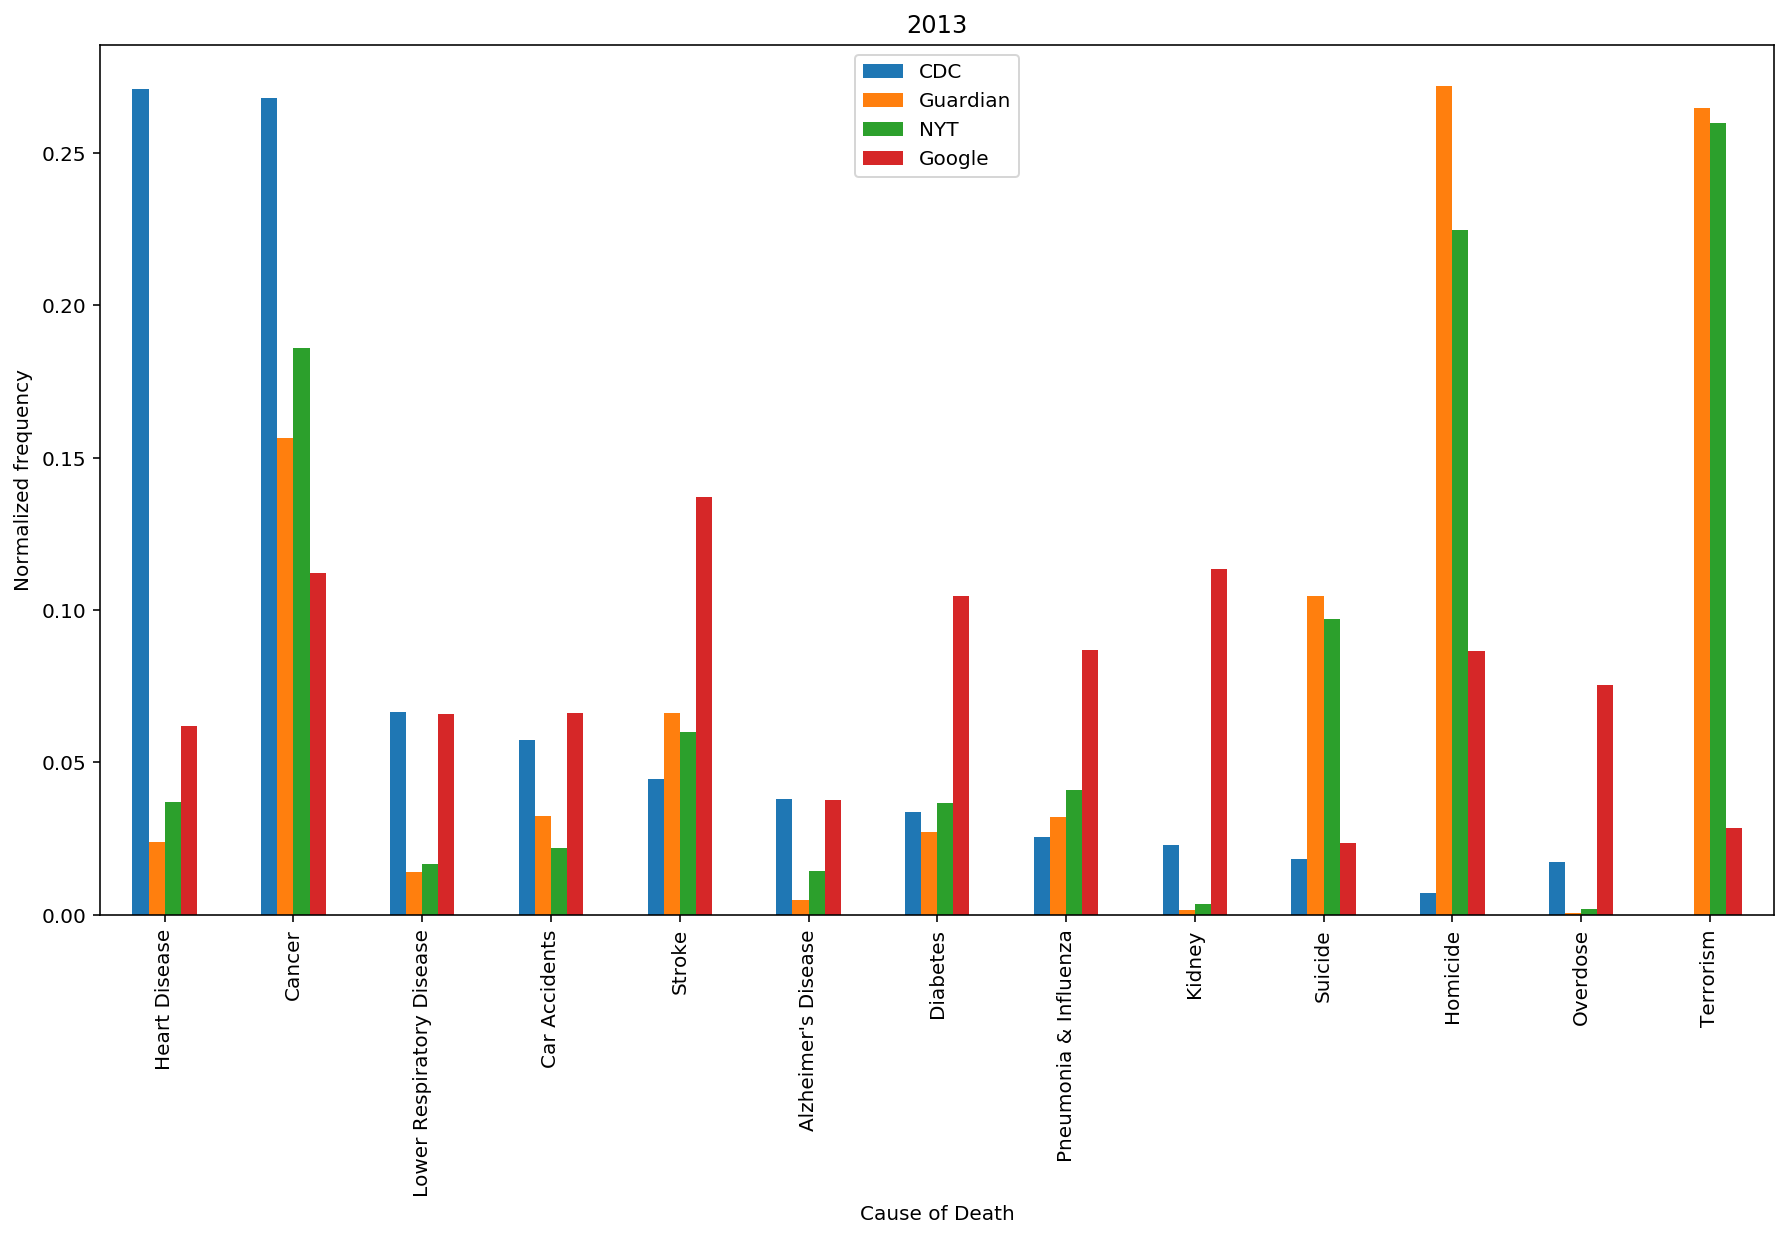

In [37]:
year = 2013
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

Text(0.5,1,'2014')

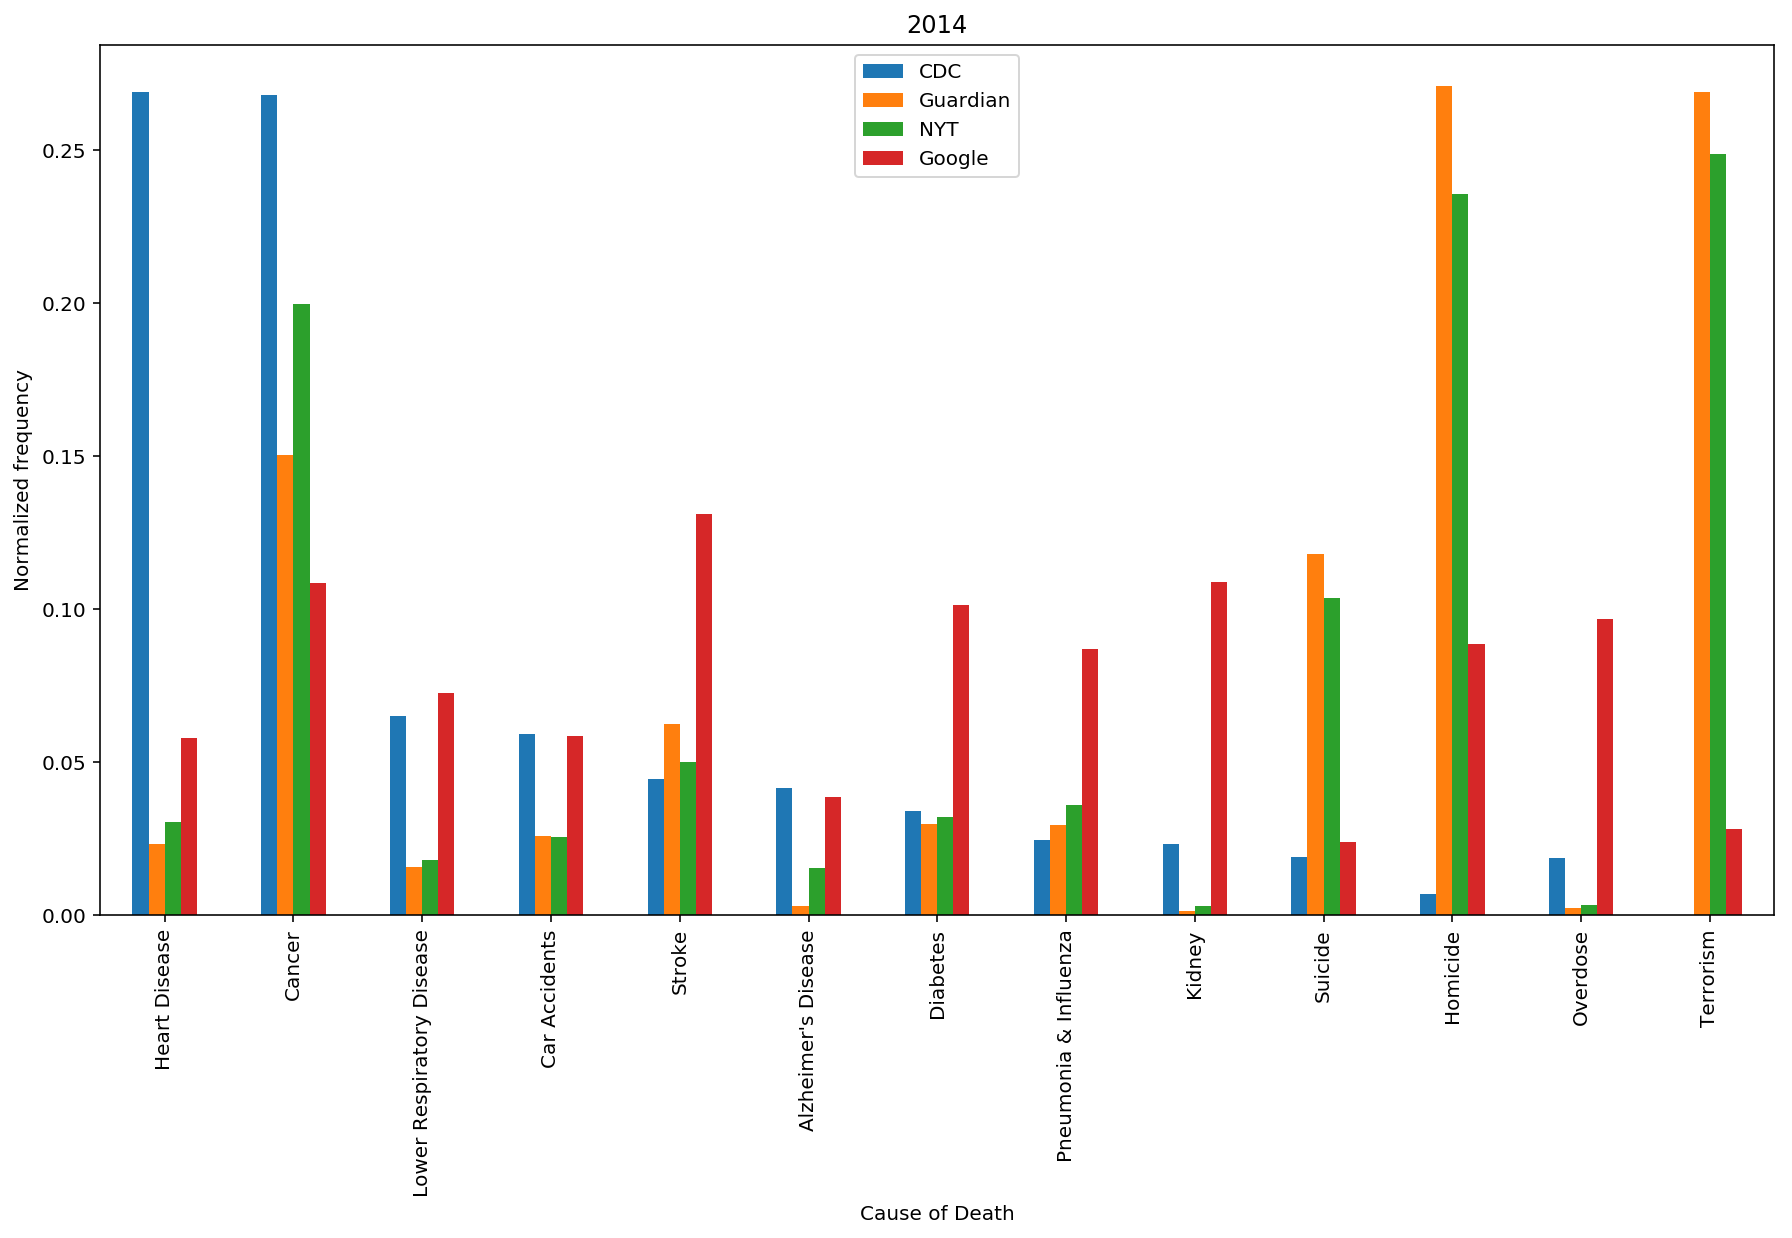

In [38]:
year = 2014
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

Text(0.5,1,'2015')

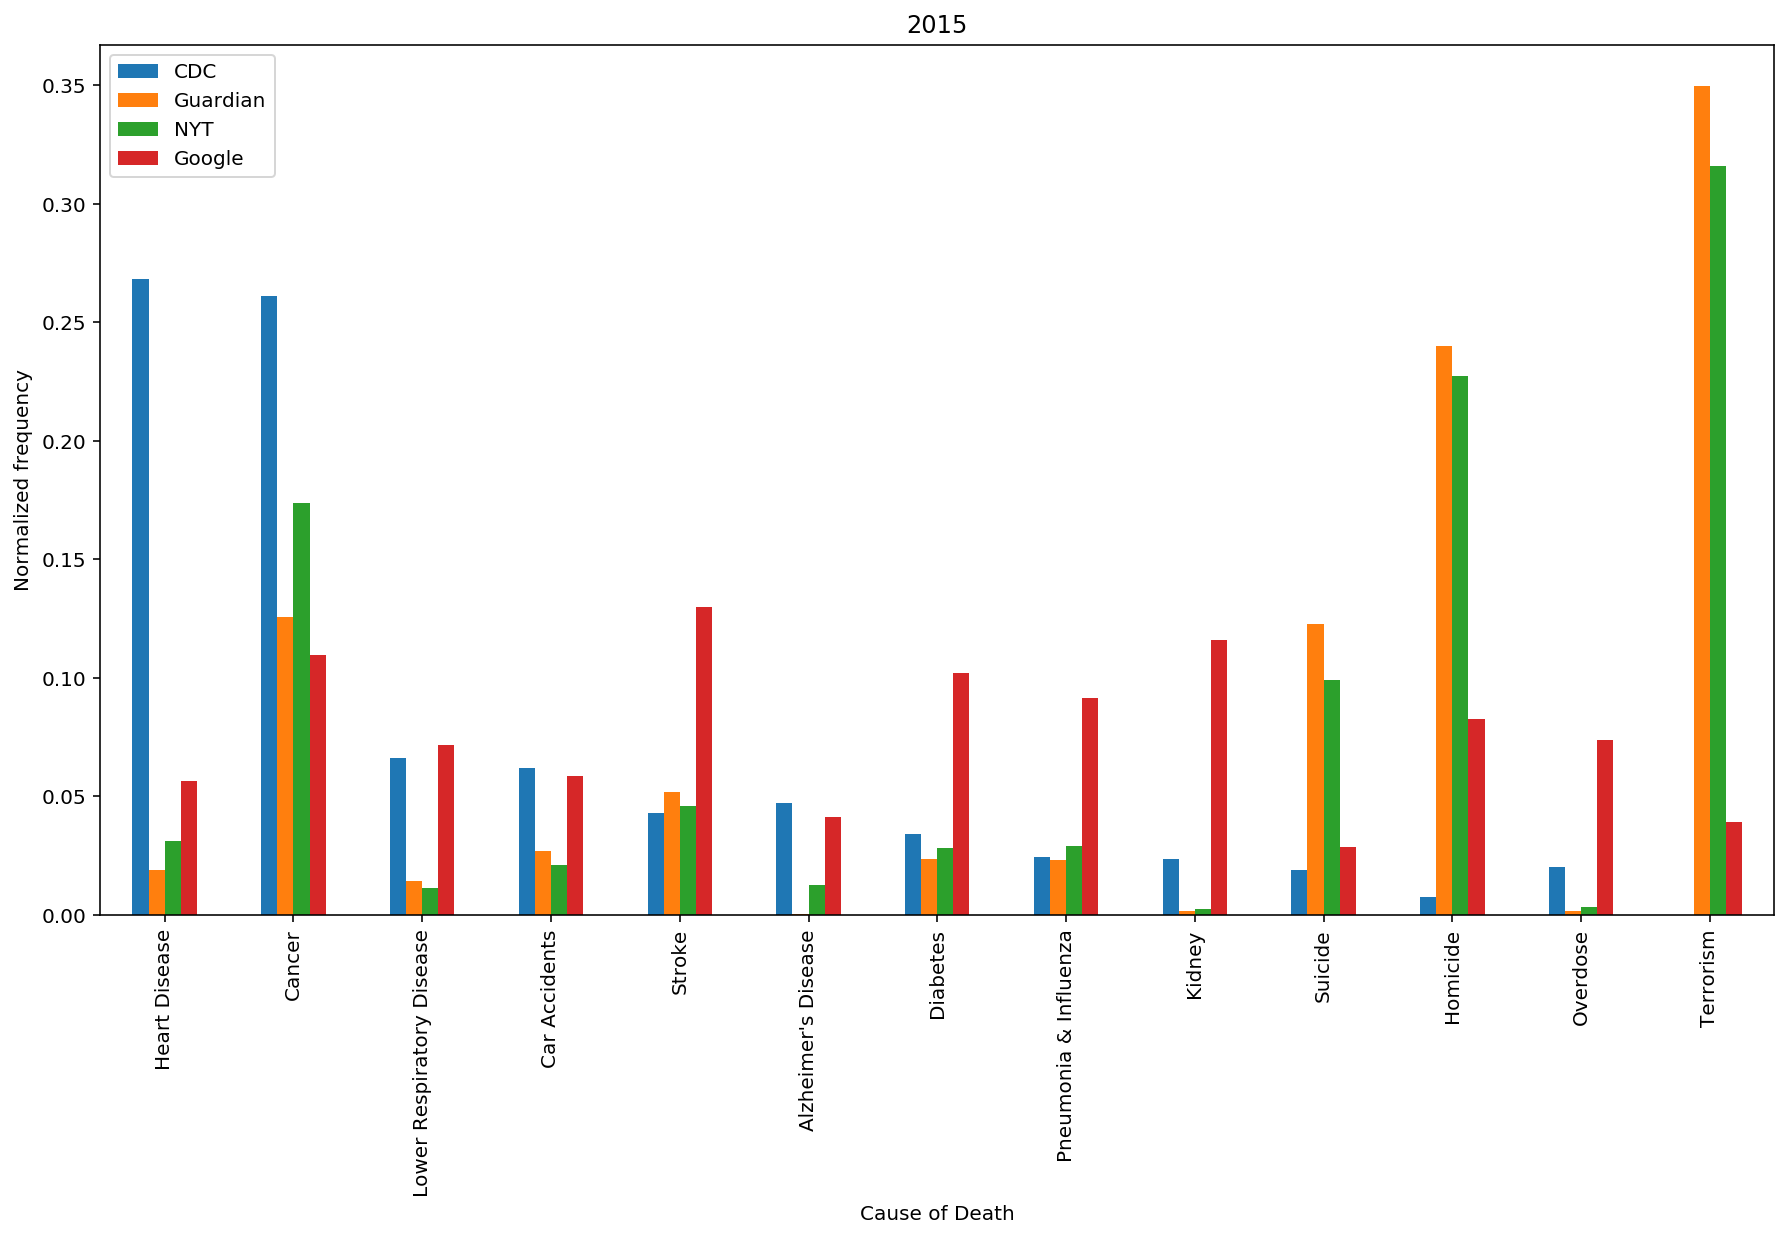

In [39]:
year = 2015
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

Text(0.5,1,'2016')

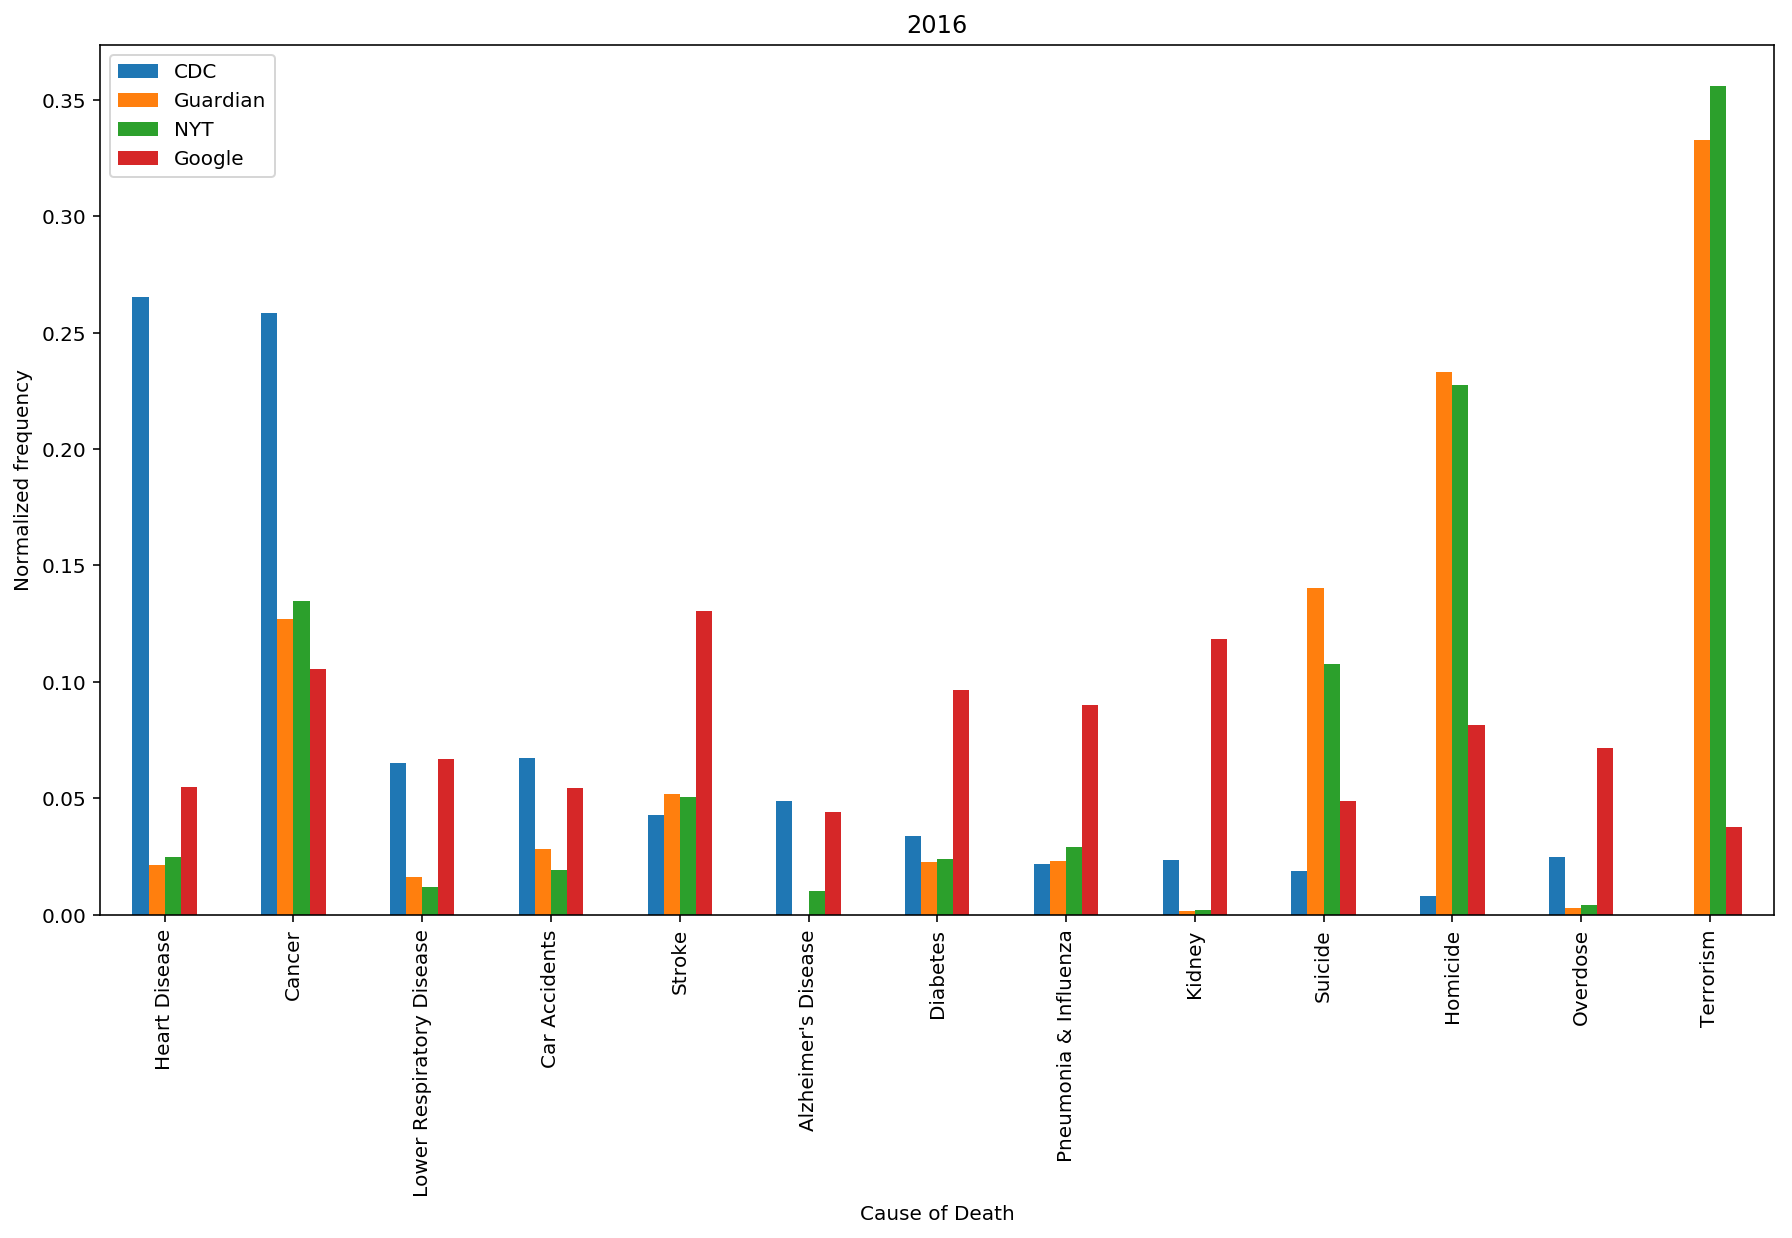

In [40]:
year = 2016
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

## Terrorism plot

Text(0.5,0,'year')

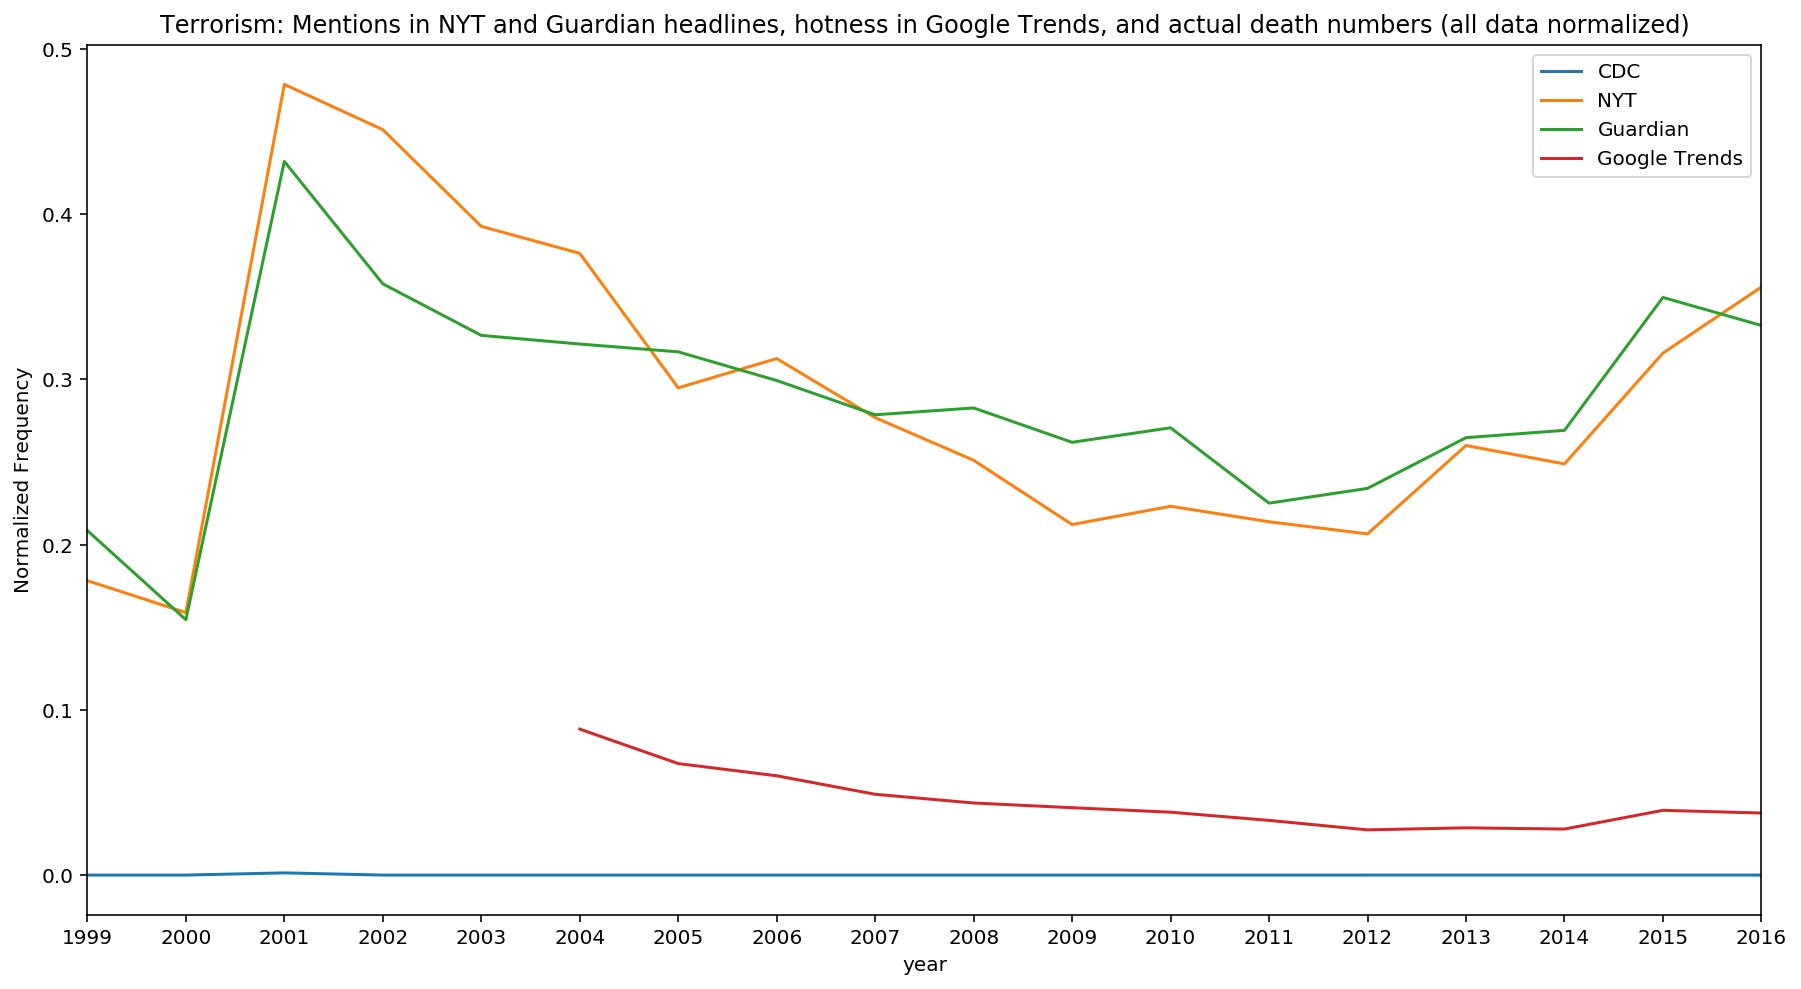

In [135]:
# Terrorism data
terrorism_data = pd.DataFrame(\
    [cdc_years_norm.loc['terrorism', :].tolist(),
     NYT_df.loc[NYT_df['Cause of Death'] == 'Terrorism', :].drop('Cause of Death', axis=1).get_values().tolist()[0],
     Guardian_df_renamed2.loc['Terrorism', :].tolist()[1:],
     pd.Series(np.repeat(np.nan, 5)).append(Google_df_renamed2.loc['Terrorism', :][1:]).tolist()]).transpose()

terrorism_data.columns = ['CDC', 'NYT', 'Guardian', 'Google Trends']
terrorism_data.index = np.arange(1999, 2016+1)
terrorism_data.plot(xticks=np.arange(1999, 2016+1))
plt.title('Terrorism: Mentions in NYT and Guardian headlines, hotness in Google Trends, and actual death numbers (all data normalized)')
plt.ylabel('Normalized Frequency')
plt.xlabel('year')

## Statistical Significance Tests

In [145]:
print("Guardian vs. CDC: chi squared = {:.2f}, p = {:.3f}".format(*tuple(sp.stats.chisquare(all_years_all_data['Guardian'], all_years_all_data['CDC']))))
print("NYT vs. CDC:      chi squared = {:.2f}, p = {:.3f}".format(*tuple(sp.stats.chisquare(all_years_all_data['NYT'], all_years_all_data['CDC']))))
print("Google vs. CDC:   chi squared = {:.2f}, p = {:.3f}".format(*tuple(sp.stats.chisquare(all_years_all_data['Google'], all_years_all_data['CDC']))))
print("Guardian vs. NYT: chi squared = {:.2f}, p = {:.3f}".format(*tuple(sp.stats.chisquare(all_years_all_data['Guardian'], all_years_all_data['NYT']))))

Guardian vs. CDC: chi squared = 20378.90, p = 0.000
NYT vs. CDC:      chi squared = 20476.48, p = 0.000
Google vs. CDC:   chi squared = 268.98, p = 0.000
Guardian vs. NYT: chi squared = 0.97, p = 1.000


Looks good! Guardian vs. CDC, NYT vs. CDC, and Google vs. CDC all differ highly significantly ($p < .001$). Guardian vs. NYT is highly non-significant, which is what we expected!

# Discussion

The most surprising result that can be drawn from our analysis is probably conveyed by the plot of terrorism data, which is copied here once more for better readability:

(<matplotlib.axes._subplots.AxesSubplot at 0x7fe1a2ad2668>,
 Text(0.5,1,'Terrorism: Mentions in NYT and Guardian headlines, hotness in Google Trends, and actual death numbers (all data normalized)'),
 Text(0,0.5,'Normalized Frequency'),
 Text(0.5,0,'year'))

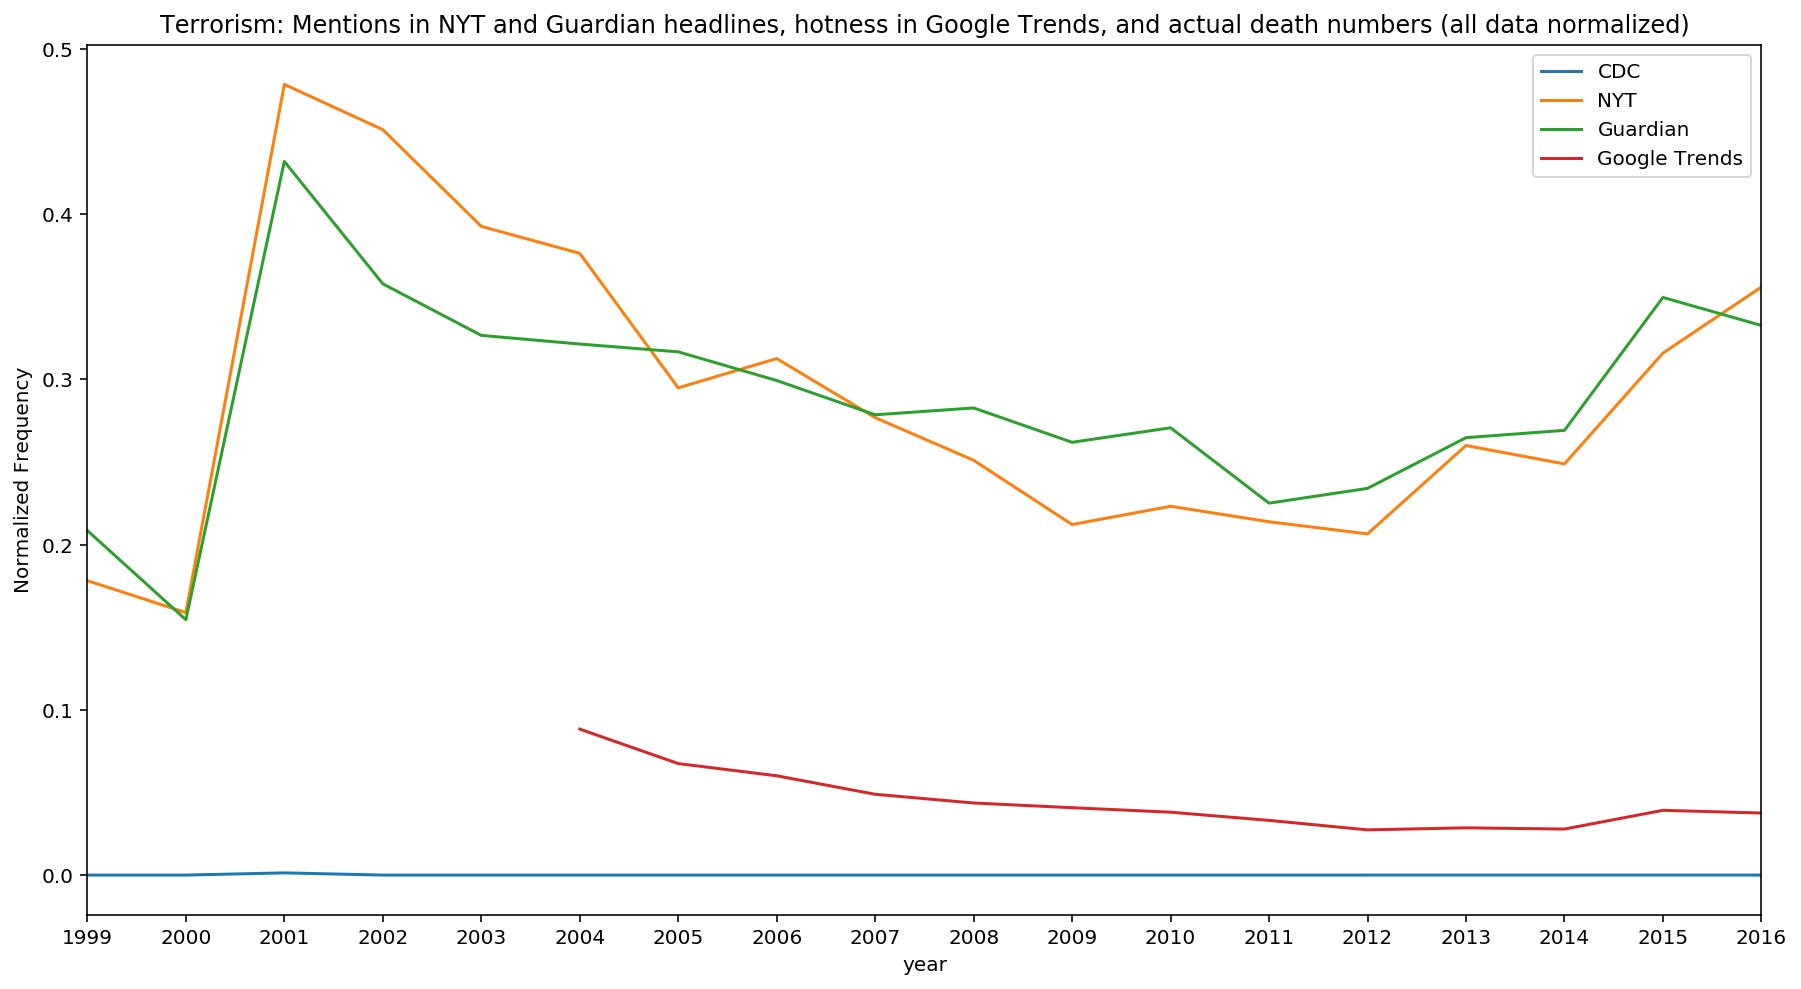

In [136]:
terrorism_data.plot(xticks=np.arange(1999, 2016+1)), plt.title('Terrorism: Mentions in NYT and Guardian headlines, hotness in Google Trends, and actual death numbers (all data normalized)'), plt.ylabel('Normalized Frequency'), plt.xlabel('year')

At least two things become apparent by looking at this plot: First, the temporal correlation of attention towards terrorism is very high for the NYT and the Guardian. This is what we expected, but still a good sign for the validity of the data yielded by our news-scraper.

Second, while there is a huge jump in media attention after 9/11, the jump of the _normalized_ morbidity rate for terrorism is barely visible (as a reminder: We normalized CDC data by dividing the frequencies associated with each death cause category by the sum of frequencies over all categories we were looking at for a given year. The news data was normalized in a similar fashion by dividing the number of hits for a category and year by the sum of hits for all categories of interest for the same year). This is already sufficient to prove that media does _not_ cover different causes of death with a distribution of attention that is proportionate to the actual distribution of death cause frequencies.

(Google Trends data is only available for 2004 and after.)

Now let's look at a different cause of death, namely heart diseases:

Text(0.5,0,'year')

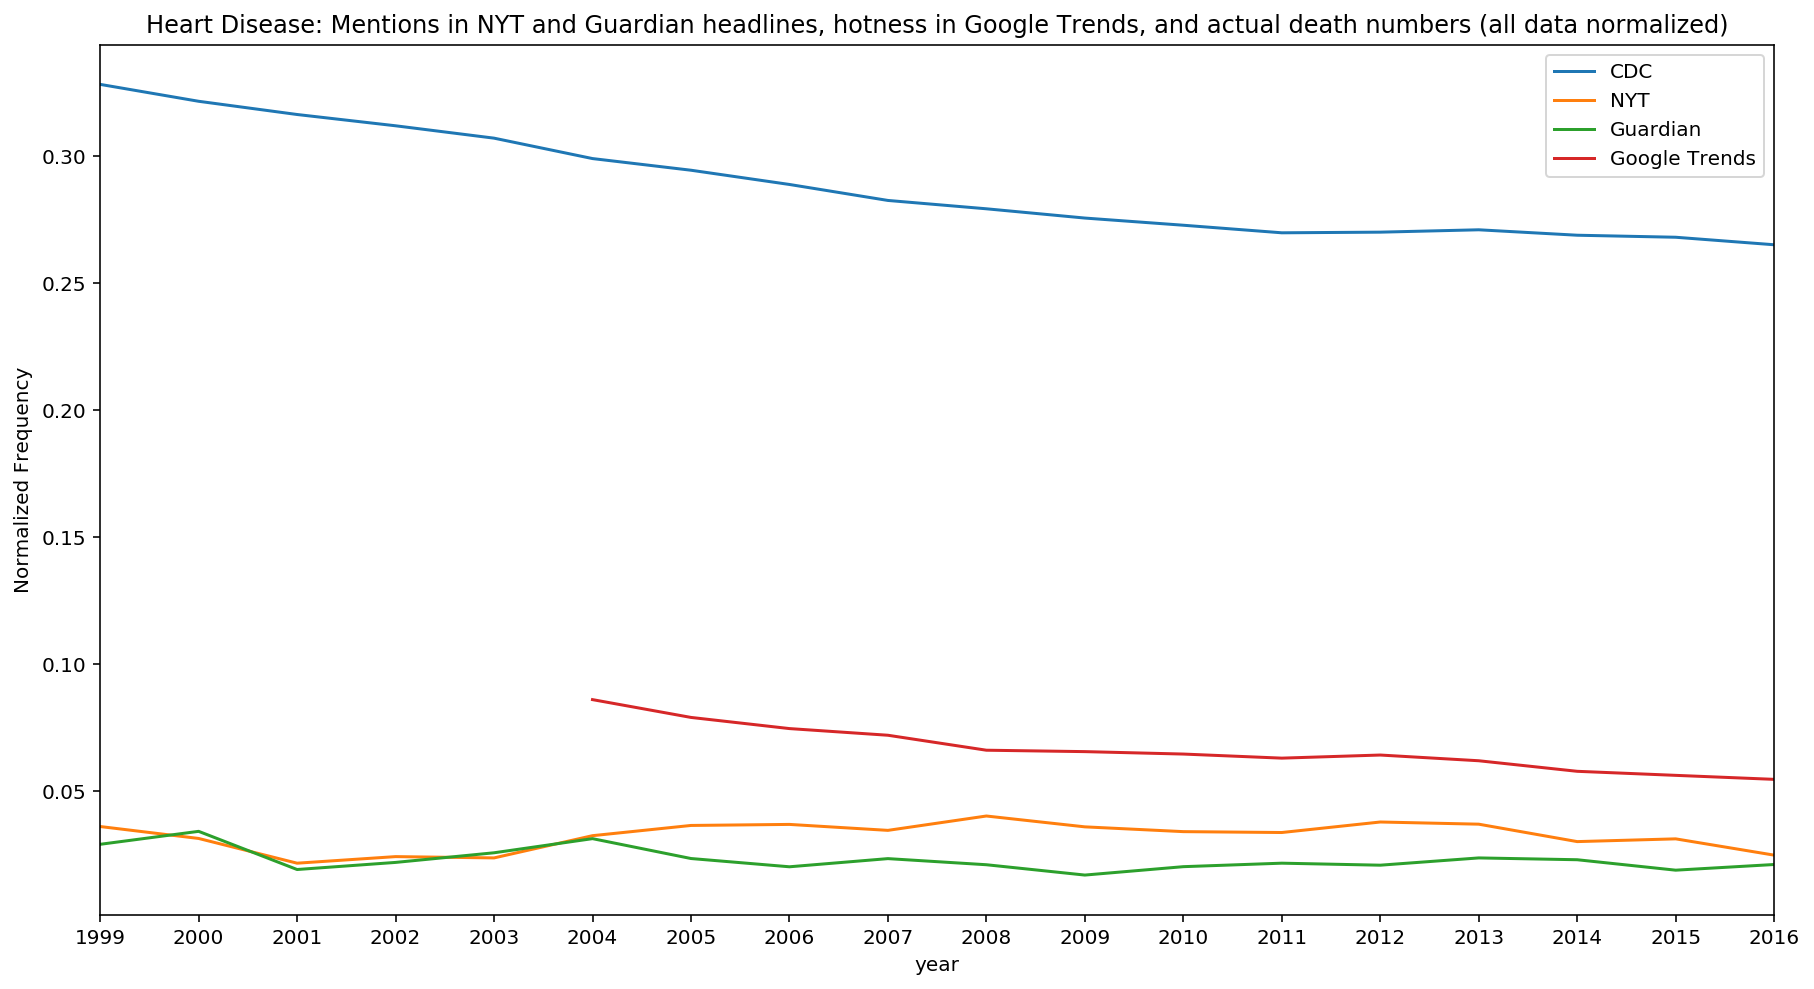

In [143]:
# Terrorism data
heart_data = pd.DataFrame(\
    [cdc_years_norm.loc['heart', :].tolist(),
     NYT_df.loc[NYT_df['Cause of Death'] == 'Heart Disease', :].drop('Cause of Death', axis=1).get_values().tolist()[0],
     Guardian_df_renamed2.loc['Heart Disease', :].tolist()[1:],
     pd.Series(np.repeat(np.nan, 5)).append(Google_df_renamed2.loc['Heart Disease', :][1:]).tolist()]).transpose()

heart_data.columns = ['CDC', 'NYT', 'Guardian', 'Google Trends']
heart_data.index = np.arange(1999, 2016+1)
heart_data.plot(xticks=np.arange(1999, 2016+1))
plt.title('Heart Disease: Mentions in NYT and Guardian headlines, hotness in Google Trends, and actual death numbers (all data normalized)')
plt.ylabel('Normalized Frequency')
plt.xlabel('year')

This example shows the opposite pattern. Heart diseases are under-represented in news coverage when compared to their actual normalized frequencies.

Here again a plot with the overall normalized death/mentioning frequencies for all causes of death, summed over years:

Text(0,0.5,'Normalized frequency')

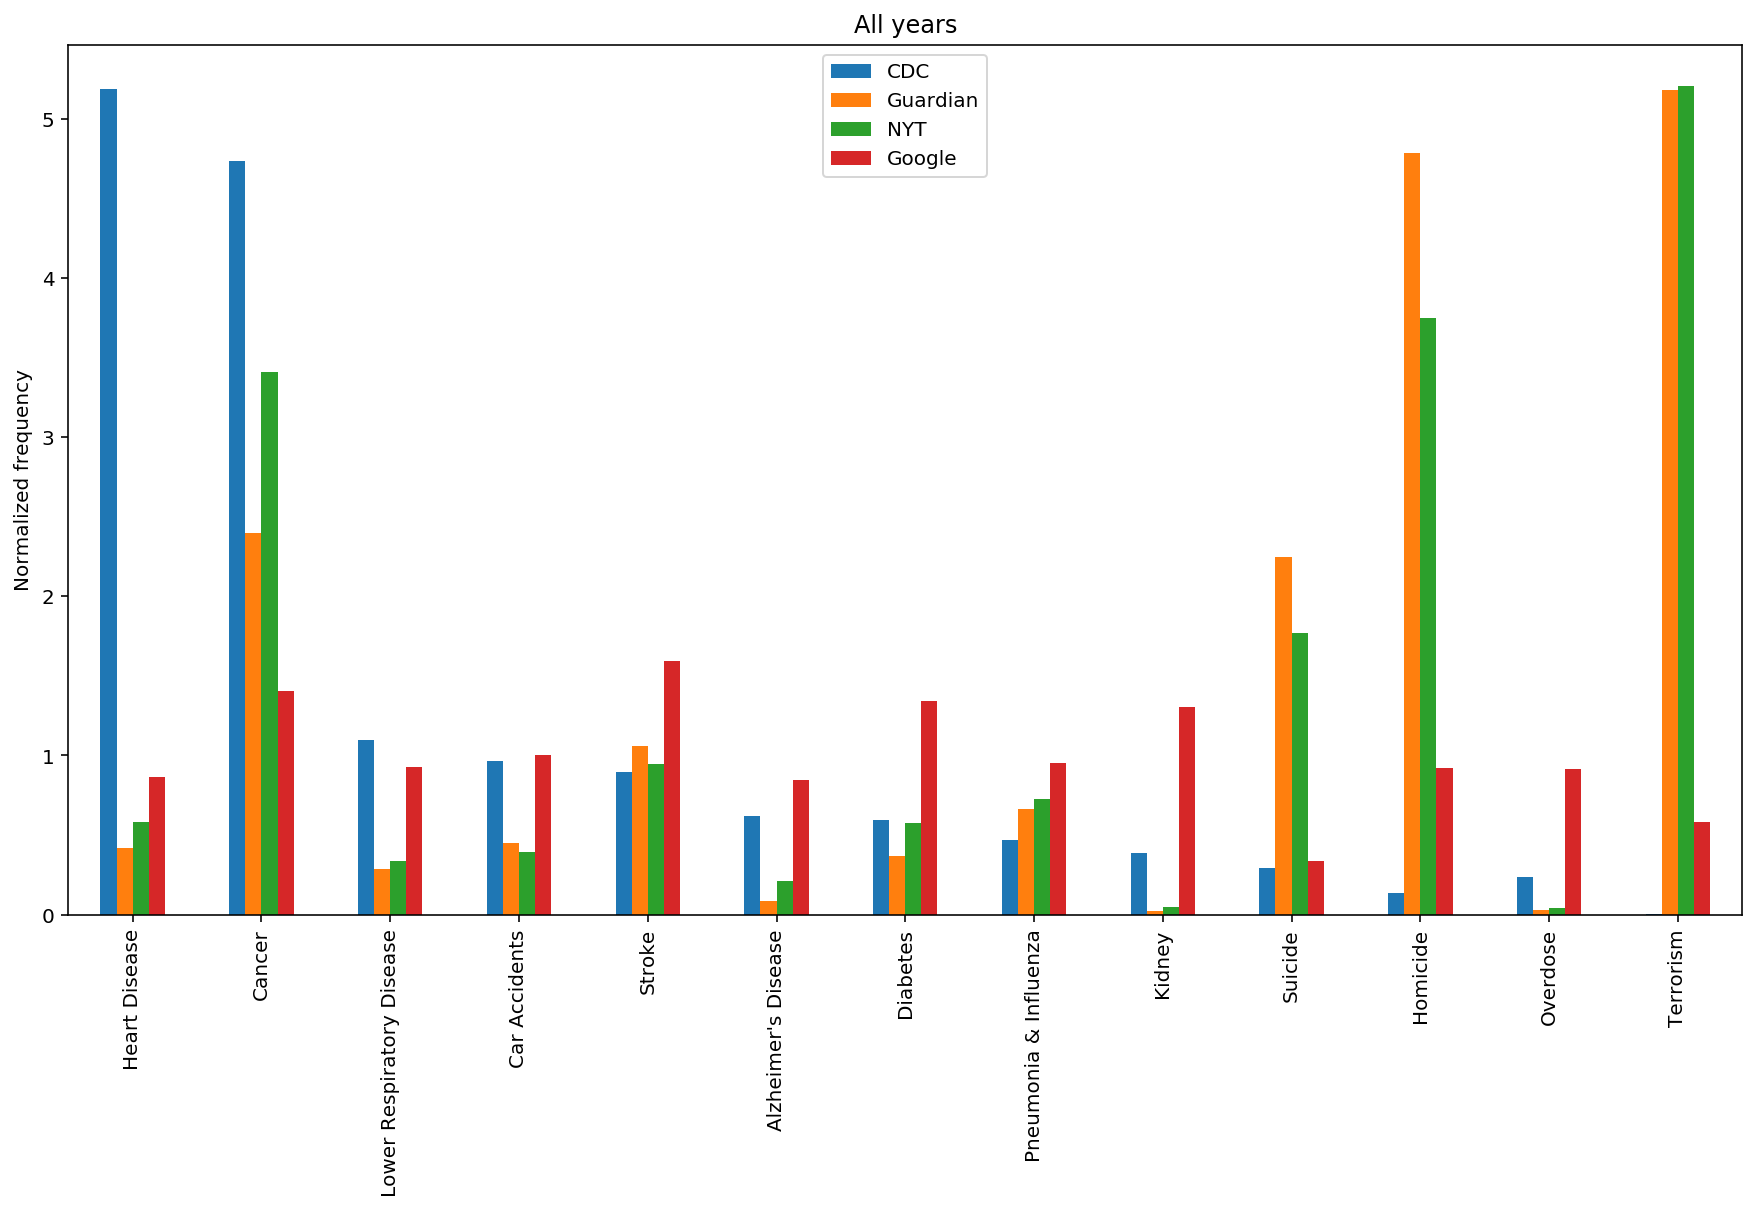

In [144]:
all_years_all_data.plot(kind = 'bar')
plt.title('All years')
plt.ylabel('Normalized frequency')

Judging from this distribution, it seems that the importance of diseases and accidents as death causes is overall exaggerated by the NYT and the Guardian, whereas suicides, homicides, and terrorism are largely over-represented. Note that _of all categories we took into consideration, the two causes of death with the largest media coverage are at the same time the two least frequent causes of death_!

Another interesting note is that the results from Google Trends indicate that people's searching behavior is actually not as biased towards specific causes of death as the news are. Actually, between 2004 and 2016, people displayed more interest in topics such as lower respiratory diseases or kidney diseases than in terrorism. Of all death causes we considered, terrorism ranked second-lowest in terms of people's interest expressed through their search behavior!

# CDC Data Consolidation

In [7]:
# DISEASE CODES
caraccidentCode = '(V\d\d)'
accidentCode = '(W\d\d|X[0123]\d)'
cancerCode = '(C\d\d|D0\d|D1\d|D2\d|D3\d|D4\d)'
overdoseCode = '(X4\d)'
homicideCode = '(X8[56789]|X9\d|Y0\d)'
suicideCode = '(X6\d|X7\d|X8[01234]|Y73)'
kidneyCode = '(N[012]\d)'
flupneuCode = '(J09|J1[012345678])'
diabetesCode = '(E0[89]|E1[01234])'
heartCode = '(I0[56789]|I11|I2[678]|I[34]\d|I5[012])'
strokeCode = '(I6[012349])'
lowrespiratoryCode = '(J4[01234567])'
terrorismCode = '(U\d\d|Y38)'
alzheimersCode = '(G30)'

## Splitting the datasets into years

In [8]:
# Splitting the main dataset into the separate years. 
cdc_main_1999 = cdc_chapter.loc[cdc_chapter['Year'] == 1999]
cdc_main_2000 = cdc_chapter.loc[cdc_chapter['Year'] == 2000]
cdc_main_2001 = cdc_chapter.loc[cdc_chapter['Year'] == 2001]
cdc_main_2002 = cdc_chapter.loc[cdc_chapter['Year'] == 2002]
cdc_main_2003 = cdc_chapter.loc[cdc_chapter['Year'] == 2003]
cdc_main_2004 = cdc_chapter.loc[cdc_chapter['Year'] == 2004]
cdc_main_2005 = cdc_chapter.loc[cdc_chapter['Year'] == 2005]
cdc_main_2006 = cdc_chapter.loc[cdc_chapter['Year'] == 2006]
cdc_main_2007 = cdc_chapter.loc[cdc_chapter['Year'] == 2007]
cdc_main_2008 = cdc_chapter.loc[cdc_chapter['Year'] == 2008]
cdc_main_2009 = cdc_chapter.loc[cdc_chapter['Year'] == 2009]
cdc_main_2010 = cdc_chapter.loc[cdc_chapter['Year'] == 2010]
cdc_main_2011 = cdc_chapter.loc[cdc_chapter['Year'] == 2011]
cdc_main_2012 = cdc_chapter.loc[cdc_chapter['Year'] == 2012]
cdc_main_2013 = cdc_chapter.loc[cdc_chapter['Year'] == 2013]
cdc_main_2014 = cdc_chapter.loc[cdc_chapter['Year'] == 2014]
cdc_main_2015 = cdc_chapter.loc[cdc_chapter['Year'] == 2015]
cdc_main_2016 = cdc_chapter.loc[cdc_chapter['Year'] == 2016]


In [9]:
# Separating the deaths by year for the medium detailed dataset
cdc_mid_1999 = cdc_cause113.loc[cdc_cause113['Year'] == 1999]
cdc_mid_2000 = cdc_cause113.loc[cdc_cause113['Year'] == 2000]
cdc_mid_2001 = cdc_cause113.loc[cdc_cause113['Year'] == 2001]
cdc_mid_2002 = cdc_cause113.loc[cdc_cause113['Year'] == 2002]
cdc_mid_2003 = cdc_cause113.loc[cdc_cause113['Year'] == 2003]
cdc_mid_2004 = cdc_cause113.loc[cdc_cause113['Year'] == 2004]
cdc_mid_2005 = cdc_cause113.loc[cdc_cause113['Year'] == 2005]
cdc_mid_2006 = cdc_cause113.loc[cdc_cause113['Year'] == 2006]
cdc_mid_2007 = cdc_cause113.loc[cdc_cause113['Year'] == 2007]
cdc_mid_2008 = cdc_cause113.loc[cdc_cause113['Year'] == 2008]
cdc_mid_2009 = cdc_cause113.loc[cdc_cause113['Year'] == 2009]
cdc_mid_2010 = cdc_cause113.loc[cdc_cause113['Year'] == 2010]
cdc_mid_2011 = cdc_cause113.loc[cdc_cause113['Year'] == 2011]
cdc_mid_2012 = cdc_cause113.loc[cdc_cause113['Year'] == 2012]
cdc_mid_2013 = cdc_cause113.loc[cdc_cause113['Year'] == 2013]
cdc_mid_2014 = cdc_cause113.loc[cdc_cause113['Year'] == 2014]
cdc_mid_2015 = cdc_cause113.loc[cdc_cause113['Year'] == 2015]
cdc_mid_2016 = cdc_cause113.loc[cdc_cause113['Year'] == 2016]

#Separating the deaths by year for the detailed one
#cdc_2015[cdc_2015['Cause'].str.contains("")==True]


In [10]:
# Separating the deaths by year for the most specific dataset 
cdc_spec_1999 = cdc_cause.loc[cdc_cause['Year'] == 1999]
cdc_spec_2000 = cdc_cause.loc[cdc_cause['Year'] == 2000]
cdc_spec_2001 = cdc_cause.loc[cdc_cause['Year'] == 2001]
cdc_spec_2002 = cdc_cause.loc[cdc_cause['Year'] == 2002]
cdc_spec_2003 = cdc_cause.loc[cdc_cause['Year'] == 2003]
cdc_spec_2004 = cdc_cause.loc[cdc_cause['Year'] == 2004]
cdc_spec_2005 = cdc_cause.loc[cdc_cause['Year'] == 2005]
cdc_spec_2006 = cdc_cause.loc[cdc_cause['Year'] == 2006]
cdc_spec_2007 = cdc_cause.loc[cdc_cause['Year'] == 2007]
cdc_spec_2008 = cdc_cause.loc[cdc_cause['Year'] == 2008]
cdc_spec_2009 = cdc_cause.loc[cdc_cause['Year'] == 2009]
cdc_spec_2010 = cdc_cause.loc[cdc_cause['Year'] == 2010]
cdc_spec_2011 = cdc_cause.loc[cdc_cause['Year'] == 2011]
cdc_spec_2012 = cdc_cause.loc[cdc_cause['Year'] == 2012]
cdc_spec_2013 = cdc_cause.loc[cdc_cause['Year'] == 2013]
cdc_spec_2014 = cdc_cause.loc[cdc_cause['Year'] == 2014]
cdc_spec_2015 = cdc_cause.loc[cdc_cause['Year'] == 2015]
cdc_spec_2016 = cdc_cause.loc[cdc_cause['Year'] == 2016]

## Getting Data for different diseases for each year

In [11]:
# ICD 10 CODES
caraccidentCode = '(V\d\d)'
cancerCode = '(C\d\d|D0\d|D1\d|D2\d|D3\d|D4\d)'
overdoseCode = '(X4\d)'
homicideCode = '(X8[56789]|X9\d|Y0\d)'
suicideCode = '(X6\d|X7\d|X8[01234]|Y73)'
kidneyCode = '(N[012]\d)'
flupneuCode = '(J09|J1[012345678])'
diabetesCode = '(E0[89]|E1[01234])'
heartCode = '(I0[56789]|I11|I2[678]|I[34]\d|I5[012])'
strokeCode = '(I6[012349])'
lowrespiratoryCode = '(J4[01234567])'
terrorismCode = '(U\d\d|Y38)'
alzheimersCode = '(G30)'

In [12]:
#1999
Total1999 = sum(cdc_spec_1999['Deaths'])
Total1999Heart = sum(cdc_spec_1999[cdc_spec_1999['Code'].str.contains(heartCode)==True]['Deaths'])
Total1999Cancer = sum(cdc_spec_1999[cdc_spec_1999['Code'].str.contains(cancerCode)==True]['Deaths'])
Total1999Car = sum(cdc_spec_1999[cdc_spec_1999['Code'].str.contains(caraccidentCode)==True]['Deaths'])
Total1999Overdose = sum(cdc_spec_1999[cdc_spec_1999['Code'].str.contains(overdoseCode)==True]['Deaths'])
Total1999Homicide = sum(cdc_spec_1999[cdc_spec_1999['Code'].str.contains(homicideCode)==True]['Deaths'])
Total1999Suicide = sum(cdc_spec_1999[cdc_spec_1999['Code'].str.contains(suicideCode)==True]['Deaths'])
Total1999Kidney = sum(cdc_spec_1999[cdc_spec_1999['Code'].str.contains(kidneyCode)==True]['Deaths'])
Total1999Flu = sum(cdc_spec_1999[cdc_spec_1999['Code'].str.contains(flupneuCode)==True]['Deaths'])
Total1999Diabetes = sum(cdc_spec_1999[cdc_spec_1999['Code'].str.contains(diabetesCode)==True]['Deaths'])
Total1999Stroke = sum(cdc_spec_1999[cdc_spec_1999['Code'].str.contains(strokeCode)==True]['Deaths'])
Total1999Resp = sum(cdc_spec_1999[cdc_spec_1999['Code'].str.contains(lowrespiratoryCode)==True]['Deaths'])
Total1999Terrorism = sum(cdc_spec_1999[cdc_spec_1999['Code'].str.contains(terrorismCode)==True]['Deaths'])
Total1999Alzheimers = sum(cdc_spec_1999[cdc_spec_1999['Code'].str.contains(alzheimersCode)==True]['Deaths'])

#Placing data into cdc_1999_final
cdc_1999_final = pd.DataFrame(columns=['Year','Category','Deaths','Total Deaths']) 
cdc_1999_final = cdc_1999_final.append({'Year': 1999, 'Category': 'Heart Disease', 'Deaths':Total1999Heart,'Total Deaths':Total1999}, ignore_index=True)
cdc_1999_final = cdc_1999_final.append({'Year': 1999, 'Category': 'Cancer', 'Deaths':Total1999Cancer,'Total Deaths':Total1999}, ignore_index=True)
cdc_1999_final = cdc_1999_final.append({'Year': 1999, 'Category': 'Car Accidents', 'Deaths':Total1999Car,'Total Deaths':Total1999}, ignore_index=True)
cdc_1999_final = cdc_1999_final.append({'Year': 1999, 'Category': 'Overdose', 'Deaths':Total1999Overdose,'Total Deaths':Total1999}, ignore_index=True)
cdc_1999_final = cdc_1999_final.append({'Year': 1999, 'Category': 'Homicide', 'Deaths':Total1999Homicide,'Total Deaths':Total1999}, ignore_index=True)
cdc_1999_final = cdc_1999_final.append({'Year': 1999, 'Category': 'Suicide', 'Deaths':Total1999Suicide,'Total Deaths':Total1999}, ignore_index=True)
cdc_1999_final = cdc_1999_final.append({'Year': 1999, 'Category': 'Kidney', 'Deaths':Total1999Kidney,'Total Deaths':Total1999}, ignore_index=True)
cdc_1999_final = cdc_1999_final.append({'Year': 1999, 'Category': 'Pneumonia & Influenza', 'Deaths':Total1999Flu,'Total Deaths':Total1999}, ignore_index=True)
cdc_1999_final = cdc_1999_final.append({'Year': 1999, 'Category': 'Diabetes', 'Deaths':Total1999Diabetes,'Total Deaths':Total1999}, ignore_index=True)
cdc_1999_final = cdc_1999_final.append({'Year': 1999, 'Category': 'Stroke', 'Deaths':Total1999Stroke,'Total Deaths':Total1999}, ignore_index=True)
cdc_1999_final = cdc_1999_final.append({'Year': 1999, 'Category': 'Lower Respiratory Diseases', 'Deaths':Total1999Resp,'Total Deaths':Total1999}, ignore_index=True)
cdc_1999_final = cdc_1999_final.append({'Year': 1999, 'Category': 'Terrorism', 'Deaths': Total1999Terrorism,'Total Deaths':Total1999}, ignore_index=True)
cdc_1999_final = cdc_1999_final.append({'Year': 1999, 'Category': 'Alzheimers Disease', 'Deaths':Total1999Alzheimers,'Total Deaths':Total1999}, ignore_index=True)

In [13]:
#2000
Total2000 = sum(cdc_spec_2000['Deaths'])
Total2000Heart = sum(cdc_spec_2000[cdc_spec_2000['Code'].str.contains(heartCode)==True]['Deaths'])
Total2000Cancer = sum(cdc_spec_2000[cdc_spec_2000['Code'].str.contains(cancerCode)==True]['Deaths'])
Total2000Car = sum(cdc_spec_2000[cdc_spec_2000['Code'].str.contains(caraccidentCode)==True]['Deaths'])
Total2000Overdose = sum(cdc_spec_2000[cdc_spec_2000['Code'].str.contains(overdoseCode)==True]['Deaths'])
Total2000Homicide = sum(cdc_spec_2000[cdc_spec_2000['Code'].str.contains(homicideCode)==True]['Deaths'])
Total2000Suicide = sum(cdc_spec_2000[cdc_spec_2000['Code'].str.contains(suicideCode)==True]['Deaths'])
Total2000Kidney = sum(cdc_spec_2000[cdc_spec_2000['Code'].str.contains(kidneyCode)==True]['Deaths'])
Total2000Flu = sum(cdc_spec_2000[cdc_spec_2000['Code'].str.contains(flupneuCode)==True]['Deaths'])
Total2000Diabetes = sum(cdc_spec_2000[cdc_spec_2000['Code'].str.contains(diabetesCode)==True]['Deaths'])
Total2000Stroke = sum(cdc_spec_2000[cdc_spec_2000['Code'].str.contains(strokeCode)==True]['Deaths'])
Total2000Resp = sum(cdc_spec_2000[cdc_spec_2000['Code'].str.contains(lowrespiratoryCode)==True]['Deaths'])
Total2000Terrorism = sum(cdc_spec_2000[cdc_spec_2000['Code'].str.contains(terrorismCode)==True]['Deaths'])
Total2000Alzheimers = sum(cdc_spec_2000[cdc_spec_2000['Code'].str.contains(alzheimersCode)==True]['Deaths'])

#Placing data into cdc_2000_final
cdc_2000_final = pd.DataFrame(columns=['Year','Category','Deaths','Total Deaths']) 
cdc_2000_final = cdc_2000_final.append({'Year': 2000, 'Category': 'Heart Disease', 'Deaths':Total2000Heart,'Total Deaths':Total2000}, ignore_index=True)
cdc_2000_final = cdc_2000_final.append({'Year': 2000, 'Category': 'Cancer', 'Deaths':Total2000Cancer,'Total Deaths':Total2000}, ignore_index=True)
cdc_2000_final = cdc_2000_final.append({'Year': 2000, 'Category': 'Car Accidents', 'Deaths':Total2000Car,'Total Deaths':Total2000}, ignore_index=True)
cdc_2000_final = cdc_2000_final.append({'Year': 2000, 'Category': 'Overdose', 'Deaths':Total2000Overdose,'Total Deaths':Total2000}, ignore_index=True)
cdc_2000_final = cdc_2000_final.append({'Year': 2000, 'Category': 'Homicide', 'Deaths':Total2000Homicide,'Total Deaths':Total2000}, ignore_index=True)
cdc_2000_final = cdc_2000_final.append({'Year': 2000, 'Category': 'Suicide', 'Deaths':Total2000Suicide,'Total Deaths':Total2000}, ignore_index=True)
cdc_2000_final = cdc_2000_final.append({'Year': 2000, 'Category': 'Kidney', 'Deaths':Total2000Kidney,'Total Deaths':Total2000}, ignore_index=True)
cdc_2000_final = cdc_2000_final.append({'Year': 2000, 'Category': 'Pneumonia & Influenza', 'Deaths':Total2000Flu,'Total Deaths':Total2000}, ignore_index=True)
cdc_2000_final = cdc_2000_final.append({'Year': 2000, 'Category': 'Diabetes', 'Deaths':Total2000Diabetes,'Total Deaths':Total2000}, ignore_index=True)
cdc_2000_final = cdc_2000_final.append({'Year': 2000, 'Category': 'Stroke', 'Deaths':Total2000Stroke,'Total Deaths':Total2000}, ignore_index=True)
cdc_2000_final = cdc_2000_final.append({'Year': 2000, 'Category': 'Lower Respiratory Diseases', 'Deaths':Total2000Resp,'Total Deaths':Total2000}, ignore_index=True)
cdc_2000_final = cdc_2000_final.append({'Year': 2000, 'Category': 'Terrorism', 'Deaths': Total2000Terrorism,'Total Deaths':Total2000}, ignore_index=True)
cdc_2000_final = cdc_2000_final.append({'Year': 2000, 'Category': 'Alzheimers Disease', 'Deaths':Total2000Alzheimers,'Total Deaths':Total2000}, ignore_index=True)


In [14]:
#2001
Total2001 = sum(cdc_spec_2001['Deaths'])
Total2001Heart = sum(cdc_spec_2001[cdc_spec_2001['Code'].str.contains(heartCode)==True]['Deaths'])
Total2001Cancer = sum(cdc_spec_2001[cdc_spec_2001['Code'].str.contains(cancerCode)==True]['Deaths'])
Total2001Car = sum(cdc_spec_2001[cdc_spec_2001['Code'].str.contains(caraccidentCode)==True]['Deaths'])
Total2001Overdose = sum(cdc_spec_2001[cdc_spec_2001['Code'].str.contains(overdoseCode)==True]['Deaths'])
Total2001Homicide = sum(cdc_spec_2001[cdc_spec_2001['Code'].str.contains(homicideCode)==True]['Deaths'])
Total2001Suicide = sum(cdc_spec_2001[cdc_spec_2001['Code'].str.contains(suicideCode)==True]['Deaths'])
Total2001Kidney = sum(cdc_spec_2001[cdc_spec_2001['Code'].str.contains(kidneyCode)==True]['Deaths'])
Total2001Flu = sum(cdc_spec_2001[cdc_spec_2001['Code'].str.contains(flupneuCode)==True]['Deaths'])
Total2001Diabetes = sum(cdc_spec_2001[cdc_spec_2001['Code'].str.contains(diabetesCode)==True]['Deaths'])
Total2001Stroke = sum(cdc_spec_2001[cdc_spec_2001['Code'].str.contains(strokeCode)==True]['Deaths'])
Total2001Resp = sum(cdc_spec_2001[cdc_spec_2001['Code'].str.contains(lowrespiratoryCode)==True]['Deaths'])
Total2001Terrorism = sum(cdc_spec_2001[cdc_spec_2001['Code'].str.contains(terrorismCode)==True]['Deaths'])
Total2001Alzheimers = sum(cdc_spec_2001[cdc_spec_2001['Code'].str.contains(alzheimersCode)==True]['Deaths'])

#Placing data into cdc_2001_final
cdc_2001_final = pd.DataFrame(columns=['Year','Category','Deaths','Total Deaths']) 
cdc_2001_final = cdc_2001_final.append({'Year': 2001, 'Category': 'Heart Disease', 'Deaths':Total2001Heart,'Total Deaths':Total2001}, ignore_index=True)
cdc_2001_final = cdc_2001_final.append({'Year': 2001, 'Category': 'Cancer', 'Deaths':Total2001Cancer,'Total Deaths':Total2001}, ignore_index=True)
cdc_2001_final = cdc_2001_final.append({'Year': 2001, 'Category': 'Car Accidents', 'Deaths':Total2001Car,'Total Deaths':Total2001}, ignore_index=True)
cdc_2001_final = cdc_2001_final.append({'Year': 2001, 'Category': 'Overdose', 'Deaths':Total2001Overdose,'Total Deaths':Total2001}, ignore_index=True)
cdc_2001_final = cdc_2001_final.append({'Year': 2001, 'Category': 'Homicide', 'Deaths':Total2001Homicide,'Total Deaths':Total2001}, ignore_index=True)
cdc_2001_final = cdc_2001_final.append({'Year': 2001, 'Category': 'Suicide', 'Deaths':Total2001Suicide,'Total Deaths':Total2001}, ignore_index=True)
cdc_2001_final = cdc_2001_final.append({'Year': 2001, 'Category': 'Kidney', 'Deaths':Total2001Kidney,'Total Deaths':Total2001}, ignore_index=True)
cdc_2001_final = cdc_2001_final.append({'Year': 2001, 'Category': 'Pneumonia & Influenza', 'Deaths':Total2001Flu,'Total Deaths':Total2001}, ignore_index=True)
cdc_2001_final = cdc_2001_final.append({'Year': 2001, 'Category': 'Diabetes', 'Deaths':Total2001Diabetes,'Total Deaths':Total2001}, ignore_index=True)
cdc_2001_final = cdc_2001_final.append({'Year': 2001, 'Category': 'Stroke', 'Deaths':Total2001Stroke,'Total Deaths':Total2001}, ignore_index=True)
cdc_2001_final = cdc_2001_final.append({'Year': 2001, 'Category': 'Lower Respiratory Diseases', 'Deaths':Total2001Resp,'Total Deaths':Total2001}, ignore_index=True)
cdc_2001_final = cdc_2001_final.append({'Year': 2001, 'Category': 'Terrorism', 'Deaths': Total2001Terrorism,'Total Deaths':Total2001}, ignore_index=True)
cdc_2001_final = cdc_2001_final.append({'Year': 2001, 'Category': 'Alzheimers Disease', 'Deaths':Total2001Alzheimers,'Total Deaths':Total2001}, ignore_index=True)


In [15]:
#2002
Total2002 = sum(cdc_spec_2002['Deaths'])
Total2002Heart = sum(cdc_spec_2002[cdc_spec_2002['Code'].str.contains(heartCode)==True]['Deaths'])
Total2002Cancer = sum(cdc_spec_2002[cdc_spec_2002['Code'].str.contains(cancerCode)==True]['Deaths'])
Total2002Car = sum(cdc_spec_2002[cdc_spec_2002['Code'].str.contains(caraccidentCode)==True]['Deaths'])
Total2002Overdose = sum(cdc_spec_2002[cdc_spec_2002['Code'].str.contains(overdoseCode)==True]['Deaths'])
Total2002Homicide = sum(cdc_spec_2002[cdc_spec_2002['Code'].str.contains(homicideCode)==True]['Deaths'])
Total2002Suicide = sum(cdc_spec_2002[cdc_spec_2002['Code'].str.contains(suicideCode)==True]['Deaths'])
Total2002Kidney = sum(cdc_spec_2002[cdc_spec_2002['Code'].str.contains(kidneyCode)==True]['Deaths'])
Total2002Flu = sum(cdc_spec_2002[cdc_spec_2002['Code'].str.contains(flupneuCode)==True]['Deaths'])
Total2002Diabetes = sum(cdc_spec_2002[cdc_spec_2002['Code'].str.contains(diabetesCode)==True]['Deaths'])
Total2002Stroke = sum(cdc_spec_2002[cdc_spec_2002['Code'].str.contains(strokeCode)==True]['Deaths'])
Total2002Resp = sum(cdc_spec_2002[cdc_spec_2002['Code'].str.contains(lowrespiratoryCode)==True]['Deaths'])
Total2002Terrorism = sum(cdc_spec_2002[cdc_spec_2002['Code'].str.contains(terrorismCode)==True]['Deaths'])
Total2002Alzheimers = sum(cdc_spec_2002[cdc_spec_2002['Code'].str.contains(alzheimersCode)==True]['Deaths'])

#Placing data into cdc_2002_final
cdc_2002_final = pd.DataFrame(columns=['Year','Category','Deaths','Total Deaths']) 
cdc_2002_final = cdc_2002_final.append({'Year': 2002, 'Category': 'Heart Disease', 'Deaths':Total2002Heart,'Total Deaths':Total2002}, ignore_index=True)
cdc_2002_final = cdc_2002_final.append({'Year': 2002, 'Category': 'Cancer', 'Deaths':Total2002Cancer,'Total Deaths':Total2002}, ignore_index=True)
cdc_2002_final = cdc_2002_final.append({'Year': 2002, 'Category': 'Car Accidents', 'Deaths':Total2002Car,'Total Deaths':Total2002}, ignore_index=True)
cdc_2002_final = cdc_2002_final.append({'Year': 2002, 'Category': 'Overdose', 'Deaths':Total2002Overdose,'Total Deaths':Total2002}, ignore_index=True)
cdc_2002_final = cdc_2002_final.append({'Year': 2002, 'Category': 'Homicide', 'Deaths':Total2002Homicide,'Total Deaths':Total2002}, ignore_index=True)
cdc_2002_final = cdc_2002_final.append({'Year': 2002, 'Category': 'Suicide', 'Deaths':Total2002Suicide,'Total Deaths':Total2002}, ignore_index=True)
cdc_2002_final = cdc_2002_final.append({'Year': 2002, 'Category': 'Kidney', 'Deaths':Total2002Kidney,'Total Deaths':Total2002}, ignore_index=True)
cdc_2002_final = cdc_2002_final.append({'Year': 2002, 'Category': 'Pneumonia & Influenza', 'Deaths':Total2002Flu,'Total Deaths':Total2002}, ignore_index=True)
cdc_2002_final = cdc_2002_final.append({'Year': 2002, 'Category': 'Diabetes', 'Deaths':Total2002Diabetes,'Total Deaths':Total2002}, ignore_index=True)
cdc_2002_final = cdc_2002_final.append({'Year': 2002, 'Category': 'Stroke', 'Deaths':Total2002Stroke,'Total Deaths':Total2002}, ignore_index=True)
cdc_2002_final = cdc_2002_final.append({'Year': 2002, 'Category': 'Lower Respiratory Diseases', 'Deaths':Total2002Resp,'Total Deaths':Total2002}, ignore_index=True)
cdc_2002_final = cdc_2002_final.append({'Year': 2002, 'Category': 'Terrorism', 'Deaths': Total2002Terrorism,'Total Deaths':Total2002}, ignore_index=True)
cdc_2002_final = cdc_2002_final.append({'Year': 2002, 'Category': 'Alzheimers Disease', 'Deaths':Total2002Alzheimers,'Total Deaths':Total2002}, ignore_index=True)


In [86]:
#2003
Total2003 = sum(cdc_spec_2003['Deaths'])
Total2003Heart = sum(cdc_spec_2003[cdc_spec_2003['Code'].str.contains(heartCode)==True]['Deaths'])
Total2003Cancer = sum(cdc_spec_2003[cdc_spec_2003['Code'].str.contains(cancerCode)==True]['Deaths'])
Total2003Car = sum(cdc_spec_2003[cdc_spec_2003['Code'].str.contains(caraccidentCode)==True]['Deaths'])
Total2003Overdose = sum(cdc_spec_2003[cdc_spec_2003['Code'].str.contains(overdoseCode)==True]['Deaths'])
Total2003Homicide = sum(cdc_spec_2003[cdc_spec_2003['Code'].str.contains(homicideCode)==True]['Deaths'])
Total2003Suicide = sum(cdc_spec_2003[cdc_spec_2003['Code'].str.contains(suicideCode)==True]['Deaths'])
Total2003Kidney = sum(cdc_spec_2003[cdc_spec_2003['Code'].str.contains(kidneyCode)==True]['Deaths'])
Total2003Flu = sum(cdc_spec_2003[cdc_spec_2003['Code'].str.contains(flupneuCode)==True]['Deaths'])
Total2003Diabetes = sum(cdc_spec_2003[cdc_spec_2003['Code'].str.contains(diabetesCode)==True]['Deaths'])
Total2003Stroke = sum(cdc_spec_2003[cdc_spec_2003['Code'].str.contains(strokeCode)==True]['Deaths'])
Total2003Resp = sum(cdc_spec_2003[cdc_spec_2003['Code'].str.contains(lowrespiratoryCode)==True]['Deaths'])
Total2003Terrorism = sum(cdc_spec_2003[cdc_spec_2003['Code'].str.contains(terrorismCode)==True]['Deaths'])
Total2003Alzheimers = sum(cdc_spec_2003[cdc_spec_2003['Code'].str.contains(alzheimersCode)==True]['Deaths'])

#Placing data into cdc_2003_final
cdc_2003_final = pd.DataFrame(columns=['Year','Category','Deaths','Total Deaths']) 
cdc_2003_final = cdc_2003_final.append({'Year': 2003, 'Category': 'Heart Disease', 'Deaths':Total2003Heart,'Total Deaths':Total2003}, ignore_index=True)
cdc_2003_final = cdc_2003_final.append({'Year': 2003, 'Category': 'Cancer', 'Deaths':Total2003Cancer,'Total Deaths':Total2003}, ignore_index=True)
cdc_2003_final = cdc_2003_final.append({'Year': 2003, 'Category': 'Car Accidents', 'Deaths':Total2003Car,'Total Deaths':Total2003}, ignore_index=True)
cdc_2003_final = cdc_2003_final.append({'Year': 2003, 'Category': 'Overdose', 'Deaths':Total2003Overdose,'Total Deaths':Total2003}, ignore_index=True)
cdc_2003_final = cdc_2003_final.append({'Year': 2003, 'Category': 'Homicide', 'Deaths':Total2003Homicide,'Total Deaths':Total2003}, ignore_index=True)
cdc_2003_final = cdc_2003_final.append({'Year': 2003, 'Category': 'Suicide', 'Deaths':Total2003Suicide,'Total Deaths':Total2003}, ignore_index=True)
cdc_2003_final = cdc_2003_final.append({'Year': 2003, 'Category': 'Kidney', 'Deaths':Total2003Kidney,'Total Deaths':Total2003}, ignore_index=True)
cdc_2003_final = cdc_2003_final.append({'Year': 2003, 'Category': 'Pneumonia & Influenza', 'Deaths':Total2003Flu,'Total Deaths':Total2003}, ignore_index=True)
cdc_2003_final = cdc_2003_final.append({'Year': 2003, 'Category': 'Diabetes', 'Deaths':Total2003Diabetes,'Total Deaths':Total2003}, ignore_index=True)
cdc_2003_final = cdc_2003_final.append({'Year': 2003, 'Category': 'Stroke', 'Deaths':Total2003Stroke,'Total Deaths':Total2003}, ignore_index=True)
cdc_2003_final = cdc_2003_final.append({'Year': 2003, 'Category': 'Lower Respiratory Diseases', 'Deaths':Total2003Resp,'Total Deaths':Total2003}, ignore_index=True)
cdc_2003_final = cdc_2003_final.append({'Year': 2003, 'Category': 'Terrorism', 'Deaths': Total2003Terrorism,'Total Deaths':Total2003}, ignore_index=True)
cdc_2003_final = cdc_2003_final.append({'Year': 2003, 'Category': 'Alzheimers Disease', 'Deaths':Total2003Alzheimers,'Total Deaths':Total2003}, ignore_index=True)


In [87]:
#2004
Total2004 = sum(cdc_spec_2004['Deaths'])
Total2004Heart = sum(cdc_spec_2004[cdc_spec_2004['Code'].str.contains(heartCode)==True]['Deaths'])
Total2004Cancer = sum(cdc_spec_2004[cdc_spec_2004['Code'].str.contains(cancerCode)==True]['Deaths'])
Total2004Car = sum(cdc_spec_2004[cdc_spec_2004['Code'].str.contains(caraccidentCode)==True]['Deaths'])
Total2004Overdose = sum(cdc_spec_2004[cdc_spec_2004['Code'].str.contains(overdoseCode)==True]['Deaths'])
Total2004Homicide = sum(cdc_spec_2004[cdc_spec_2004['Code'].str.contains(homicideCode)==True]['Deaths'])
Total2004Suicide = sum(cdc_spec_2004[cdc_spec_2004['Code'].str.contains(suicideCode)==True]['Deaths'])
Total2004Kidney = sum(cdc_spec_2004[cdc_spec_2004['Code'].str.contains(kidneyCode)==True]['Deaths'])
Total2004Flu = sum(cdc_spec_2004[cdc_spec_2004['Code'].str.contains(flupneuCode)==True]['Deaths'])
Total2004Diabetes = sum(cdc_spec_2004[cdc_spec_2004['Code'].str.contains(diabetesCode)==True]['Deaths'])
Total2004Stroke = sum(cdc_spec_2004[cdc_spec_2004['Code'].str.contains(strokeCode)==True]['Deaths'])
Total2004Resp = sum(cdc_spec_2004[cdc_spec_2004['Code'].str.contains(lowrespiratoryCode)==True]['Deaths'])
Total2004Terrorism = sum(cdc_spec_2004[cdc_spec_2004['Code'].str.contains(terrorismCode)==True]['Deaths'])
Total2004Alzheimers = sum(cdc_spec_2004[cdc_spec_2004['Code'].str.contains(alzheimersCode)==True]['Deaths'])

#Placing data into cdc_2004_final
cdc_2004_final = pd.DataFrame(columns=['Year','Category','Deaths','Total Deaths']) 
cdc_2004_final = cdc_2004_final.append({'Year': 2004, 'Category': 'Heart Disease', 'Deaths':Total2004Heart,'Total Deaths':Total2004}, ignore_index=True)
cdc_2004_final = cdc_2004_final.append({'Year': 2004, 'Category': 'Cancer', 'Deaths':Total2004Cancer,'Total Deaths':Total2004}, ignore_index=True)
cdc_2004_final = cdc_2004_final.append({'Year': 2004, 'Category': 'Car Accidents', 'Deaths':Total2004Car,'Total Deaths':Total2004}, ignore_index=True)
cdc_2004_final = cdc_2004_final.append({'Year': 2004, 'Category': 'Overdose', 'Deaths':Total2004Overdose,'Total Deaths':Total2004}, ignore_index=True)
cdc_2004_final = cdc_2004_final.append({'Year': 2004, 'Category': 'Homicide', 'Deaths':Total2004Homicide,'Total Deaths':Total2004}, ignore_index=True)
cdc_2004_final = cdc_2004_final.append({'Year': 2004, 'Category': 'Suicide', 'Deaths':Total2004Suicide,'Total Deaths':Total2004}, ignore_index=True)
cdc_2004_final = cdc_2004_final.append({'Year': 2004, 'Category': 'Kidney', 'Deaths':Total2004Kidney,'Total Deaths':Total2004}, ignore_index=True)
cdc_2004_final = cdc_2004_final.append({'Year': 2004, 'Category': 'Pneumonia & Influenza', 'Deaths':Total2004Flu,'Total Deaths':Total2004}, ignore_index=True)
cdc_2004_final = cdc_2004_final.append({'Year': 2004, 'Category': 'Diabetes', 'Deaths':Total2004Diabetes,'Total Deaths':Total2004}, ignore_index=True)
cdc_2004_final = cdc_2004_final.append({'Year': 2004, 'Category': 'Stroke', 'Deaths':Total2004Stroke,'Total Deaths':Total2004}, ignore_index=True)
cdc_2004_final = cdc_2004_final.append({'Year': 2004, 'Category': 'Lower Respiratory Diseases', 'Deaths':Total2004Resp,'Total Deaths':Total2004}, ignore_index=True)
cdc_2004_final = cdc_2004_final.append({'Year': 2004, 'Category': 'Terrorism', 'Deaths': Total2004Terrorism,'Total Deaths':Total2004}, ignore_index=True)
cdc_2004_final = cdc_2004_final.append({'Year': 2004, 'Category': 'Alzheimers Disease', 'Deaths':Total2004Alzheimers,'Total Deaths':Total2004}, ignore_index=True)


In [88]:
#2005
Total2005 = sum(cdc_spec_2005['Deaths'])
Total2005Heart = sum(cdc_spec_2005[cdc_spec_2005['Code'].str.contains(heartCode)==True]['Deaths'])
Total2005Cancer = sum(cdc_spec_2005[cdc_spec_2005['Code'].str.contains(cancerCode)==True]['Deaths'])
Total2005Car = sum(cdc_spec_2005[cdc_spec_2005['Code'].str.contains(caraccidentCode)==True]['Deaths'])
Total2005Overdose = sum(cdc_spec_2005[cdc_spec_2005['Code'].str.contains(overdoseCode)==True]['Deaths'])
Total2005Homicide = sum(cdc_spec_2005[cdc_spec_2005['Code'].str.contains(homicideCode)==True]['Deaths'])
Total2005Suicide = sum(cdc_spec_2005[cdc_spec_2005['Code'].str.contains(suicideCode)==True]['Deaths'])
Total2005Kidney = sum(cdc_spec_2005[cdc_spec_2005['Code'].str.contains(kidneyCode)==True]['Deaths'])
Total2005Flu = sum(cdc_spec_2005[cdc_spec_2005['Code'].str.contains(flupneuCode)==True]['Deaths'])
Total2005Diabetes = sum(cdc_spec_2005[cdc_spec_2005['Code'].str.contains(diabetesCode)==True]['Deaths'])
Total2005Stroke = sum(cdc_spec_2005[cdc_spec_2005['Code'].str.contains(strokeCode)==True]['Deaths'])
Total2005Resp = sum(cdc_spec_2005[cdc_spec_2005['Code'].str.contains(lowrespiratoryCode)==True]['Deaths'])
Total2005Terrorism = sum(cdc_spec_2005[cdc_spec_2005['Code'].str.contains(terrorismCode)==True]['Deaths'])
Total2005Alzheimers = sum(cdc_spec_2005[cdc_spec_2005['Code'].str.contains(alzheimersCode)==True]['Deaths'])

#Placing data into cdc_2005_final
cdc_2005_final = pd.DataFrame(columns=['Year','Category','Deaths','Total Deaths']) 
cdc_2005_final = cdc_2005_final.append({'Year': 2005, 'Category': 'Heart Disease', 'Deaths':Total2005Heart,'Total Deaths':Total2005}, ignore_index=True)
cdc_2005_final = cdc_2005_final.append({'Year': 2005, 'Category': 'Cancer', 'Deaths':Total2005Cancer,'Total Deaths':Total2005}, ignore_index=True)
cdc_2005_final = cdc_2005_final.append({'Year': 2005, 'Category': 'Car Accidents', 'Deaths':Total2005Car,'Total Deaths':Total2005}, ignore_index=True)
cdc_2005_final = cdc_2005_final.append({'Year': 2005, 'Category': 'Overdose', 'Deaths':Total2005Overdose,'Total Deaths':Total2005}, ignore_index=True)
cdc_2005_final = cdc_2005_final.append({'Year': 2005, 'Category': 'Homicide', 'Deaths':Total2005Homicide,'Total Deaths':Total2005}, ignore_index=True)
cdc_2005_final = cdc_2005_final.append({'Year': 2005, 'Category': 'Suicide', 'Deaths':Total2005Suicide,'Total Deaths':Total2005}, ignore_index=True)
cdc_2005_final = cdc_2005_final.append({'Year': 2005, 'Category': 'Kidney', 'Deaths':Total2005Kidney,'Total Deaths':Total2005}, ignore_index=True)
cdc_2005_final = cdc_2005_final.append({'Year': 2005, 'Category': 'Pneumonia & Influenza', 'Deaths':Total2005Flu,'Total Deaths':Total2005}, ignore_index=True)
cdc_2005_final = cdc_2005_final.append({'Year': 2005, 'Category': 'Diabetes', 'Deaths':Total2005Diabetes,'Total Deaths':Total2005}, ignore_index=True)
cdc_2005_final = cdc_2005_final.append({'Year': 2005, 'Category': 'Stroke', 'Deaths':Total2005Stroke,'Total Deaths':Total2005}, ignore_index=True)
cdc_2005_final = cdc_2005_final.append({'Year': 2005, 'Category': 'Lower Respiratory Diseases', 'Deaths':Total2005Resp,'Total Deaths':Total2005}, ignore_index=True)
cdc_2005_final = cdc_2005_final.append({'Year': 2005, 'Category': 'Terrorism', 'Deaths': Total2005Terrorism,'Total Deaths':Total2005}, ignore_index=True)
cdc_2005_final = cdc_2005_final.append({'Year': 2005, 'Category': 'Alzheimers Disease', 'Deaths':Total2005Alzheimers,'Total Deaths':Total2005}, ignore_index=True)


In [89]:
#2006
Total2006 = sum(cdc_spec_2006['Deaths'])
Total2006Heart = sum(cdc_spec_2006[cdc_spec_2006['Code'].str.contains(heartCode)==True]['Deaths'])
Total2006Cancer = sum(cdc_spec_2006[cdc_spec_2006['Code'].str.contains(cancerCode)==True]['Deaths'])
Total2006Car = sum(cdc_spec_2006[cdc_spec_2006['Code'].str.contains(caraccidentCode)==True]['Deaths'])
Total2006Overdose = sum(cdc_spec_2006[cdc_spec_2006['Code'].str.contains(overdoseCode)==True]['Deaths'])
Total2006Homicide = sum(cdc_spec_2006[cdc_spec_2006['Code'].str.contains(homicideCode)==True]['Deaths'])
Total2006Suicide = sum(cdc_spec_2006[cdc_spec_2006['Code'].str.contains(suicideCode)==True]['Deaths'])
Total2006Kidney = sum(cdc_spec_2006[cdc_spec_2006['Code'].str.contains(kidneyCode)==True]['Deaths'])
Total2006Flu = sum(cdc_spec_2006[cdc_spec_2006['Code'].str.contains(flupneuCode)==True]['Deaths'])
Total2006Diabetes = sum(cdc_spec_2006[cdc_spec_2006['Code'].str.contains(diabetesCode)==True]['Deaths'])
Total2006Stroke = sum(cdc_spec_2006[cdc_spec_2006['Code'].str.contains(strokeCode)==True]['Deaths'])
Total2006Resp = sum(cdc_spec_2006[cdc_spec_2006['Code'].str.contains(lowrespiratoryCode)==True]['Deaths'])
Total2006Terrorism = sum(cdc_spec_2006[cdc_spec_2006['Code'].str.contains(terrorismCode)==True]['Deaths'])
Total2006Alzheimers = sum(cdc_spec_2006[cdc_spec_2006['Code'].str.contains(alzheimersCode)==True]['Deaths'])

#Placing data into cdc_2006_final
cdc_2006_final = pd.DataFrame(columns=['Year','Category','Deaths','Total Deaths']) 
cdc_2006_final = cdc_2006_final.append({'Year': 2006, 'Category': 'Heart Disease', 'Deaths':Total2006Heart,'Total Deaths':Total2006}, ignore_index=True)
cdc_2006_final = cdc_2006_final.append({'Year': 2006, 'Category': 'Cancer', 'Deaths':Total2006Cancer,'Total Deaths':Total2006}, ignore_index=True)
cdc_2006_final = cdc_2006_final.append({'Year': 2006, 'Category': 'Car Accidents', 'Deaths':Total2006Car,'Total Deaths':Total2006}, ignore_index=True)
cdc_2006_final = cdc_2006_final.append({'Year': 2006, 'Category': 'Overdose', 'Deaths':Total2006Overdose,'Total Deaths':Total2006}, ignore_index=True)
cdc_2006_final = cdc_2006_final.append({'Year': 2006, 'Category': 'Homicide', 'Deaths':Total2006Homicide,'Total Deaths':Total2006}, ignore_index=True)
cdc_2006_final = cdc_2006_final.append({'Year': 2006, 'Category': 'Suicide', 'Deaths':Total2006Suicide,'Total Deaths':Total2006}, ignore_index=True)
cdc_2006_final = cdc_2006_final.append({'Year': 2006, 'Category': 'Kidney', 'Deaths':Total2006Kidney,'Total Deaths':Total2006}, ignore_index=True)
cdc_2006_final = cdc_2006_final.append({'Year': 2006, 'Category': 'Pneumonia & Influenza', 'Deaths':Total2006Flu,'Total Deaths':Total2006}, ignore_index=True)
cdc_2006_final = cdc_2006_final.append({'Year': 2006, 'Category': 'Diabetes', 'Deaths':Total2006Diabetes,'Total Deaths':Total2006}, ignore_index=True)
cdc_2006_final = cdc_2006_final.append({'Year': 2006, 'Category': 'Stroke', 'Deaths':Total2006Stroke,'Total Deaths':Total2006}, ignore_index=True)
cdc_2006_final = cdc_2006_final.append({'Year': 2006, 'Category': 'Lower Respiratory Diseases', 'Deaths':Total2006Resp,'Total Deaths':Total2006}, ignore_index=True)
cdc_2006_final = cdc_2006_final.append({'Year': 2006, 'Category': 'Terrorism', 'Deaths': Total2006Terrorism,'Total Deaths':Total2006}, ignore_index=True)
cdc_2006_final = cdc_2006_final.append({'Year': 2006, 'Category': 'Alzheimers Disease', 'Deaths':Total2006Alzheimers,'Total Deaths':Total2006}, ignore_index=True)


In [90]:
#2007
Total2007 = sum(cdc_spec_2007['Deaths'])
Total2007Heart = sum(cdc_spec_2007[cdc_spec_2007['Code'].str.contains(heartCode)==True]['Deaths'])
Total2007Cancer = sum(cdc_spec_2007[cdc_spec_2007['Code'].str.contains(cancerCode)==True]['Deaths'])
Total2007Car = sum(cdc_spec_2007[cdc_spec_2007['Code'].str.contains(caraccidentCode)==True]['Deaths'])
Total2007Overdose = sum(cdc_spec_2007[cdc_spec_2007['Code'].str.contains(overdoseCode)==True]['Deaths'])
Total2007Homicide = sum(cdc_spec_2007[cdc_spec_2007['Code'].str.contains(homicideCode)==True]['Deaths'])
Total2007Suicide = sum(cdc_spec_2007[cdc_spec_2007['Code'].str.contains(suicideCode)==True]['Deaths'])
Total2007Kidney = sum(cdc_spec_2007[cdc_spec_2007['Code'].str.contains(kidneyCode)==True]['Deaths'])
Total2007Flu = sum(cdc_spec_2007[cdc_spec_2007['Code'].str.contains(flupneuCode)==True]['Deaths'])
Total2007Diabetes = sum(cdc_spec_2007[cdc_spec_2007['Code'].str.contains(diabetesCode)==True]['Deaths'])
Total2007Stroke = sum(cdc_spec_2007[cdc_spec_2007['Code'].str.contains(strokeCode)==True]['Deaths'])
Total2007Resp = sum(cdc_spec_2007[cdc_spec_2007['Code'].str.contains(lowrespiratoryCode)==True]['Deaths'])
Total2007Terrorism = sum(cdc_spec_2007[cdc_spec_2007['Code'].str.contains(terrorismCode)==True]['Deaths'])
Total2007Alzheimers = sum(cdc_spec_2007[cdc_spec_2007['Code'].str.contains(alzheimersCode)==True]['Deaths'])

#Placing data into cdc_2007_final
cdc_2007_final = pd.DataFrame(columns=['Year','Category','Deaths','Total Deaths']) 
cdc_2007_final = cdc_2007_final.append({'Year': 2007, 'Category': 'Heart Disease', 'Deaths':Total2007Heart,'Total Deaths':Total2007}, ignore_index=True)
cdc_2007_final = cdc_2007_final.append({'Year': 2007, 'Category': 'Cancer', 'Deaths':Total2007Cancer,'Total Deaths':Total2007}, ignore_index=True)
cdc_2007_final = cdc_2007_final.append({'Year': 2007, 'Category': 'Car Accidents', 'Deaths':Total2007Car,'Total Deaths':Total2007}, ignore_index=True)
cdc_2007_final = cdc_2007_final.append({'Year': 2007, 'Category': 'Overdose', 'Deaths':Total2007Overdose,'Total Deaths':Total2007}, ignore_index=True)
cdc_2007_final = cdc_2007_final.append({'Year': 2007, 'Category': 'Homicide', 'Deaths':Total2007Homicide,'Total Deaths':Total2007}, ignore_index=True)
cdc_2007_final = cdc_2007_final.append({'Year': 2007, 'Category': 'Suicide', 'Deaths':Total2007Suicide,'Total Deaths':Total2007}, ignore_index=True)
cdc_2007_final = cdc_2007_final.append({'Year': 2007, 'Category': 'Kidney', 'Deaths':Total2007Kidney,'Total Deaths':Total2007}, ignore_index=True)
cdc_2007_final = cdc_2007_final.append({'Year': 2007, 'Category': 'Pneumonia & Influenza', 'Deaths':Total2007Flu,'Total Deaths':Total2007}, ignore_index=True)
cdc_2007_final = cdc_2007_final.append({'Year': 2007, 'Category': 'Diabetes', 'Deaths':Total2007Diabetes,'Total Deaths':Total2007}, ignore_index=True)
cdc_2007_final = cdc_2007_final.append({'Year': 2007, 'Category': 'Stroke', 'Deaths':Total2007Stroke,'Total Deaths':Total2007}, ignore_index=True)
cdc_2007_final = cdc_2007_final.append({'Year': 2007, 'Category': 'Lower Respiratory Diseases', 'Deaths':Total2007Resp,'Total Deaths':Total2007}, ignore_index=True)
cdc_2007_final = cdc_2007_final.append({'Year': 2007, 'Category': 'Terrorism', 'Deaths': Total2007Terrorism,'Total Deaths':Total2007}, ignore_index=True)
cdc_2007_final = cdc_2007_final.append({'Year': 2007, 'Category': 'Alzheimers Disease', 'Deaths':Total2007Alzheimers,'Total Deaths':Total2007}, ignore_index=True)


In [91]:
#2008
Total2008 = sum(cdc_spec_2008['Deaths'])
Total2008Heart = sum(cdc_spec_2008[cdc_spec_2008['Code'].str.contains(heartCode)==True]['Deaths'])
Total2008Cancer = sum(cdc_spec_2008[cdc_spec_2008['Code'].str.contains(cancerCode)==True]['Deaths'])
Total2008Car = sum(cdc_spec_2008[cdc_spec_2008['Code'].str.contains(caraccidentCode)==True]['Deaths'])
Total2008Overdose = sum(cdc_spec_2008[cdc_spec_2008['Code'].str.contains(overdoseCode)==True]['Deaths'])
Total2008Homicide = sum(cdc_spec_2008[cdc_spec_2008['Code'].str.contains(homicideCode)==True]['Deaths'])
Total2008Suicide = sum(cdc_spec_2008[cdc_spec_2008['Code'].str.contains(suicideCode)==True]['Deaths'])
Total2008Kidney = sum(cdc_spec_2008[cdc_spec_2008['Code'].str.contains(kidneyCode)==True]['Deaths'])
Total2008Flu = sum(cdc_spec_2008[cdc_spec_2008['Code'].str.contains(flupneuCode)==True]['Deaths'])
Total2008Diabetes = sum(cdc_spec_2008[cdc_spec_2008['Code'].str.contains(diabetesCode)==True]['Deaths'])
Total2008Stroke = sum(cdc_spec_2008[cdc_spec_2008['Code'].str.contains(strokeCode)==True]['Deaths'])
Total2008Resp = sum(cdc_spec_2008[cdc_spec_2008['Code'].str.contains(lowrespiratoryCode)==True]['Deaths'])
Total2008Terrorism = sum(cdc_spec_2008[cdc_spec_2008['Code'].str.contains(terrorismCode)==True]['Deaths'])
Total2008Alzheimers = sum(cdc_spec_2008[cdc_spec_2008['Code'].str.contains(alzheimersCode)==True]['Deaths'])

#Placing data into cdc_2008_final
cdc_2008_final = pd.DataFrame(columns=['Year','Category','Deaths','Total Deaths']) 
cdc_2008_final = cdc_2008_final.append({'Year': 2008, 'Category': 'Heart Disease', 'Deaths':Total2008Heart,'Total Deaths':Total2008}, ignore_index=True)
cdc_2008_final = cdc_2008_final.append({'Year': 2008, 'Category': 'Cancer', 'Deaths':Total2008Cancer,'Total Deaths':Total2008}, ignore_index=True)
cdc_2008_final = cdc_2008_final.append({'Year': 2008, 'Category': 'Car Accidents', 'Deaths':Total2008Car,'Total Deaths':Total2008}, ignore_index=True)
cdc_2008_final = cdc_2008_final.append({'Year': 2008, 'Category': 'Overdose', 'Deaths':Total2008Overdose,'Total Deaths':Total2008}, ignore_index=True)
cdc_2008_final = cdc_2008_final.append({'Year': 2008, 'Category': 'Homicide', 'Deaths':Total2008Homicide,'Total Deaths':Total2008}, ignore_index=True)
cdc_2008_final = cdc_2008_final.append({'Year': 2008, 'Category': 'Suicide', 'Deaths':Total2008Suicide,'Total Deaths':Total2008}, ignore_index=True)
cdc_2008_final = cdc_2008_final.append({'Year': 2008, 'Category': 'Kidney', 'Deaths':Total2008Kidney,'Total Deaths':Total2008}, ignore_index=True)
cdc_2008_final = cdc_2008_final.append({'Year': 2008, 'Category': 'Pneumonia & Influenza', 'Deaths':Total2008Flu,'Total Deaths':Total2008}, ignore_index=True)
cdc_2008_final = cdc_2008_final.append({'Year': 2008, 'Category': 'Diabetes', 'Deaths':Total2008Diabetes,'Total Deaths':Total2008}, ignore_index=True)
cdc_2008_final = cdc_2008_final.append({'Year': 2008, 'Category': 'Stroke', 'Deaths':Total2008Stroke,'Total Deaths':Total2008}, ignore_index=True)
cdc_2008_final = cdc_2008_final.append({'Year': 2008, 'Category': 'Lower Respiratory Diseases', 'Deaths':Total2008Resp,'Total Deaths':Total2008}, ignore_index=True)
cdc_2008_final = cdc_2008_final.append({'Year': 2008, 'Category': 'Terrorism', 'Deaths': Total2008Terrorism,'Total Deaths':Total2008}, ignore_index=True)
cdc_2008_final = cdc_2008_final.append({'Year': 2008, 'Category': 'Alzheimers Disease', 'Deaths':Total2008Alzheimers,'Total Deaths':Total2008}, ignore_index=True)


In [92]:
#2009
Total2009 = sum(cdc_spec_2009['Deaths'])
Total2009Heart = sum(cdc_spec_2009[cdc_spec_2009['Code'].str.contains(heartCode)==True]['Deaths'])
Total2009Cancer = sum(cdc_spec_2009[cdc_spec_2009['Code'].str.contains(cancerCode)==True]['Deaths'])
Total2009Car = sum(cdc_spec_2009[cdc_spec_2009['Code'].str.contains(caraccidentCode)==True]['Deaths'])
Total2009Overdose = sum(cdc_spec_2009[cdc_spec_2009['Code'].str.contains(overdoseCode)==True]['Deaths'])
Total2009Homicide = sum(cdc_spec_2009[cdc_spec_2009['Code'].str.contains(homicideCode)==True]['Deaths'])
Total2009Suicide = sum(cdc_spec_2009[cdc_spec_2009['Code'].str.contains(suicideCode)==True]['Deaths'])
Total2009Kidney = sum(cdc_spec_2009[cdc_spec_2009['Code'].str.contains(kidneyCode)==True]['Deaths'])
Total2009Flu = sum(cdc_spec_2009[cdc_spec_2009['Code'].str.contains(flupneuCode)==True]['Deaths'])
Total2009Diabetes = sum(cdc_spec_2009[cdc_spec_2009['Code'].str.contains(diabetesCode)==True]['Deaths'])
Total2009Stroke = sum(cdc_spec_2009[cdc_spec_2009['Code'].str.contains(strokeCode)==True]['Deaths'])
Total2009Resp = sum(cdc_spec_2009[cdc_spec_2009['Code'].str.contains(lowrespiratoryCode)==True]['Deaths'])
Total2009Terrorism = sum(cdc_spec_2009[cdc_spec_2009['Code'].str.contains(terrorismCode)==True]['Deaths'])
Total2009Alzheimers = sum(cdc_spec_2009[cdc_spec_2009['Code'].str.contains(alzheimersCode)==True]['Deaths'])

#Placing data into cdc_2009_final
cdc_2009_final = pd.DataFrame(columns=['Year','Category','Deaths','Total Deaths']) 
cdc_2009_final = cdc_2009_final.append({'Year': 2009, 'Category': 'Heart Disease', 'Deaths':Total2009Heart,'Total Deaths':Total2009}, ignore_index=True)
cdc_2009_final = cdc_2009_final.append({'Year': 2009, 'Category': 'Cancer', 'Deaths':Total2009Cancer,'Total Deaths':Total2009}, ignore_index=True)
cdc_2009_final = cdc_2009_final.append({'Year': 2009, 'Category': 'Car Accidents', 'Deaths':Total2009Car,'Total Deaths':Total2009}, ignore_index=True)
cdc_2009_final = cdc_2009_final.append({'Year': 2009, 'Category': 'Overdose', 'Deaths':Total2009Overdose,'Total Deaths':Total2009}, ignore_index=True)
cdc_2009_final = cdc_2009_final.append({'Year': 2009, 'Category': 'Homicide', 'Deaths':Total2009Homicide,'Total Deaths':Total2009}, ignore_index=True)
cdc_2009_final = cdc_2009_final.append({'Year': 2009, 'Category': 'Suicide', 'Deaths':Total2009Suicide,'Total Deaths':Total2009}, ignore_index=True)
cdc_2009_final = cdc_2009_final.append({'Year': 2009, 'Category': 'Kidney', 'Deaths':Total2009Kidney,'Total Deaths':Total2009}, ignore_index=True)
cdc_2009_final = cdc_2009_final.append({'Year': 2009, 'Category': 'Pneumonia & Influenza', 'Deaths':Total2009Flu,'Total Deaths':Total2009}, ignore_index=True)
cdc_2009_final = cdc_2009_final.append({'Year': 2009, 'Category': 'Diabetes', 'Deaths':Total2009Diabetes,'Total Deaths':Total2009}, ignore_index=True)
cdc_2009_final = cdc_2009_final.append({'Year': 2009, 'Category': 'Stroke', 'Deaths':Total2009Stroke,'Total Deaths':Total2009}, ignore_index=True)
cdc_2009_final = cdc_2009_final.append({'Year': 2009, 'Category': 'Lower Respiratory Diseases', 'Deaths':Total2009Resp,'Total Deaths':Total2009}, ignore_index=True)
cdc_2009_final = cdc_2009_final.append({'Year': 2009, 'Category': 'Terrorism', 'Deaths': Total2009Terrorism,'Total Deaths':Total2009}, ignore_index=True)
cdc_2009_final = cdc_2009_final.append({'Year': 2009, 'Category': 'Alzheimers Disease', 'Deaths':Total2009Alzheimers,'Total Deaths':Total2009}, ignore_index=True)


In [93]:
#2010
Total2010 = sum(cdc_spec_2010['Deaths'])
Total2010Heart = sum(cdc_spec_2010[cdc_spec_2010['Code'].str.contains(heartCode)==True]['Deaths'])
Total2010Cancer = sum(cdc_spec_2010[cdc_spec_2010['Code'].str.contains(cancerCode)==True]['Deaths'])
Total2010Car = sum(cdc_spec_2010[cdc_spec_2010['Code'].str.contains(caraccidentCode)==True]['Deaths'])
Total2010Overdose = sum(cdc_spec_2010[cdc_spec_2010['Code'].str.contains(overdoseCode)==True]['Deaths'])
Total2010Homicide = sum(cdc_spec_2010[cdc_spec_2010['Code'].str.contains(homicideCode)==True]['Deaths'])
Total2010Suicide = sum(cdc_spec_2010[cdc_spec_2010['Code'].str.contains(suicideCode)==True]['Deaths'])
Total2010Kidney = sum(cdc_spec_2010[cdc_spec_2010['Code'].str.contains(kidneyCode)==True]['Deaths'])
Total2010Flu = sum(cdc_spec_2010[cdc_spec_2010['Code'].str.contains(flupneuCode)==True]['Deaths'])
Total2010Diabetes = sum(cdc_spec_2010[cdc_spec_2010['Code'].str.contains(diabetesCode)==True]['Deaths'])
Total2010Stroke = sum(cdc_spec_2010[cdc_spec_2010['Code'].str.contains(strokeCode)==True]['Deaths'])
Total2010Resp = sum(cdc_spec_2010[cdc_spec_2010['Code'].str.contains(lowrespiratoryCode)==True]['Deaths'])
Total2010Terrorism = sum(cdc_spec_2010[cdc_spec_2010['Code'].str.contains(terrorismCode)==True]['Deaths'])
Total2010Alzheimers = sum(cdc_spec_2010[cdc_spec_2010['Code'].str.contains(alzheimersCode)==True]['Deaths'])

#Placing data into cdc_2010_final
cdc_2010_final = pd.DataFrame(columns=['Year','Category','Deaths','Total Deaths']) 
cdc_2010_final = cdc_2010_final.append({'Year': 2010, 'Category': 'Heart Disease', 'Deaths':Total2010Heart,'Total Deaths':Total2010}, ignore_index=True)
cdc_2010_final = cdc_2010_final.append({'Year': 2010, 'Category': 'Cancer', 'Deaths':Total2010Cancer,'Total Deaths':Total2010}, ignore_index=True)
cdc_2010_final = cdc_2010_final.append({'Year': 2010, 'Category': 'Car Accidents', 'Deaths':Total2010Car,'Total Deaths':Total2010}, ignore_index=True)
cdc_2010_final = cdc_2010_final.append({'Year': 2010, 'Category': 'Overdose', 'Deaths':Total2010Overdose,'Total Deaths':Total2010}, ignore_index=True)
cdc_2010_final = cdc_2010_final.append({'Year': 2010, 'Category': 'Homicide', 'Deaths':Total2010Homicide,'Total Deaths':Total2010}, ignore_index=True)
cdc_2010_final = cdc_2010_final.append({'Year': 2010, 'Category': 'Suicide', 'Deaths':Total2010Suicide,'Total Deaths':Total2010}, ignore_index=True)
cdc_2010_final = cdc_2010_final.append({'Year': 2010, 'Category': 'Kidney', 'Deaths':Total2010Kidney,'Total Deaths':Total2010}, ignore_index=True)
cdc_2010_final = cdc_2010_final.append({'Year': 2010, 'Category': 'Pneumonia & Influenza', 'Deaths':Total2010Flu,'Total Deaths':Total2010}, ignore_index=True)
cdc_2010_final = cdc_2010_final.append({'Year': 2010, 'Category': 'Diabetes', 'Deaths':Total2010Diabetes,'Total Deaths':Total2010}, ignore_index=True)
cdc_2010_final = cdc_2010_final.append({'Year': 2010, 'Category': 'Stroke', 'Deaths':Total2010Stroke,'Total Deaths':Total2010}, ignore_index=True)
cdc_2010_final = cdc_2010_final.append({'Year': 2010, 'Category': 'Lower Respiratory Diseases', 'Deaths':Total2010Resp,'Total Deaths':Total2010}, ignore_index=True)
cdc_2010_final = cdc_2010_final.append({'Year': 2010, 'Category': 'Terrorism', 'Deaths': Total2010Terrorism,'Total Deaths':Total2010}, ignore_index=True)
cdc_2010_final = cdc_2010_final.append({'Year': 2010, 'Category': 'Alzheimers Disease', 'Deaths':Total2010Alzheimers,'Total Deaths':Total2010}, ignore_index=True)


In [94]:
#2011
Total2011 = sum(cdc_spec_2011['Deaths'])
Total2011Heart = sum(cdc_spec_2011[cdc_spec_2011['Code'].str.contains(heartCode)==True]['Deaths'])
Total2011Cancer = sum(cdc_spec_2011[cdc_spec_2011['Code'].str.contains(cancerCode)==True]['Deaths'])
Total2011Car = sum(cdc_spec_2011[cdc_spec_2011['Code'].str.contains(caraccidentCode)==True]['Deaths'])
Total2011Overdose = sum(cdc_spec_2011[cdc_spec_2011['Code'].str.contains(overdoseCode)==True]['Deaths'])
Total2011Homicide = sum(cdc_spec_2011[cdc_spec_2011['Code'].str.contains(homicideCode)==True]['Deaths'])
Total2011Suicide = sum(cdc_spec_2011[cdc_spec_2011['Code'].str.contains(suicideCode)==True]['Deaths'])
Total2011Kidney = sum(cdc_spec_2011[cdc_spec_2011['Code'].str.contains(kidneyCode)==True]['Deaths'])
Total2011Flu = sum(cdc_spec_2011[cdc_spec_2011['Code'].str.contains(flupneuCode)==True]['Deaths'])
Total2011Diabetes = sum(cdc_spec_2011[cdc_spec_2011['Code'].str.contains(diabetesCode)==True]['Deaths'])
Total2011Stroke = sum(cdc_spec_2011[cdc_spec_2011['Code'].str.contains(strokeCode)==True]['Deaths'])
Total2011Resp = sum(cdc_spec_2011[cdc_spec_2011['Code'].str.contains(lowrespiratoryCode)==True]['Deaths'])
Total2011Terrorism = sum(cdc_spec_2011[cdc_spec_2011['Code'].str.contains(terrorismCode)==True]['Deaths'])
Total2011Alzheimers = sum(cdc_spec_2011[cdc_spec_2011['Code'].str.contains(alzheimersCode)==True]['Deaths'])

#Placing data into cdc_2011_final
cdc_2011_final = pd.DataFrame(columns=['Year','Category','Deaths','Total Deaths']) 
cdc_2011_final = cdc_2011_final.append({'Year': 2011, 'Category': 'Heart Disease', 'Deaths':Total2011Heart,'Total Deaths':Total2011}, ignore_index=True)
cdc_2011_final = cdc_2011_final.append({'Year': 2011, 'Category': 'Cancer', 'Deaths':Total2011Cancer,'Total Deaths':Total2011}, ignore_index=True)
cdc_2011_final = cdc_2011_final.append({'Year': 2011, 'Category': 'Car Accidents', 'Deaths':Total2011Car,'Total Deaths':Total2011}, ignore_index=True)
cdc_2011_final = cdc_2011_final.append({'Year': 2011, 'Category': 'Overdose', 'Deaths':Total2011Overdose,'Total Deaths':Total2011}, ignore_index=True)
cdc_2011_final = cdc_2011_final.append({'Year': 2011, 'Category': 'Homicide', 'Deaths':Total2011Homicide,'Total Deaths':Total2011}, ignore_index=True)
cdc_2011_final = cdc_2011_final.append({'Year': 2011, 'Category': 'Suicide', 'Deaths':Total2011Suicide,'Total Deaths':Total2011}, ignore_index=True)
cdc_2011_final = cdc_2011_final.append({'Year': 2011, 'Category': 'Kidney', 'Deaths':Total2011Kidney,'Total Deaths':Total2011}, ignore_index=True)
cdc_2011_final = cdc_2011_final.append({'Year': 2011, 'Category': 'Pneumonia & Influenza', 'Deaths':Total2011Flu,'Total Deaths':Total2011}, ignore_index=True)
cdc_2011_final = cdc_2011_final.append({'Year': 2011, 'Category': 'Diabetes', 'Deaths':Total2011Diabetes,'Total Deaths':Total2011}, ignore_index=True)
cdc_2011_final = cdc_2011_final.append({'Year': 2011, 'Category': 'Stroke', 'Deaths':Total2011Stroke,'Total Deaths':Total2011}, ignore_index=True)
cdc_2011_final = cdc_2011_final.append({'Year': 2011, 'Category': 'Lower Respiratory Diseases', 'Deaths':Total2011Resp,'Total Deaths':Total2011}, ignore_index=True)
cdc_2011_final = cdc_2011_final.append({'Year': 2011, 'Category': 'Terrorism', 'Deaths': Total2011Terrorism,'Total Deaths':Total2011}, ignore_index=True)
cdc_2011_final = cdc_2011_final.append({'Year': 2011, 'Category': 'Alzheimers Disease', 'Deaths':Total2011Alzheimers,'Total Deaths':Total2011}, ignore_index=True)


In [95]:
#2012
Total2012 = sum(cdc_spec_2012['Deaths'])
Total2012Heart = sum(cdc_spec_2012[cdc_spec_2012['Code'].str.contains(heartCode)==True]['Deaths'])
Total2012Cancer = sum(cdc_spec_2012[cdc_spec_2012['Code'].str.contains(cancerCode)==True]['Deaths'])
Total2012Car = sum(cdc_spec_2012[cdc_spec_2012['Code'].str.contains(caraccidentCode)==True]['Deaths'])
Total2012Overdose = sum(cdc_spec_2012[cdc_spec_2012['Code'].str.contains(overdoseCode)==True]['Deaths'])
Total2012Homicide = sum(cdc_spec_2012[cdc_spec_2012['Code'].str.contains(homicideCode)==True]['Deaths'])
Total2012Suicide = sum(cdc_spec_2012[cdc_spec_2012['Code'].str.contains(suicideCode)==True]['Deaths'])
Total2012Kidney = sum(cdc_spec_2012[cdc_spec_2012['Code'].str.contains(kidneyCode)==True]['Deaths'])
Total2012Flu = sum(cdc_spec_2012[cdc_spec_2012['Code'].str.contains(flupneuCode)==True]['Deaths'])
Total2012Diabetes = sum(cdc_spec_2012[cdc_spec_2012['Code'].str.contains(diabetesCode)==True]['Deaths'])
Total2012Stroke = sum(cdc_spec_2012[cdc_spec_2012['Code'].str.contains(strokeCode)==True]['Deaths'])
Total2012Resp = sum(cdc_spec_2012[cdc_spec_2012['Code'].str.contains(lowrespiratoryCode)==True]['Deaths'])
Total2012Terrorism = sum(cdc_spec_2012[cdc_spec_2012['Code'].str.contains(terrorismCode)==True]['Deaths'])
Total2012Alzheimers = sum(cdc_spec_2012[cdc_spec_2012['Code'].str.contains(alzheimersCode)==True]['Deaths'])

#Placing data into cdc_2012_final
cdc_2012_final = pd.DataFrame(columns=['Year','Category','Deaths','Total Deaths']) 
cdc_2012_final = cdc_2012_final.append({'Year': 2012, 'Category': 'Heart Disease', 'Deaths':Total2012Heart,'Total Deaths':Total2012}, ignore_index=True)
cdc_2012_final = cdc_2012_final.append({'Year': 2012, 'Category': 'Cancer', 'Deaths':Total2012Cancer,'Total Deaths':Total2012}, ignore_index=True)
cdc_2012_final = cdc_2012_final.append({'Year': 2012, 'Category': 'Car Accidents', 'Deaths':Total2012Car,'Total Deaths':Total2012}, ignore_index=True)
cdc_2012_final = cdc_2012_final.append({'Year': 2012, 'Category': 'Overdose', 'Deaths':Total2012Overdose,'Total Deaths':Total2012}, ignore_index=True)
cdc_2012_final = cdc_2012_final.append({'Year': 2012, 'Category': 'Homicide', 'Deaths':Total2012Homicide,'Total Deaths':Total2012}, ignore_index=True)
cdc_2012_final = cdc_2012_final.append({'Year': 2012, 'Category': 'Suicide', 'Deaths':Total2012Suicide,'Total Deaths':Total2012}, ignore_index=True)
cdc_2012_final = cdc_2012_final.append({'Year': 2012, 'Category': 'Kidney', 'Deaths':Total2012Kidney,'Total Deaths':Total2012}, ignore_index=True)
cdc_2012_final = cdc_2012_final.append({'Year': 2012, 'Category': 'Pneumonia & Influenza', 'Deaths':Total2012Flu,'Total Deaths':Total2012}, ignore_index=True)
cdc_2012_final = cdc_2012_final.append({'Year': 2012, 'Category': 'Diabetes', 'Deaths':Total2012Diabetes,'Total Deaths':Total2012}, ignore_index=True)
cdc_2012_final = cdc_2012_final.append({'Year': 2012, 'Category': 'Stroke', 'Deaths':Total2012Stroke,'Total Deaths':Total2012}, ignore_index=True)
cdc_2012_final = cdc_2012_final.append({'Year': 2012, 'Category': 'Lower Respiratory Diseases', 'Deaths':Total2012Resp,'Total Deaths':Total2012}, ignore_index=True)
cdc_2012_final = cdc_2012_final.append({'Year': 2012, 'Category': 'Terrorism', 'Deaths': Total2012Terrorism,'Total Deaths':Total2012}, ignore_index=True)
cdc_2012_final = cdc_2012_final.append({'Year': 2012, 'Category': 'Alzheimers Disease', 'Deaths':Total2012Alzheimers,'Total Deaths':Total2012}, ignore_index=True)


In [96]:
#2013
Total2013 = sum(cdc_spec_2013['Deaths'])
Total2013Heart = sum(cdc_spec_2013[cdc_spec_2013['Code'].str.contains(heartCode)==True]['Deaths'])
Total2013Cancer = sum(cdc_spec_2013[cdc_spec_2013['Code'].str.contains(cancerCode)==True]['Deaths'])
Total2013Car = sum(cdc_spec_2013[cdc_spec_2013['Code'].str.contains(caraccidentCode)==True]['Deaths'])
Total2013Overdose = sum(cdc_spec_2013[cdc_spec_2013['Code'].str.contains(overdoseCode)==True]['Deaths'])
Total2013Homicide = sum(cdc_spec_2013[cdc_spec_2013['Code'].str.contains(homicideCode)==True]['Deaths'])
Total2013Suicide = sum(cdc_spec_2013[cdc_spec_2013['Code'].str.contains(suicideCode)==True]['Deaths'])
Total2013Kidney = sum(cdc_spec_2013[cdc_spec_2013['Code'].str.contains(kidneyCode)==True]['Deaths'])
Total2013Flu = sum(cdc_spec_2013[cdc_spec_2013['Code'].str.contains(flupneuCode)==True]['Deaths'])
Total2013Diabetes = sum(cdc_spec_2013[cdc_spec_2013['Code'].str.contains(diabetesCode)==True]['Deaths'])
Total2013Stroke = sum(cdc_spec_2013[cdc_spec_2013['Code'].str.contains(strokeCode)==True]['Deaths'])
Total2013Resp = sum(cdc_spec_2013[cdc_spec_2013['Code'].str.contains(lowrespiratoryCode)==True]['Deaths'])
Total2013Terrorism = sum(cdc_spec_2013[cdc_spec_2013['Code'].str.contains(terrorismCode)==True]['Deaths'])
Total2013Alzheimers = sum(cdc_spec_2013[cdc_spec_2013['Code'].str.contains(alzheimersCode)==True]['Deaths'])

#Placing data into cdc_2013_final
cdc_2013_final = pd.DataFrame(columns=['Year','Category','Deaths','Total Deaths']) 
cdc_2013_final = cdc_2013_final.append({'Year': 2013, 'Category': 'Heart Disease', 'Deaths':Total2013Heart,'Total Deaths':Total2013}, ignore_index=True)
cdc_2013_final = cdc_2013_final.append({'Year': 2013, 'Category': 'Cancer', 'Deaths':Total2013Cancer,'Total Deaths':Total2013}, ignore_index=True)
cdc_2013_final = cdc_2013_final.append({'Year': 2013, 'Category': 'Car Accidents', 'Deaths':Total2013Car,'Total Deaths':Total2013}, ignore_index=True)
cdc_2013_final = cdc_2013_final.append({'Year': 2013, 'Category': 'Overdose', 'Deaths':Total2013Overdose,'Total Deaths':Total2013}, ignore_index=True)
cdc_2013_final = cdc_2013_final.append({'Year': 2013, 'Category': 'Homicide', 'Deaths':Total2013Homicide,'Total Deaths':Total2013}, ignore_index=True)
cdc_2013_final = cdc_2013_final.append({'Year': 2013, 'Category': 'Suicide', 'Deaths':Total2013Suicide,'Total Deaths':Total2013}, ignore_index=True)
cdc_2013_final = cdc_2013_final.append({'Year': 2013, 'Category': 'Kidney', 'Deaths':Total2013Kidney,'Total Deaths':Total2013}, ignore_index=True)
cdc_2013_final = cdc_2013_final.append({'Year': 2013, 'Category': 'Pneumonia & Influenza', 'Deaths':Total2013Flu,'Total Deaths':Total2013}, ignore_index=True)
cdc_2013_final = cdc_2013_final.append({'Year': 2013, 'Category': 'Diabetes', 'Deaths':Total2013Diabetes,'Total Deaths':Total2013}, ignore_index=True)
cdc_2013_final = cdc_2013_final.append({'Year': 2013, 'Category': 'Stroke', 'Deaths':Total2013Stroke,'Total Deaths':Total2013}, ignore_index=True)
cdc_2013_final = cdc_2013_final.append({'Year': 2013, 'Category': 'Lower Respiratory Diseases', 'Deaths':Total2013Resp,'Total Deaths':Total2013}, ignore_index=True)
cdc_2013_final = cdc_2013_final.append({'Year': 2013, 'Category': 'Terrorism', 'Deaths': Total2013Terrorism,'Total Deaths':Total2013}, ignore_index=True)
cdc_2013_final = cdc_2013_final.append({'Year': 2013, 'Category': 'Alzheimers Disease', 'Deaths':Total2013Alzheimers,'Total Deaths':Total2013}, ignore_index=True)


In [97]:
#2014
Total2014 = sum(cdc_spec_2014['Deaths'])
Total2014Heart = sum(cdc_spec_2014[cdc_spec_2014['Code'].str.contains(heartCode)==True]['Deaths'])
Total2014Cancer = sum(cdc_spec_2014[cdc_spec_2014['Code'].str.contains(cancerCode)==True]['Deaths'])
Total2014Car = sum(cdc_spec_2014[cdc_spec_2014['Code'].str.contains(caraccidentCode)==True]['Deaths'])
Total2014Overdose = sum(cdc_spec_2014[cdc_spec_2014['Code'].str.contains(overdoseCode)==True]['Deaths'])
Total2014Homicide = sum(cdc_spec_2014[cdc_spec_2014['Code'].str.contains(homicideCode)==True]['Deaths'])
Total2014Suicide = sum(cdc_spec_2014[cdc_spec_2014['Code'].str.contains(suicideCode)==True]['Deaths'])
Total2014Kidney = sum(cdc_spec_2014[cdc_spec_2014['Code'].str.contains(kidneyCode)==True]['Deaths'])
Total2014Flu = sum(cdc_spec_2014[cdc_spec_2014['Code'].str.contains(flupneuCode)==True]['Deaths'])
Total2014Diabetes = sum(cdc_spec_2014[cdc_spec_2014['Code'].str.contains(diabetesCode)==True]['Deaths'])
Total2014Stroke = sum(cdc_spec_2014[cdc_spec_2014['Code'].str.contains(strokeCode)==True]['Deaths'])
Total2014Resp = sum(cdc_spec_2014[cdc_spec_2014['Code'].str.contains(lowrespiratoryCode)==True]['Deaths'])
Total2014Terrorism = sum(cdc_spec_2014[cdc_spec_2014['Code'].str.contains(terrorismCode)==True]['Deaths'])
Total2014Alzheimers = sum(cdc_spec_2014[cdc_spec_2014['Code'].str.contains(alzheimersCode)==True]['Deaths'])

#Placing data into cdc_2014_final
cdc_2014_final = pd.DataFrame(columns=['Year','Category','Deaths','Total Deaths']) 
cdc_2014_final = cdc_2014_final.append({'Year': 2014, 'Category': 'Heart Disease', 'Deaths':Total2014Heart,'Total Deaths':Total2014}, ignore_index=True)
cdc_2014_final = cdc_2014_final.append({'Year': 2014, 'Category': 'Cancer', 'Deaths':Total2014Cancer,'Total Deaths':Total2014}, ignore_index=True)
cdc_2014_final = cdc_2014_final.append({'Year': 2014, 'Category': 'Car Accidents', 'Deaths':Total2014Car,'Total Deaths':Total2014}, ignore_index=True)
cdc_2014_final = cdc_2014_final.append({'Year': 2014, 'Category': 'Overdose', 'Deaths':Total2014Overdose,'Total Deaths':Total2014}, ignore_index=True)
cdc_2014_final = cdc_2014_final.append({'Year': 2014, 'Category': 'Homicide', 'Deaths':Total2014Homicide,'Total Deaths':Total2014}, ignore_index=True)
cdc_2014_final = cdc_2014_final.append({'Year': 2014, 'Category': 'Suicide', 'Deaths':Total2014Suicide,'Total Deaths':Total2014}, ignore_index=True)
cdc_2014_final = cdc_2014_final.append({'Year': 2014, 'Category': 'Kidney', 'Deaths':Total2014Kidney,'Total Deaths':Total2014}, ignore_index=True)
cdc_2014_final = cdc_2014_final.append({'Year': 2014, 'Category': 'Pneumonia & Influenza', 'Deaths':Total2014Flu,'Total Deaths':Total2014}, ignore_index=True)
cdc_2014_final = cdc_2014_final.append({'Year': 2014, 'Category': 'Diabetes', 'Deaths':Total2014Diabetes,'Total Deaths':Total2014}, ignore_index=True)
cdc_2014_final = cdc_2014_final.append({'Year': 2014, 'Category': 'Stroke', 'Deaths':Total2014Stroke,'Total Deaths':Total2014}, ignore_index=True)
cdc_2014_final = cdc_2014_final.append({'Year': 2014, 'Category': 'Lower Respiratory Diseases', 'Deaths':Total2014Resp,'Total Deaths':Total2014}, ignore_index=True)
cdc_2014_final = cdc_2014_final.append({'Year': 2014, 'Category': 'Terrorism', 'Deaths': Total2014Terrorism,'Total Deaths':Total2014}, ignore_index=True)
cdc_2014_final = cdc_2014_final.append({'Year': 2014, 'Category': 'Alzheimers Disease', 'Deaths':Total2014Alzheimers,'Total Deaths':Total2014}, ignore_index=True)


In [98]:
#2015
Total2015 = sum(cdc_spec_2015['Deaths'])
Total2015Heart = sum(cdc_spec_2015[cdc_spec_2015['Code'].str.contains(heartCode)==True]['Deaths'])
Total2015Cancer = sum(cdc_spec_2015[cdc_spec_2015['Code'].str.contains(cancerCode)==True]['Deaths'])
Total2015Car = sum(cdc_spec_2015[cdc_spec_2015['Code'].str.contains(caraccidentCode)==True]['Deaths'])
Total2015Overdose = sum(cdc_spec_2015[cdc_spec_2015['Code'].str.contains(overdoseCode)==True]['Deaths'])
Total2015Homicide = sum(cdc_spec_2015[cdc_spec_2015['Code'].str.contains(homicideCode)==True]['Deaths'])
Total2015Suicide = sum(cdc_spec_2015[cdc_spec_2015['Code'].str.contains(suicideCode)==True]['Deaths'])
Total2015Kidney = sum(cdc_spec_2015[cdc_spec_2015['Code'].str.contains(kidneyCode)==True]['Deaths'])
Total2015Flu = sum(cdc_spec_2015[cdc_spec_2015['Code'].str.contains(flupneuCode)==True]['Deaths'])
Total2015Diabetes = sum(cdc_spec_2015[cdc_spec_2015['Code'].str.contains(diabetesCode)==True]['Deaths'])
Total2015Stroke = sum(cdc_spec_2015[cdc_spec_2015['Code'].str.contains(strokeCode)==True]['Deaths'])
Total2015Resp = sum(cdc_spec_2015[cdc_spec_2015['Code'].str.contains(lowrespiratoryCode)==True]['Deaths'])
Total2015Terrorism = sum(cdc_spec_2015[cdc_spec_2015['Code'].str.contains(terrorismCode)==True]['Deaths'])
Total2015Alzheimers = sum(cdc_spec_2015[cdc_spec_2015['Code'].str.contains(alzheimersCode)==True]['Deaths'])

#Placing data into cdc_2015_final
cdc_2015_final = pd.DataFrame(columns=['Year','Category','Deaths','Total Deaths']) 
cdc_2015_final = cdc_2015_final.append({'Year': 2015, 'Category': 'Heart Disease', 'Deaths':Total2015Heart,'Total Deaths':Total2015}, ignore_index=True)
cdc_2015_final = cdc_2015_final.append({'Year': 2015, 'Category': 'Cancer', 'Deaths':Total2015Cancer,'Total Deaths':Total2015}, ignore_index=True)
cdc_2015_final = cdc_2015_final.append({'Year': 2015, 'Category': 'Car Accidents', 'Deaths':Total2015Car,'Total Deaths':Total2015}, ignore_index=True)
cdc_2015_final = cdc_2015_final.append({'Year': 2015, 'Category': 'Overdose', 'Deaths':Total2015Overdose,'Total Deaths':Total2015}, ignore_index=True)
cdc_2015_final = cdc_2015_final.append({'Year': 2015, 'Category': 'Homicide', 'Deaths':Total2015Homicide,'Total Deaths':Total2015}, ignore_index=True)
cdc_2015_final = cdc_2015_final.append({'Year': 2015, 'Category': 'Suicide', 'Deaths':Total2015Suicide,'Total Deaths':Total2015}, ignore_index=True)
cdc_2015_final = cdc_2015_final.append({'Year': 2015, 'Category': 'Kidney', 'Deaths':Total2015Kidney,'Total Deaths':Total2015}, ignore_index=True)
cdc_2015_final = cdc_2015_final.append({'Year': 2015, 'Category': 'Pneumonia & Influenza', 'Deaths':Total2015Flu,'Total Deaths':Total2015}, ignore_index=True)
cdc_2015_final = cdc_2015_final.append({'Year': 2015, 'Category': 'Diabetes', 'Deaths':Total2015Diabetes,'Total Deaths':Total2015}, ignore_index=True)
cdc_2015_final = cdc_2015_final.append({'Year': 2015, 'Category': 'Stroke', 'Deaths':Total2015Stroke,'Total Deaths':Total2015}, ignore_index=True)
cdc_2015_final = cdc_2015_final.append({'Year': 2015, 'Category': 'Lower Respiratory Diseases', 'Deaths':Total2015Resp,'Total Deaths':Total2015}, ignore_index=True)
cdc_2015_final = cdc_2015_final.append({'Year': 2015, 'Category': 'Terrorism', 'Deaths': Total2015Terrorism,'Total Deaths':Total2015}, ignore_index=True)
cdc_2015_final = cdc_2015_final.append({'Year': 2015, 'Category': 'Alzheimers Disease', 'Deaths':Total2015Alzheimers,'Total Deaths':Total2015}, ignore_index=True)


In [16]:
#2016
Total2016 = sum(cdc_spec_2016['Deaths'])
Total2016Heart = sum(cdc_spec_2016[cdc_spec_2016['Code'].str.contains(heartCode)==True]['Deaths'])
Total2016Cancer = sum(cdc_spec_2016[cdc_spec_2016['Code'].str.contains(cancerCode)==True]['Deaths'])
Total2016Car = sum(cdc_spec_2016[cdc_spec_2016['Code'].str.contains(caraccidentCode)==True]['Deaths'])
Total2016Overdose = sum(cdc_spec_2016[cdc_spec_2016['Code'].str.contains(overdoseCode)==True]['Deaths'])
Total2016Homicide = sum(cdc_spec_2016[cdc_spec_2016['Code'].str.contains(homicideCode)==True]['Deaths'])
Total2016Suicide = sum(cdc_spec_2016[cdc_spec_2016['Code'].str.contains(suicideCode)==True]['Deaths'])
Total2016Kidney = sum(cdc_spec_2016[cdc_spec_2016['Code'].str.contains(kidneyCode)==True]['Deaths'])
Total2016Flu = sum(cdc_spec_2016[cdc_spec_2016['Code'].str.contains(flupneuCode)==True]['Deaths'])
Total2016Diabetes = sum(cdc_spec_2016[cdc_spec_2016['Code'].str.contains(diabetesCode)==True]['Deaths'])
Total2016Stroke = sum(cdc_spec_2016[cdc_spec_2016['Code'].str.contains(strokeCode)==True]['Deaths'])
Total2016Resp = sum(cdc_spec_2016[cdc_spec_2016['Code'].str.contains(lowrespiratoryCode)==True]['Deaths'])
Total2016Terrorism = sum(cdc_spec_2016[cdc_spec_2016['Code'].str.contains(terrorismCode)==True]['Deaths'])
Total2016Alzheimers = sum(cdc_spec_2016[cdc_spec_2016['Code'].str.contains(alzheimersCode)==True]['Deaths'])

#Placing data into cdc_2016_final
cdc_2016_final = pd.DataFrame(columns=['Year','Category','Deaths','Total Deaths']) 
cdc_2016_final = cdc_2016_final.append({'Year': 2016, 'Category': 'Heart Disease', 'Deaths':Total2016Heart,'Total Deaths':Total2016}, ignore_index=True)
cdc_2016_final = cdc_2016_final.append({'Year': 2016, 'Category': 'Cancer', 'Deaths':Total2016Cancer,'Total Deaths':Total2016}, ignore_index=True)
cdc_2016_final = cdc_2016_final.append({'Year': 2016, 'Category': 'Car Accidents', 'Deaths':Total2016Car,'Total Deaths':Total2016}, ignore_index=True)
cdc_2016_final = cdc_2016_final.append({'Year': 2016, 'Category': 'Overdose', 'Deaths':Total2016Overdose,'Total Deaths':Total2016}, ignore_index=True)
cdc_2016_final = cdc_2016_final.append({'Year': 2016, 'Category': 'Homicide', 'Deaths':Total2016Homicide,'Total Deaths':Total2016}, ignore_index=True)
cdc_2016_final = cdc_2016_final.append({'Year': 2016, 'Category': 'Suicide', 'Deaths':Total2016Suicide,'Total Deaths':Total2016}, ignore_index=True)
cdc_2016_final = cdc_2016_final.append({'Year': 2016, 'Category': 'Kidney', 'Deaths':Total2016Kidney,'Total Deaths':Total2016}, ignore_index=True)
cdc_2016_final = cdc_2016_final.append({'Year': 2016, 'Category': 'Pneumonia & Influenza', 'Deaths':Total2016Flu,'Total Deaths':Total2016}, ignore_index=True)
cdc_2016_final = cdc_2016_final.append({'Year': 2016, 'Category': 'Diabetes', 'Deaths':Total2016Diabetes,'Total Deaths':Total2016}, ignore_index=True)
cdc_2016_final = cdc_2016_final.append({'Year': 2016, 'Category': 'Stroke', 'Deaths':Total2016Stroke,'Total Deaths':Total2016}, ignore_index=True)
cdc_2016_final = cdc_2016_final.append({'Year': 2016, 'Category': 'Lower Respiratory Diseases', 'Deaths':Total2016Resp,'Total Deaths':Total2016}, ignore_index=True)
cdc_2016_final = cdc_2016_final.append({'Year': 2016, 'Category': 'Terrorism', 'Deaths': Total2016Terrorism,'Total Deaths':Total2016}, ignore_index=True)
cdc_2016_final = cdc_2016_final.append({'Year': 2016, 'Category': 'Alzheimers Disease', 'Deaths':Total2016Alzheimers,'Total Deaths':Total2016}, ignore_index=True)


## Normalizing CDC Data

In [30]:
cdc_1999_normal = cdc_1999_final['Deaths'] / sum(cdc_1999_final['Deaths'])
cdc_2000_normal = cdc_2000_final['Deaths'] / sum(cdc_2000_final['Deaths'])
cdc_2001_normal = cdc_2001_final['Deaths'] / sum(cdc_2001_final['Deaths'])
cdc_2002_normal = cdc_2002_final['Deaths'] / sum(cdc_2002_final['Deaths'])
cdc_2003_normal = cdc_2003_final['Deaths'] / sum(cdc_2003_final['Deaths'])
cdc_2004_normal = cdc_2004_final['Deaths'] / sum(cdc_2004_final['Deaths'])
cdc_2005_normal = cdc_2005_final['Deaths'] / sum(cdc_2005_final['Deaths'])
cdc_2006_normal = cdc_2006_final['Deaths'] / sum(cdc_2006_final['Deaths'])
cdc_2007_normal = cdc_2007_final['Deaths'] / sum(cdc_2007_final['Deaths'])
cdc_2008_normal = cdc_2008_final['Deaths'] / sum(cdc_2008_final['Deaths'])
cdc_2009_normal = cdc_2009_final['Deaths'] / sum(cdc_2009_final['Deaths'])
cdc_2010_normal = cdc_2010_final['Deaths'] / sum(cdc_2010_final['Deaths'])
cdc_2011_normal = cdc_2011_final['Deaths'] / sum(cdc_2011_final['Deaths'])
cdc_2012_normal = cdc_2012_final['Deaths'] / sum(cdc_2012_final['Deaths'])
cdc_2013_normal = cdc_2013_final['Deaths'] / sum(cdc_2013_final['Deaths'])
cdc_2014_normal = cdc_2014_final['Deaths'] / sum(cdc_2014_final['Deaths'])
cdc_2015_normal = cdc_2015_final['Deaths'] / sum(cdc_2015_final['Deaths'])
cdc_2016_normal = cdc_2016_final['Deaths'] / sum(cdc_2016_final['Deaths'])

In [31]:
Guardian_df

,Unnamed: 0,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Heart Disease,0.029106,0.034210,0.019180,0.021976,0.025768,0.031335,0.023509,0.020256,0.023469,0.021062,0.016995,0.020299,0.021675,0.020883,0.023745,0.023030,0.018919,0.021153
1,Cancer,0.136908,0.163437,0.112028,0.116334,0.107828,0.117783,0.117951,0.130103,0.119169,0.123991,0.132453,0.138405,0.159377,0.161958,0.156433,0.150414,0.125709,0.126957
2,Car Accidents,0.020710,0.025311,0.015751,0.022712,0.021717,0.020103,0.017784,0.020567,0.031388,0.026170,0.031186,0.028980,0.028750,0.026120,0.032330,0.025857,0.026992,0.028190
3,Overdose,0.001343,0.001384,0.000696,0.001416,0.000756,0.000945,0.001216,0.001246,0.001968,0.002238,0.001869,0.001230,0.002058,0.000711,0.000598,0.002210,0.001682,0.002831
4,Homicide,0.352065,0.351691,0.218162,0.241334,0.242234,0.239922,0.239651,0.246546,0.268142,0.274054,0.242306,0.274007,0.292899,0.290942,0.271897,0.270858,0.240151,0.233053
5,Suicide,0.099519,0.099664,0.106724,0.130551,0.147588,0.138778,0.144652,0.132180,0.138846,0.137076,0.125562,0.123983,0.122009,0.115148,0.104651,0.117925,0.122724,0.140323
6,Kidney,0.001343,0.002076,0.000750,0.000736,0.001459,0.001155,0.000912,0.000675,0.001584,0.000778,0.000818,0.001845,0.001479,0.001034,0.001576,0.001182,0.001556,0.001416
7,Pneumonia & Influenza,0.043882,0.048250,0.022877,0.022599,0.033278,0.026244,0.047981,0.049392,0.038011,0.029672,0.091573,0.037591,0.034088,0.031551,0.032113,0.029199,0.023166,0.023110
8,Diabetes,0.013545,0.021159,0.010769,0.014839,0.019016,0.021678,0.019507,0.017347,0.022317,0.019652,0.015243,0.021188,0.023797,0.025344,0.027222,0.029507,0.023376,0.022527
9,Stroke,0.060002,0.065948,0.041843,0.050464,0.053698,0.054745,0.051274,0.063104,0.057161,0.062749,0.063073,0.061923,0.069977,0.072024,0.066018,0.062407,0.051755,0.051882


## Data visualization

In [32]:
# Placing plotted data in dataframes 
df_1999 = pd.DataFrame(NYT_df['Cause of Death'])
df_1999['CDC'] = cdc_1999_normal
df_1999['NYT'] = NYT_df['1999']
df_1999['Guardian'] = Guardian_df['1999']

df_2000 = pd.DataFrame(NYT_df['Cause of Death'])
df_2000['CDC'] = cdc_2000_normal
df_2000['NYT'] = NYT_df['2000']
df_2000['Guardian'] = Guardian_df['2000']

df_2001 = pd.DataFrame(NYT_df['Cause of Death'])
df_2001['CDC'] = cdc_2001_normal
df_2001['NYT'] = NYT_df['2001']
df_2001['Guardian'] = Guardian_df['2001']

df_2002 = pd.DataFrame(NYT_df['Cause of Death'])
df_2002['CDC'] = cdc_2002_normal
df_2002['NYT'] = NYT_df['2002']
df_2002['Guardian'] = Guardian_df['2002']

df_2003 = pd.DataFrame(NYT_df['Cause of Death'])
df_2003['CDC'] = cdc_2003_normal
df_2003['NYT'] = NYT_df['2003']
df_2003['Guardian'] = Guardian_df['2003']

df_2004 = pd.DataFrame(NYT_df['Cause of Death'])
df_2004['CDC'] = cdc_2004_normal
df_2004['NYT'] = NYT_df['2004']
df_2004['Guardian'] = Guardian_df['2004']
df_2004['Google'] = Google_df['2004']

df_2005 = pd.DataFrame(NYT_df['Cause of Death'])
df_2005['CDC'] = cdc_2005_normal
df_2005['NYT'] = NYT_df['2005']
df_2005['Guardian'] = Guardian_df['2005']
df_2005['Google'] = Google_df['2005']

df_2006 = pd.DataFrame(NYT_df['Cause of Death'])
df_2006['CDC'] = cdc_2006_normal
df_2006['NYT'] = NYT_df['2006']
df_2006['Guardian'] = Guardian_df['2006']
df_2006['Google'] = Google_df['2006']

df_2007 = pd.DataFrame(NYT_df['Cause of Death'])
df_2007['CDC'] = cdc_2007_normal
df_2007['NYT'] = NYT_df['2007']
df_2007['Guardian'] = Guardian_df['2007']
df_2007['Google'] = Google_df['2007']

df_2008 = pd.DataFrame(NYT_df['Cause of Death'])
df_2008['CDC'] = cdc_2008_normal
df_2008['NYT'] = NYT_df['2008']
df_2008['Guardian'] = Guardian_df['2008']
df_2008['Google'] = Google_df['2008']

df_2009 = pd.DataFrame(NYT_df['Cause of Death'])
df_2009['CDC'] = cdc_2009_normal
df_2009['NYT'] = NYT_df['2009']
df_2009['Guardian'] = Guardian_df['2009']
df_2009['Google'] = Google_df['2009']

df_2010 = pd.DataFrame(NYT_df['Cause of Death'])
df_2010['CDC'] = cdc_2010_normal
df_2010['NYT'] = NYT_df['2010']
df_2010['Guardian'] = Guardian_df['2010']
df_2010['Google'] = Google_df['2010']

df_2011 = pd.DataFrame(NYT_df['Cause of Death'])
df_2011['CDC'] = cdc_2011_normal
df_2011['NYT'] = NYT_df['2011']
df_2011['Guardian'] = Guardian_df['2011']
df_2011['Google'] = Google_df['2011']

df_2012 = pd.DataFrame(NYT_df['Cause of Death'])
df_2012['CDC'] = cdc_2012_normal
df_2012['NYT'] = NYT_df['2012']
df_2012['Guardian'] = Guardian_df['2012']
df_2012['Google'] = Google_df['2012']

df_2013 = pd.DataFrame(NYT_df['Cause of Death'])
df_2013['CDC'] = cdc_2013_normal
df_2013['NYT'] = NYT_df['2013']
df_2013['Guardian'] = Guardian_df['2013']
df_2013['Google'] = Google_df['2013']

df_2014 = pd.DataFrame(NYT_df['Cause of Death'])
df_2014['CDC'] = cdc_2014_normal
df_2014['NYT'] = NYT_df['2014']
df_2014['Guardian'] = Guardian_df['2014']
df_2014['Google'] = Google_df['2014']

df_2015 = pd.DataFrame(NYT_df['Cause of Death'])
df_2015['CDC'] = cdc_2015_normal
df_2015['NYT'] = NYT_df['2015']
df_2015['Guardian'] = Guardian_df['2015']
df_2015['Google'] = Google_df['2015']

df_2016 = pd.DataFrame(NYT_df['Cause of Death'])
df_2016['CDC'] = cdc_2016_normal
df_2016['NYT'] = NYT_df['2016']
df_2016['Guardian'] = Guardian_df['2016']
df_2016['Google'] = Google_df['2016']

In [33]:
ax = sns.factorplot(x='Cats', y='percent' , data=df_1999 )

ValueError: Could not interpret input 'Cats'

Text(0.5,1,'1999')

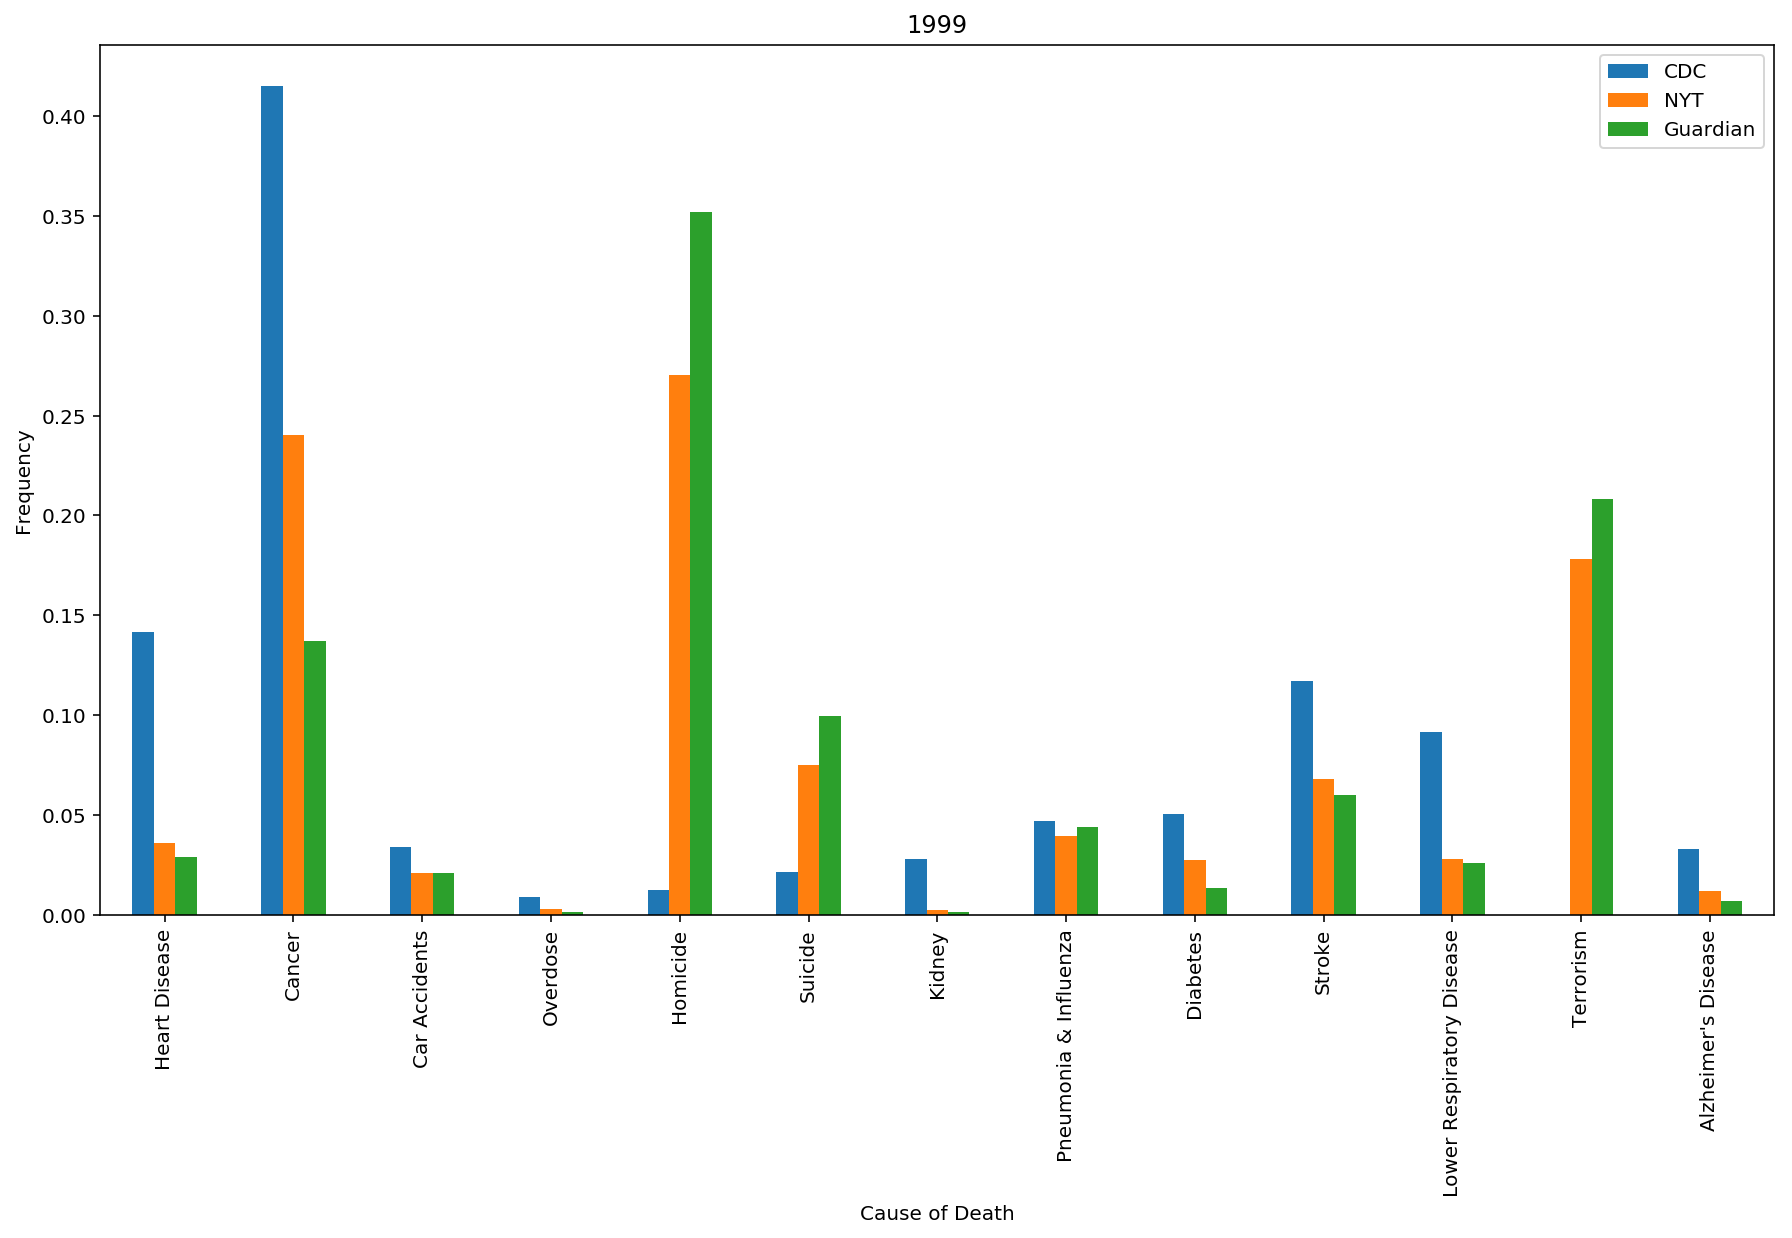

In [34]:
#Plot 1999
ax1999 = df_1999.plot(kind="bar", x="Cause of Death")
ax1999.set_ylabel("Frequency")
ax1999.set_title("1999")

Text(0.5,1,'2000')

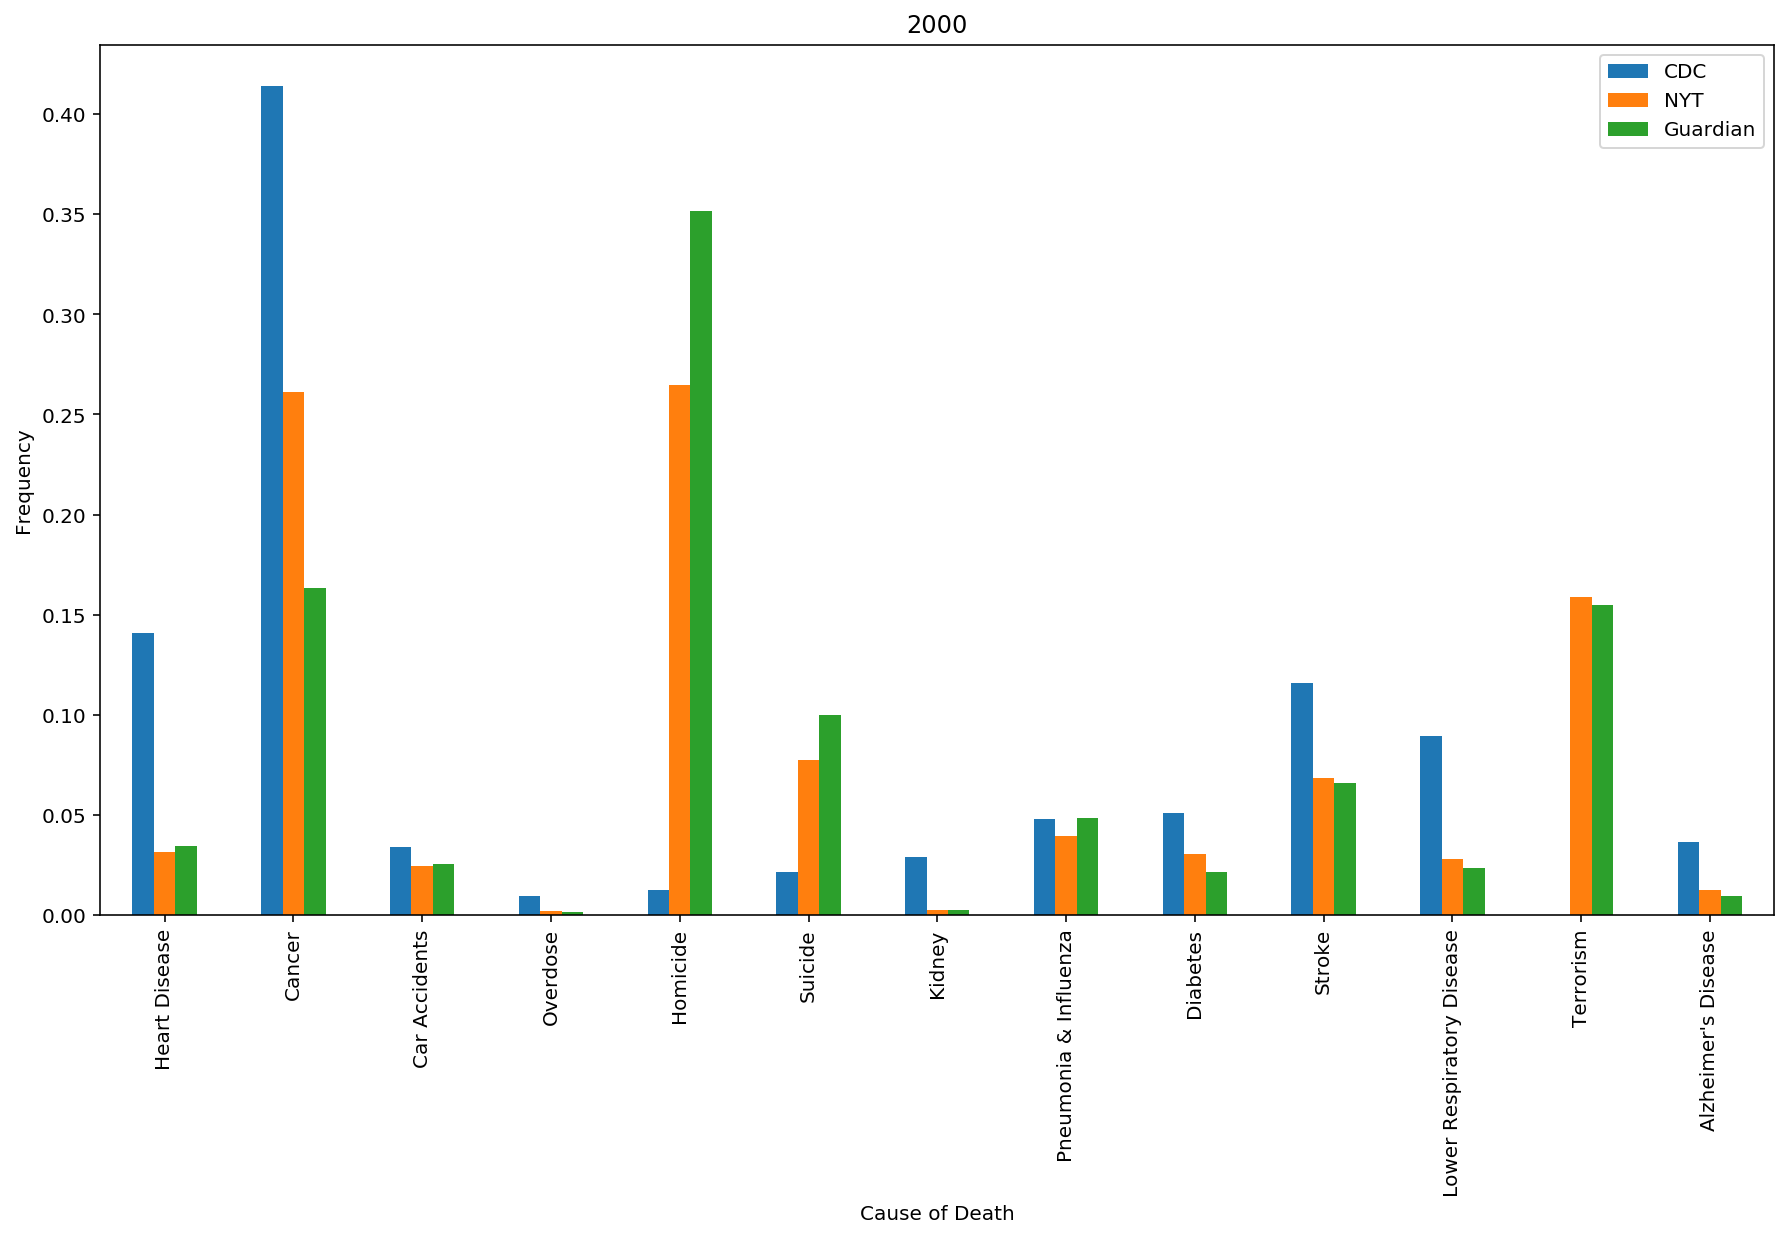

In [35]:
#Plot 2000
ax2000 = df_2000.plot(kind="bar", x="Cause of Death")
ax2000.set_ylabel("Frequency")
ax2000.set_title("2000")

Text(0.5,1,'2001')

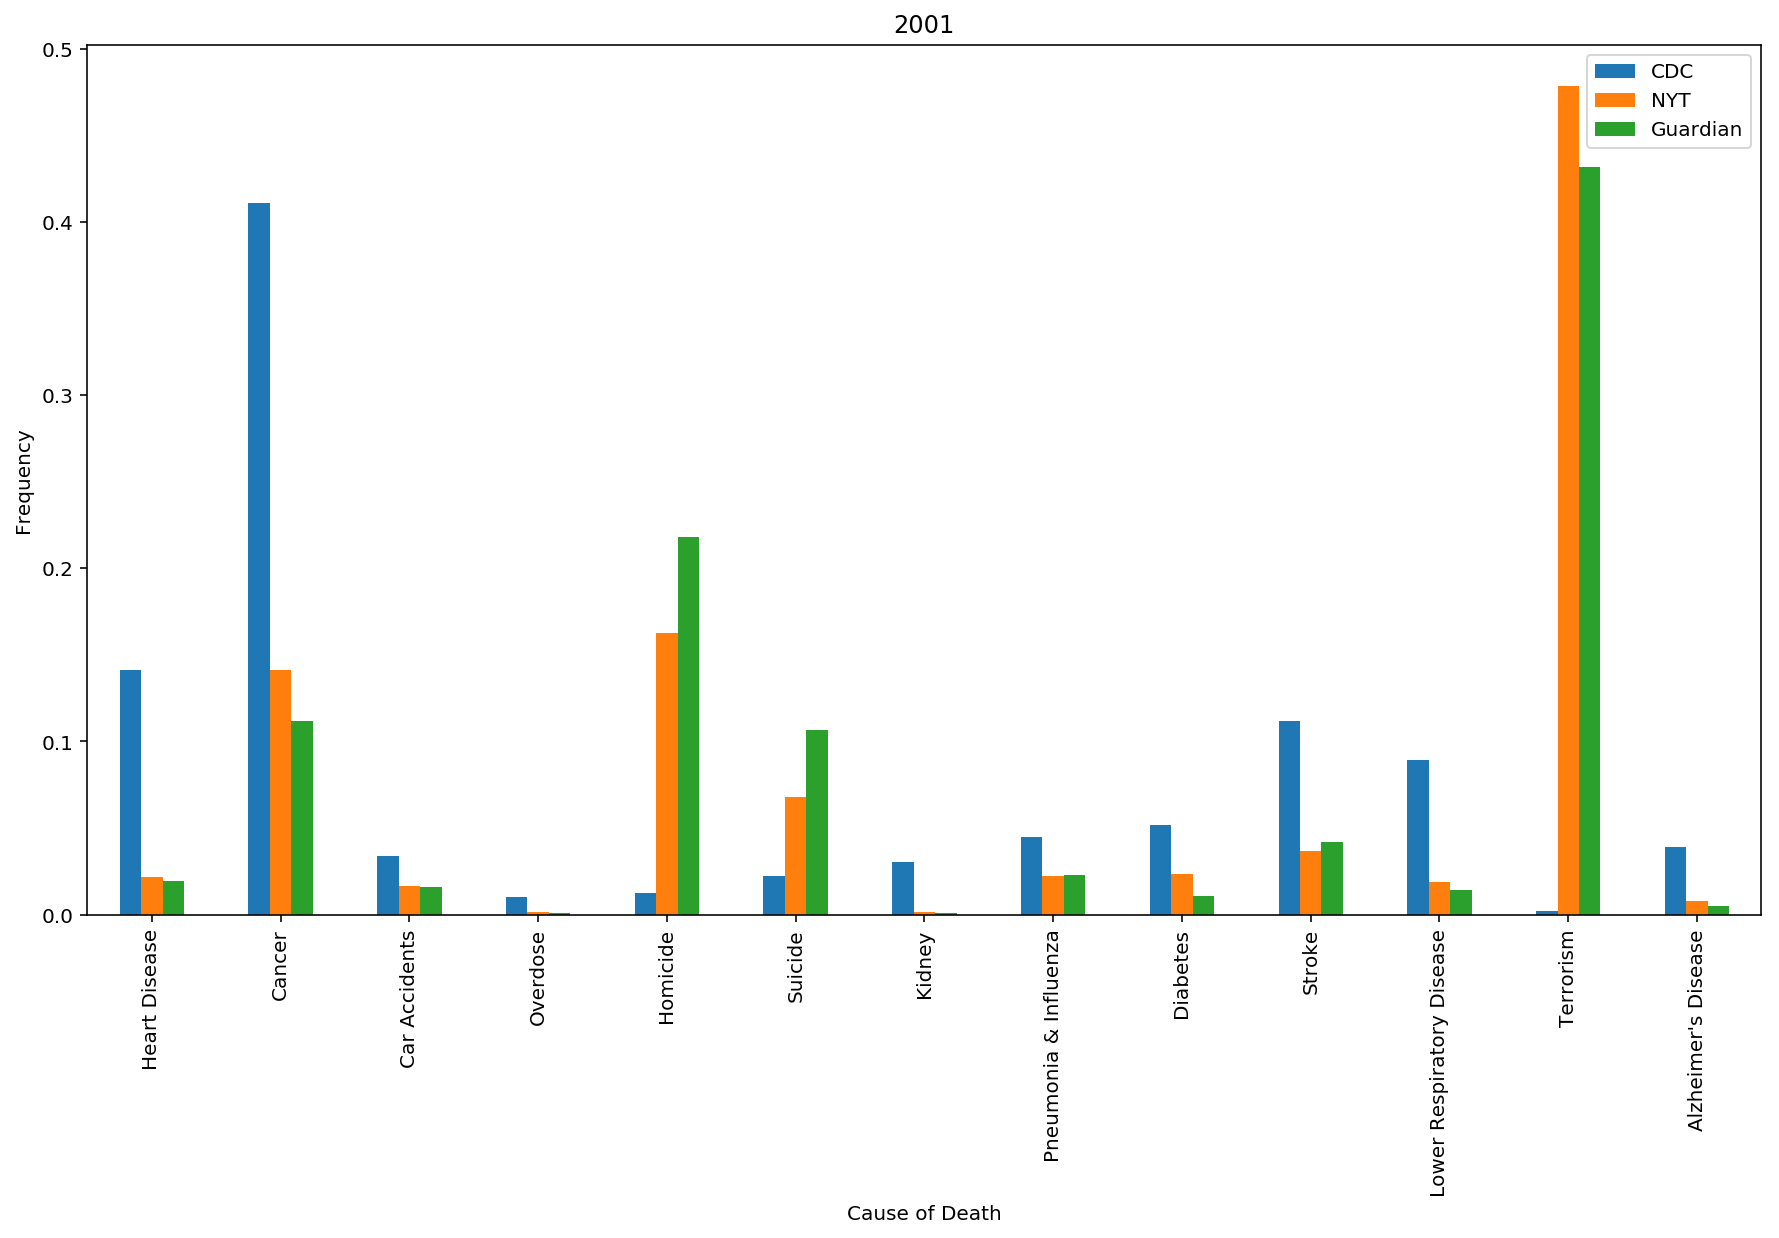

In [36]:
#Plot 2001
ax2001 = df_2001.plot(kind="bar", x="Cause of Death")
ax2001.set_ylabel("Frequency")
ax2001.set_title("2001")

Text(0.5,1,'2002')

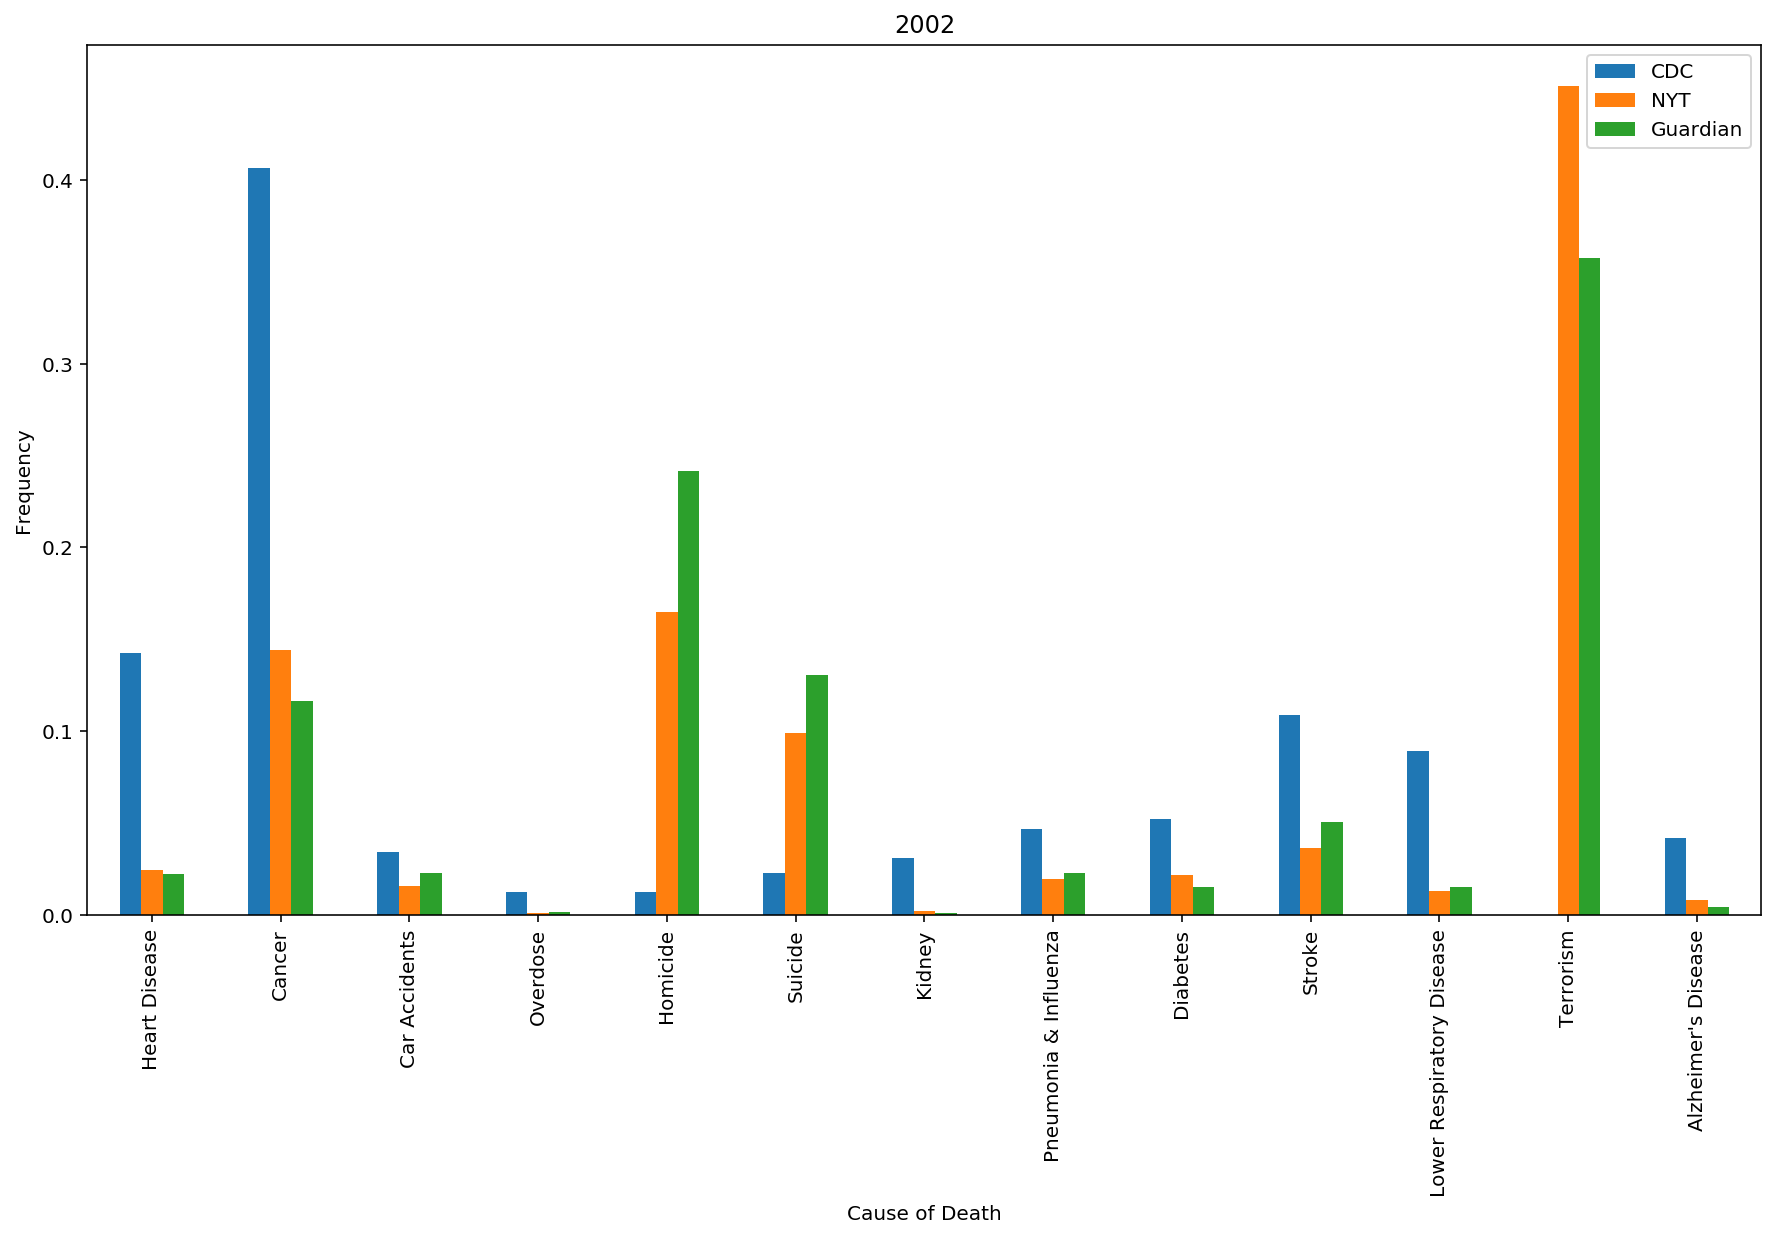

In [37]:
#Plot 2002
ax2002 = df_2002.plot(kind="bar", x="Cause of Death")
ax2002.set_ylabel("Frequency")
ax2002.set_title("2002")

Text(0.5,1,'2003')

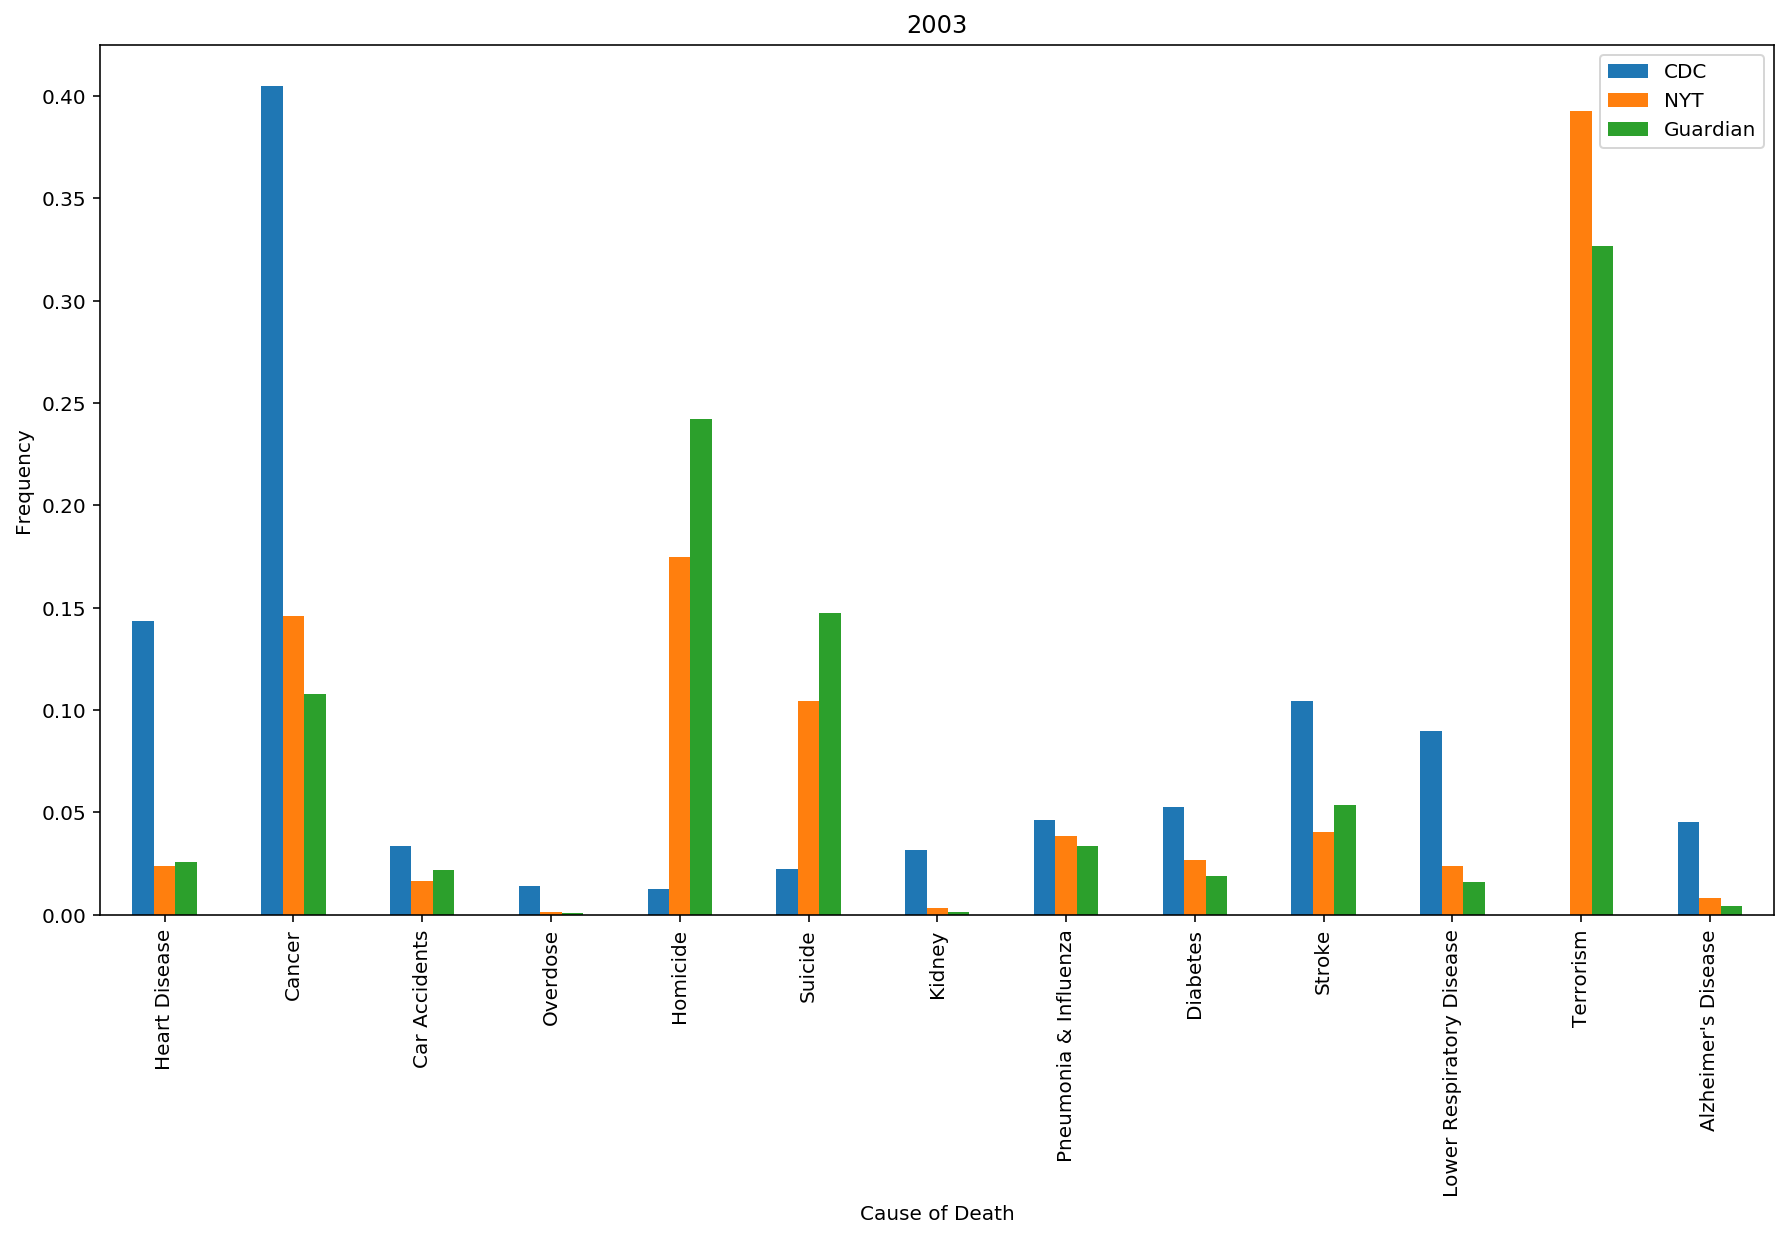

In [38]:
#Plot 2003
ax2003 = df_2003.plot(kind="bar", x="Cause of Death")
ax2003.set_ylabel("Frequency")
ax2003.set_title("2003")

Text(0.5,1,'2004')

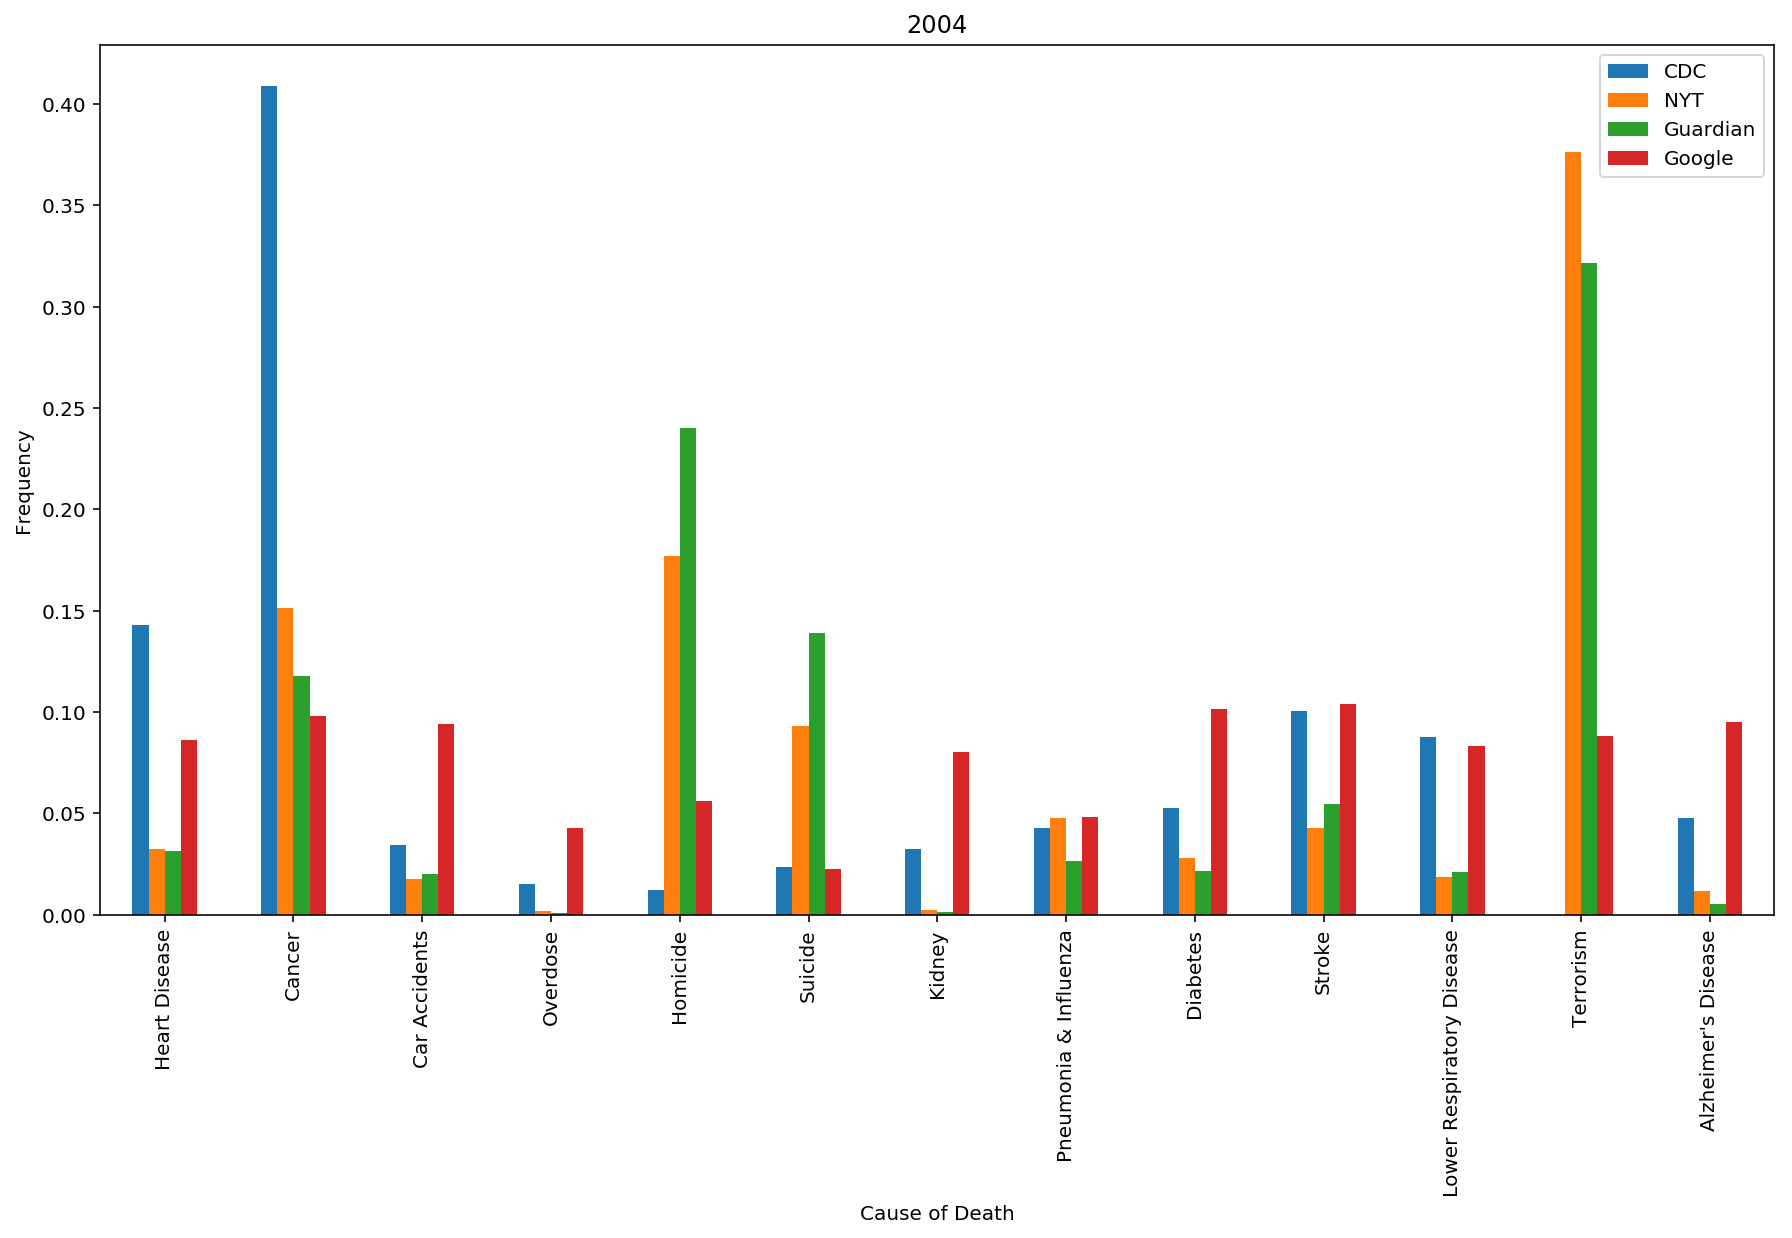

In [39]:
#Plot 2004
ax2004 = df_2004.plot(kind="bar", x="Cause of Death")
ax2004.set_ylabel("Frequency")
ax2004.set_title("2004")

Text(0.5,1,'2005')

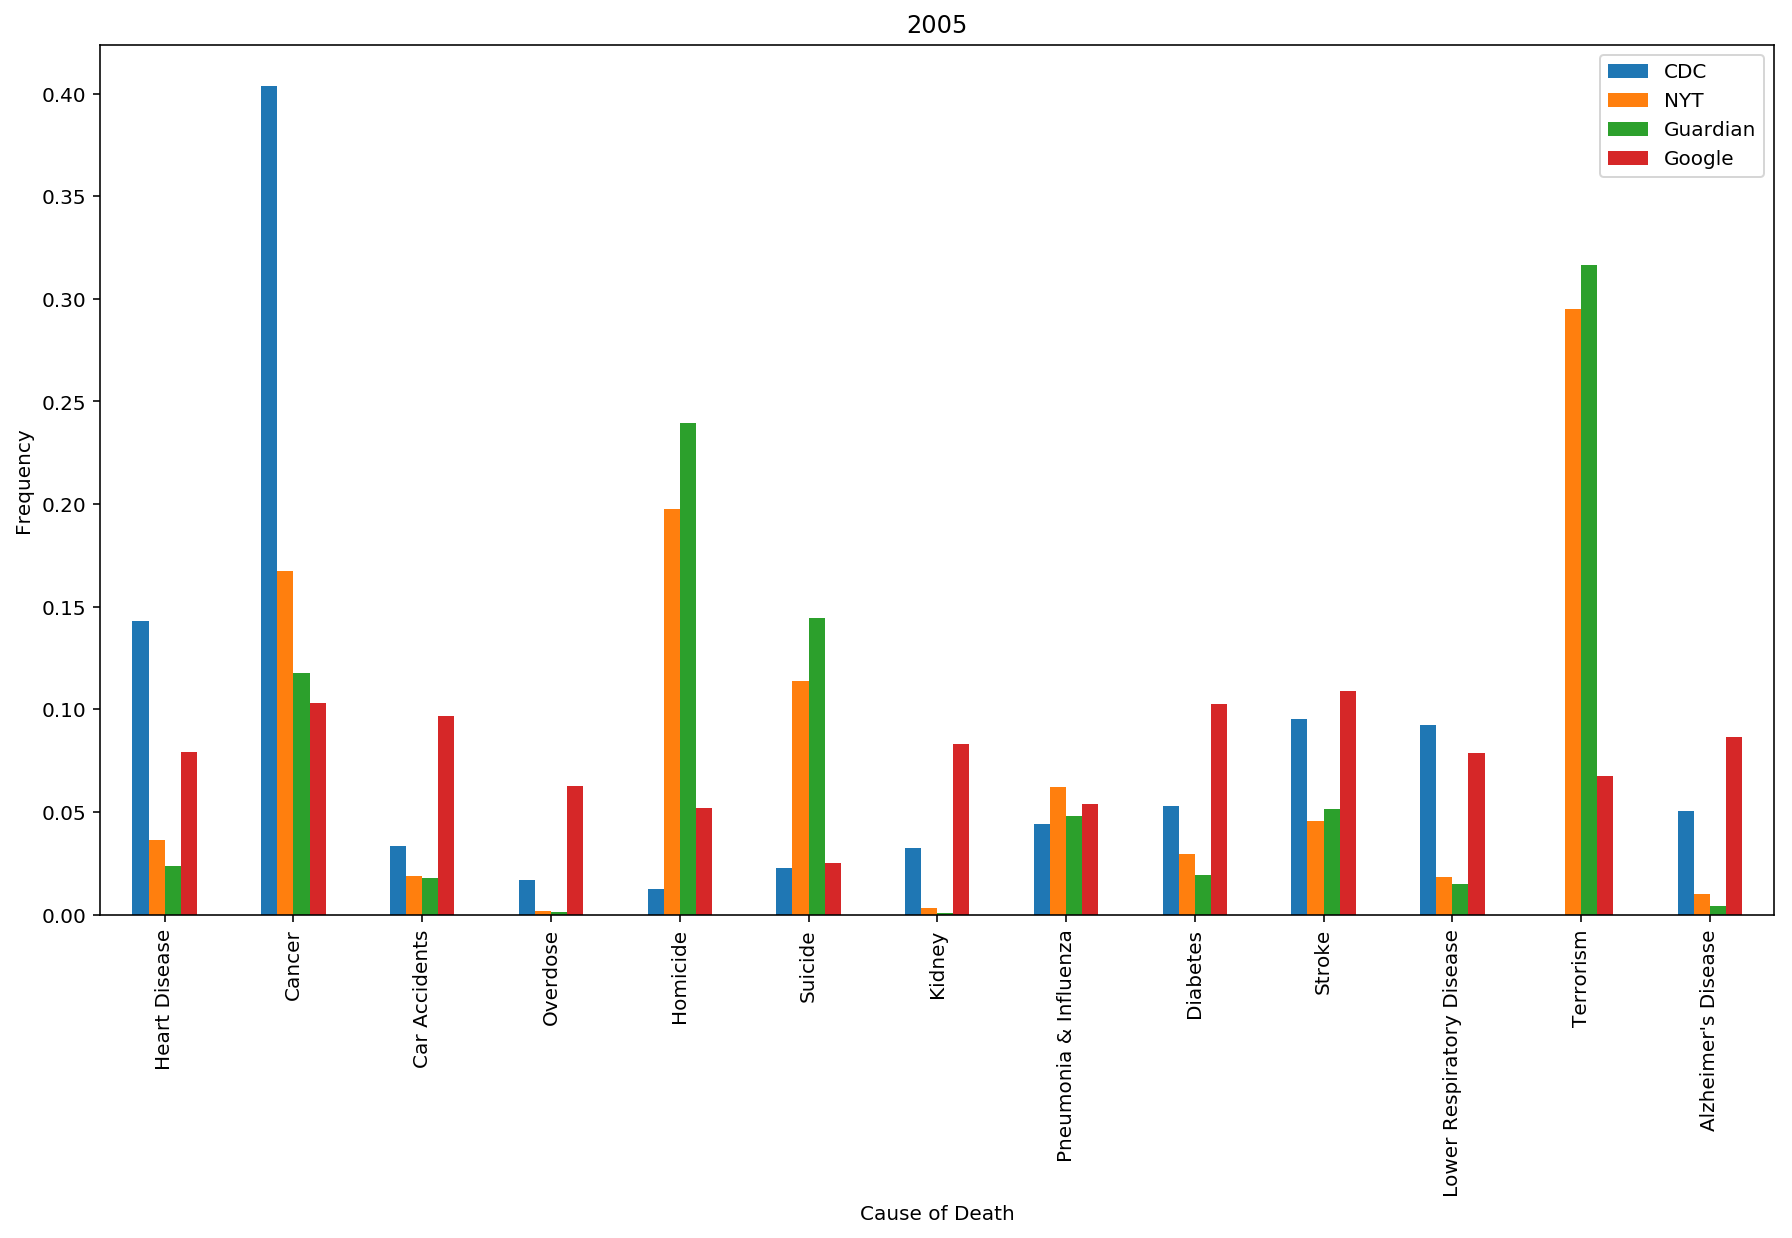

In [40]:
#Plot 2005
ax2005 = df_2005.plot(kind="bar", x="Cause of Death")
ax2005.set_ylabel("Frequency")
ax2005.set_title("2005")

Text(0.5,1,'2006')

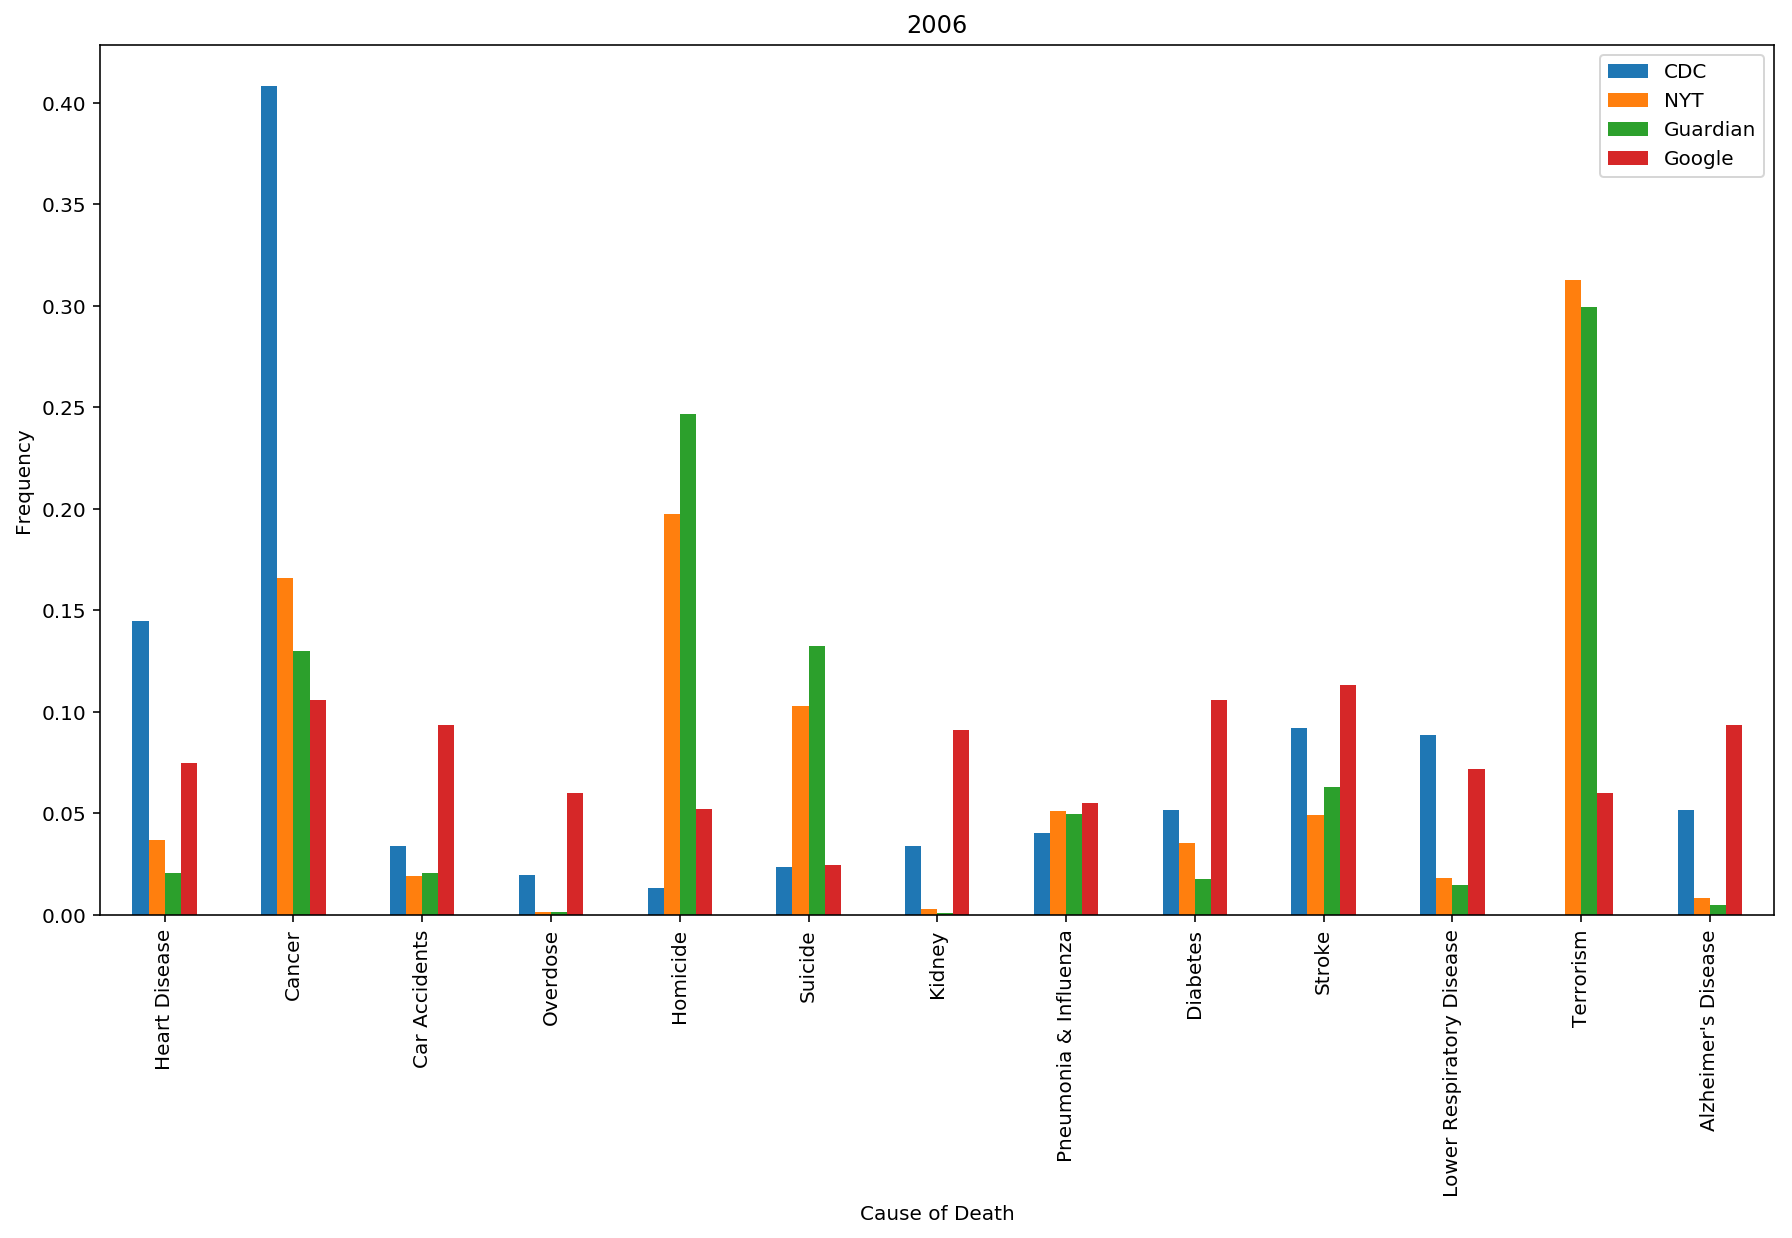

In [41]:
#Plot 2006
ax2006 = df_2006.plot(kind="bar", x="Cause of Death")
ax2006.set_ylabel("Frequency")
ax2006.set_title("2006")

Text(0.5,1,'2007')

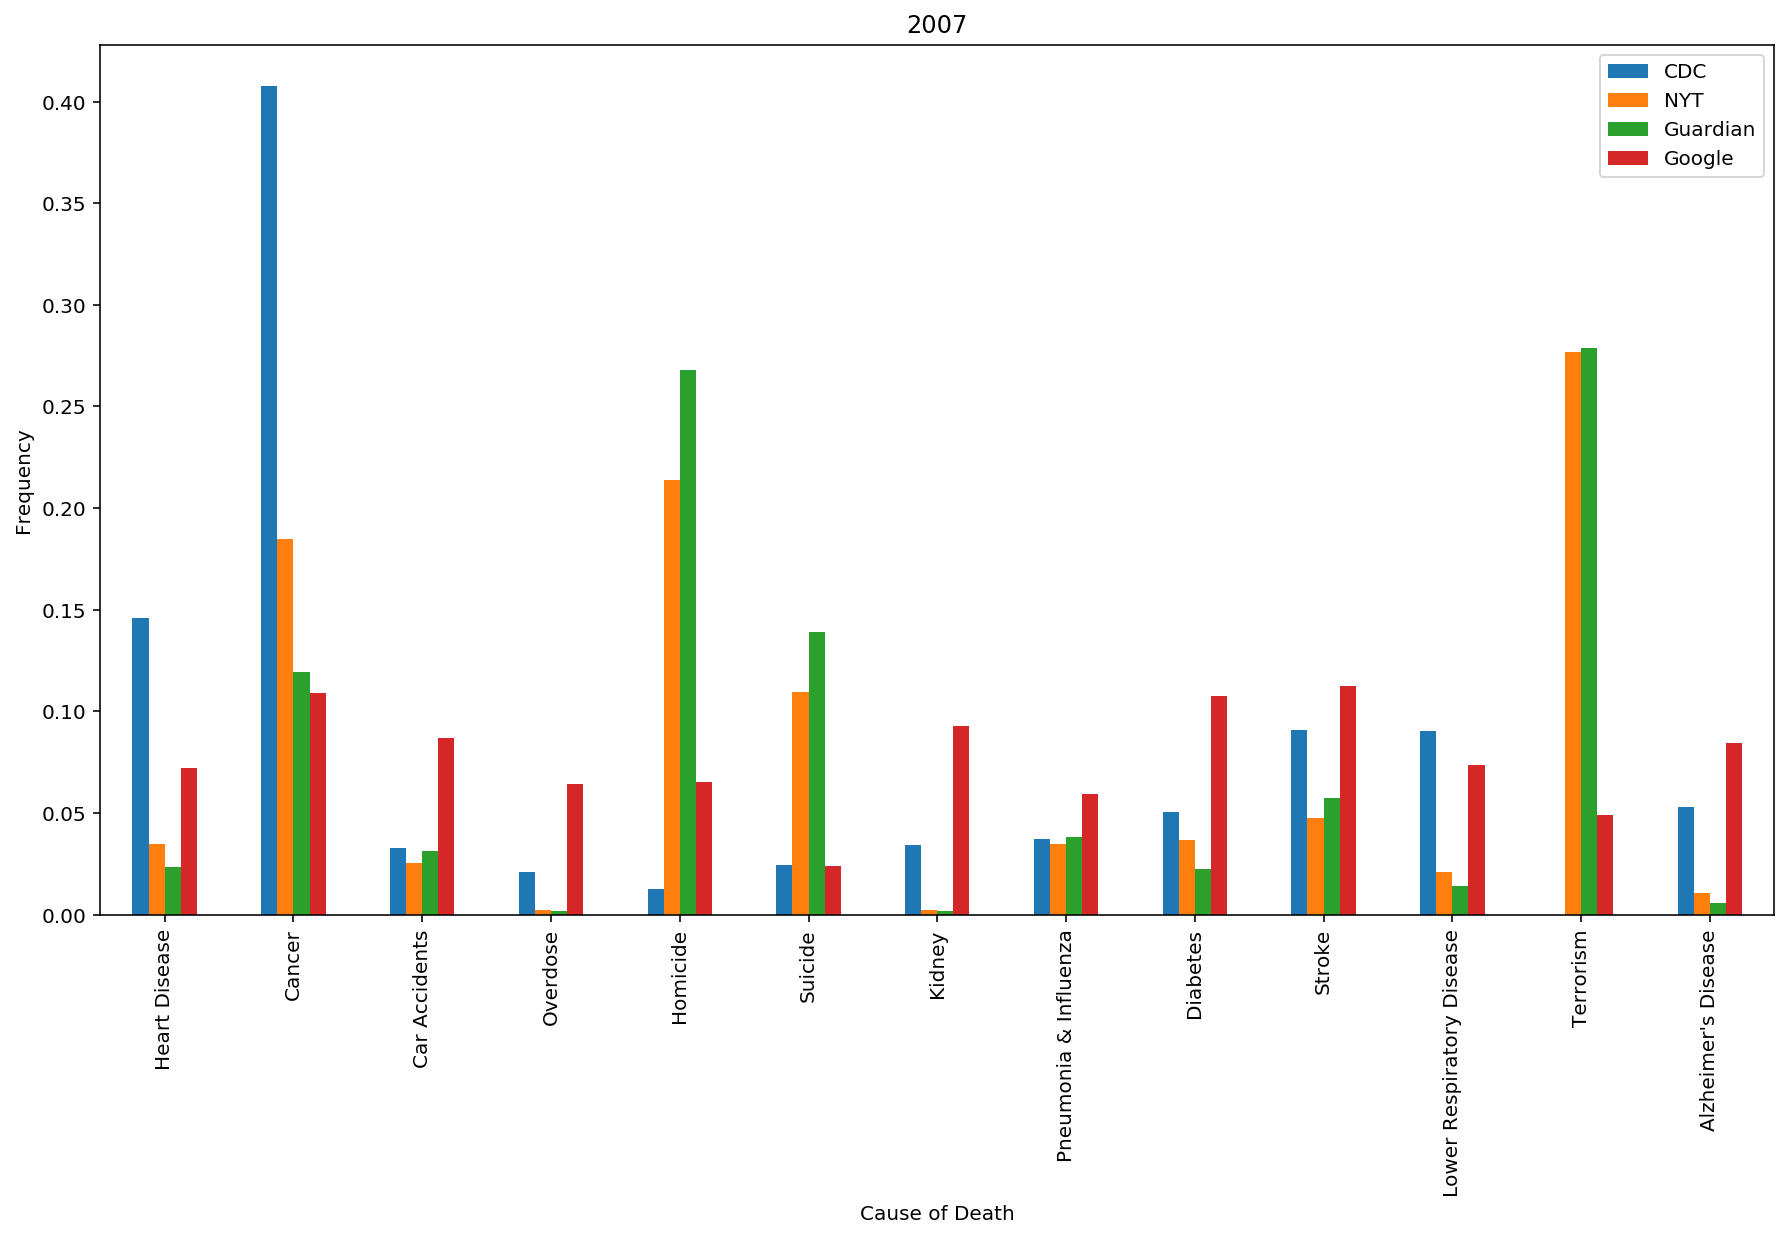

In [42]:
#Plot 2007
ax2007 = df_2007.plot(kind="bar", x="Cause of Death")
ax2007.set_ylabel("Frequency")
ax2007.set_title("2007")

Text(0.5,1,'2008')

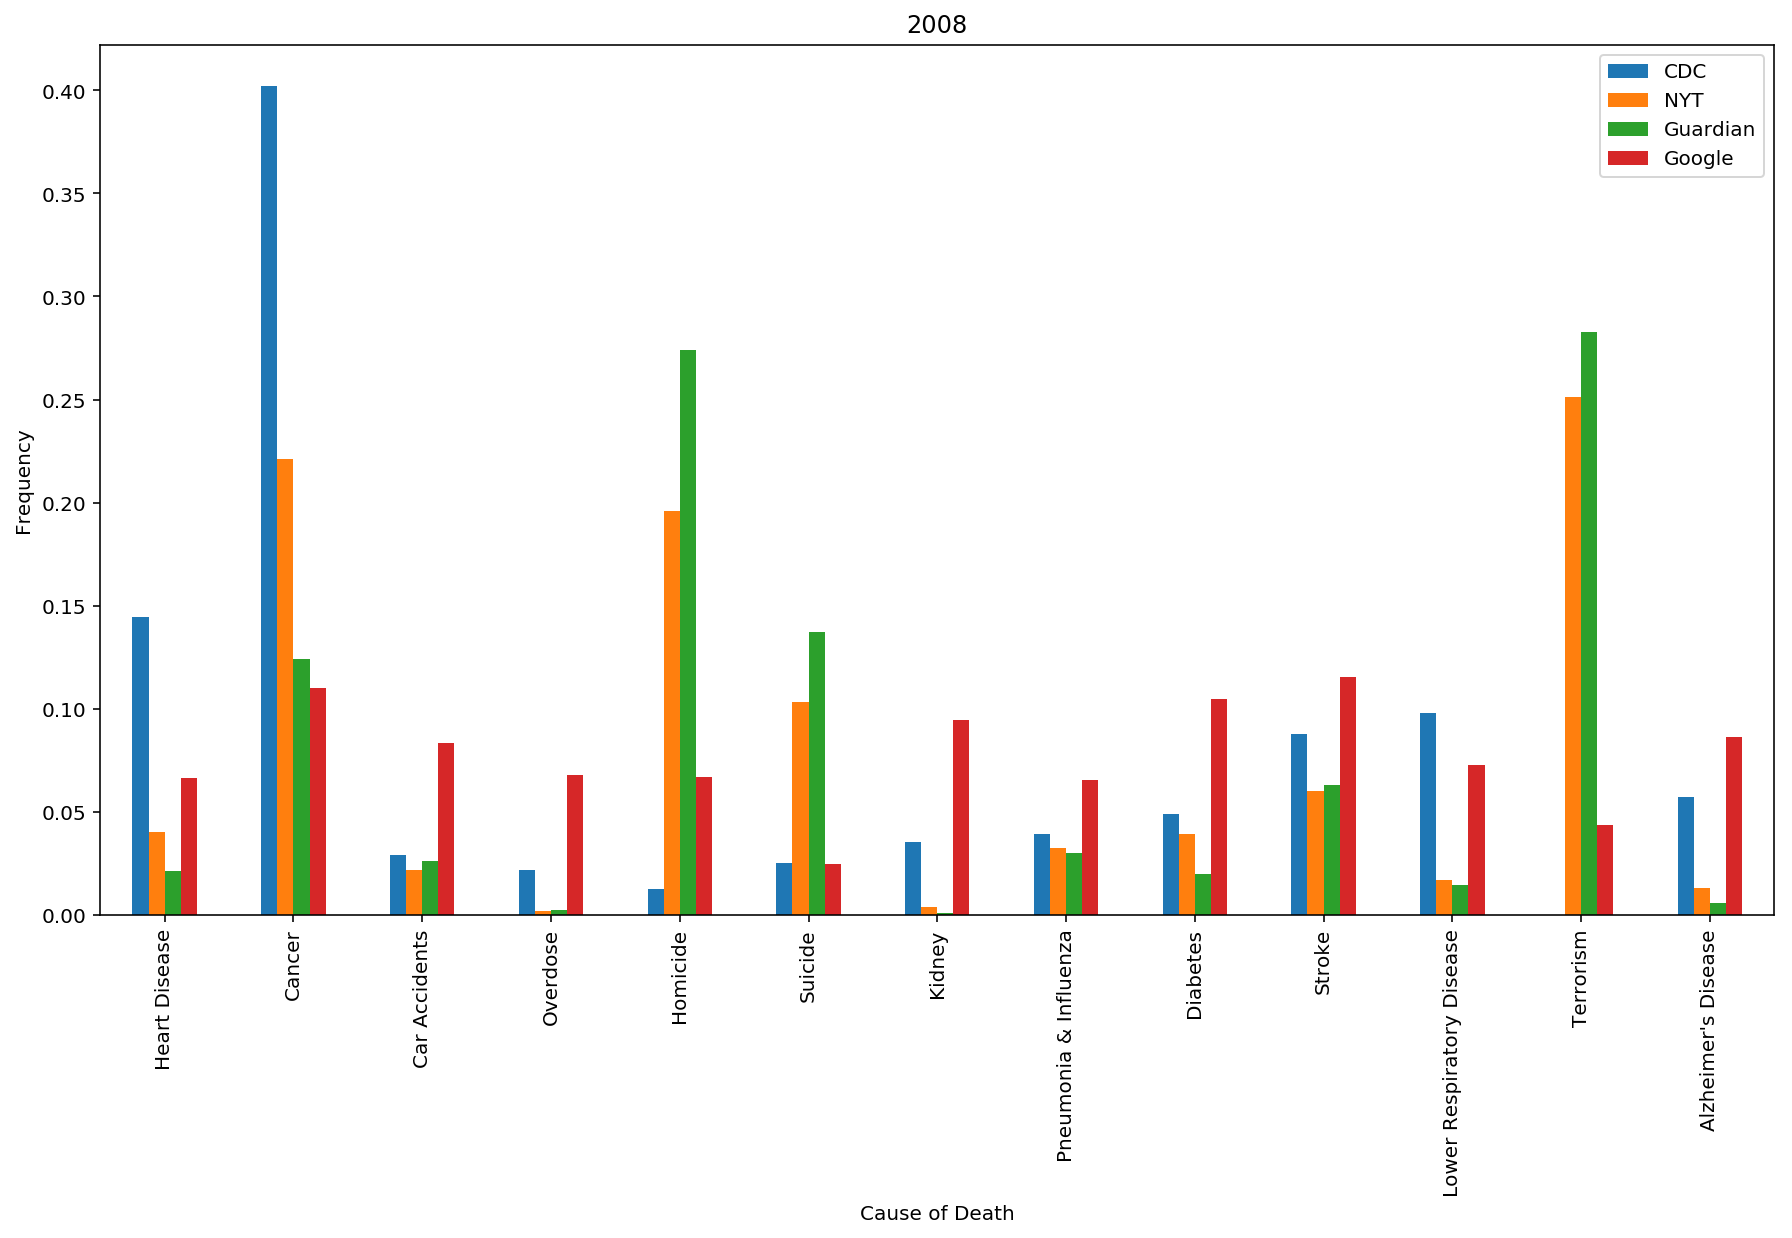

In [43]:
#Plot 2008
ax2008 = df_2008.plot(kind="bar", x="Cause of Death")
ax2008.set_ylabel("Frequency")
ax2008.set_title("2008")

Text(0.5,1,'2009')

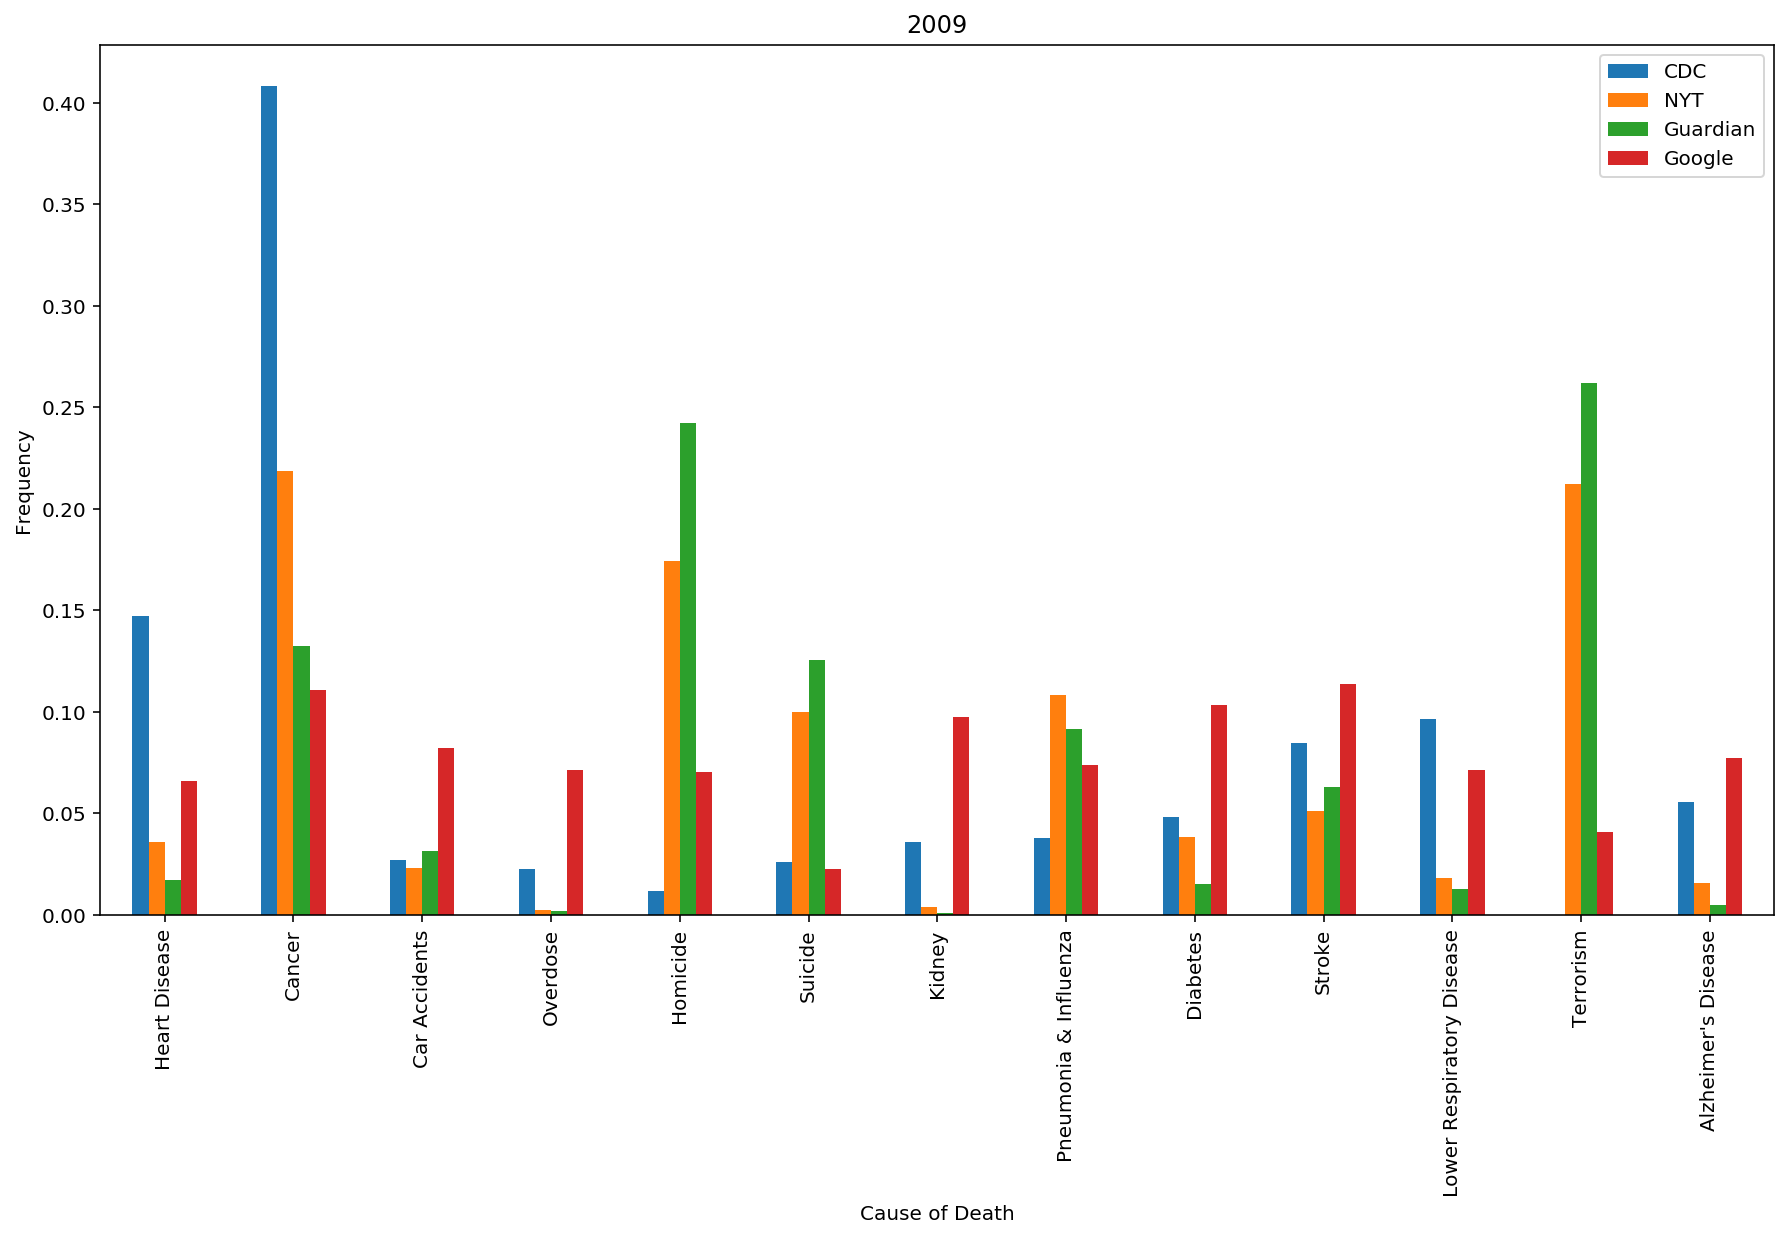

In [44]:
#Plot 2009
ax2009 = df_2009.plot(kind="bar", x="Cause of Death")
ax2009.set_ylabel("Frequency")
ax2009.set_title("2009")

Text(0.5,1,'2010')

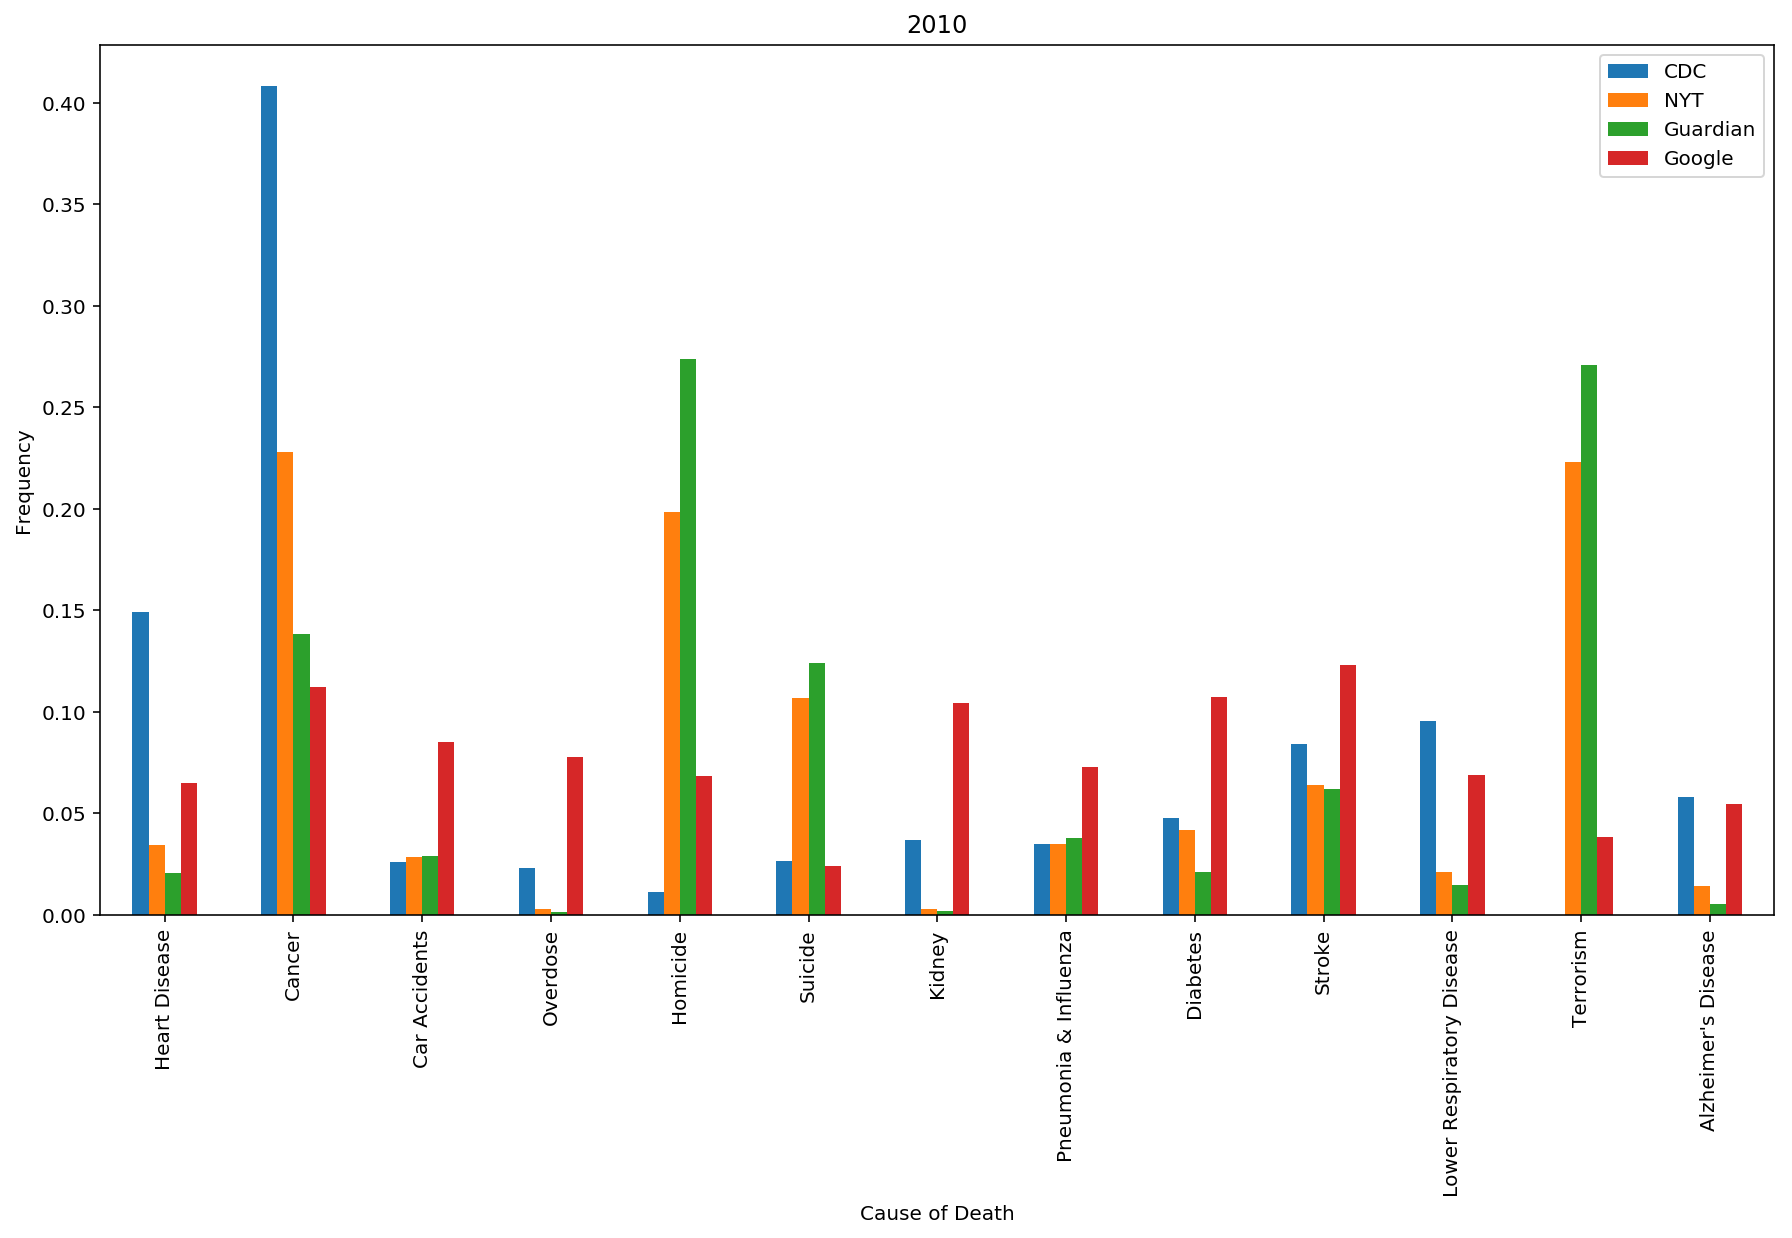

In [45]:
#Plot 2010
ax2010 = df_2010.plot(kind="bar", x="Cause of Death")
ax2010.set_ylabel("Frequency")
ax2010.set_title("2010")

Text(0.5,1,'2011')

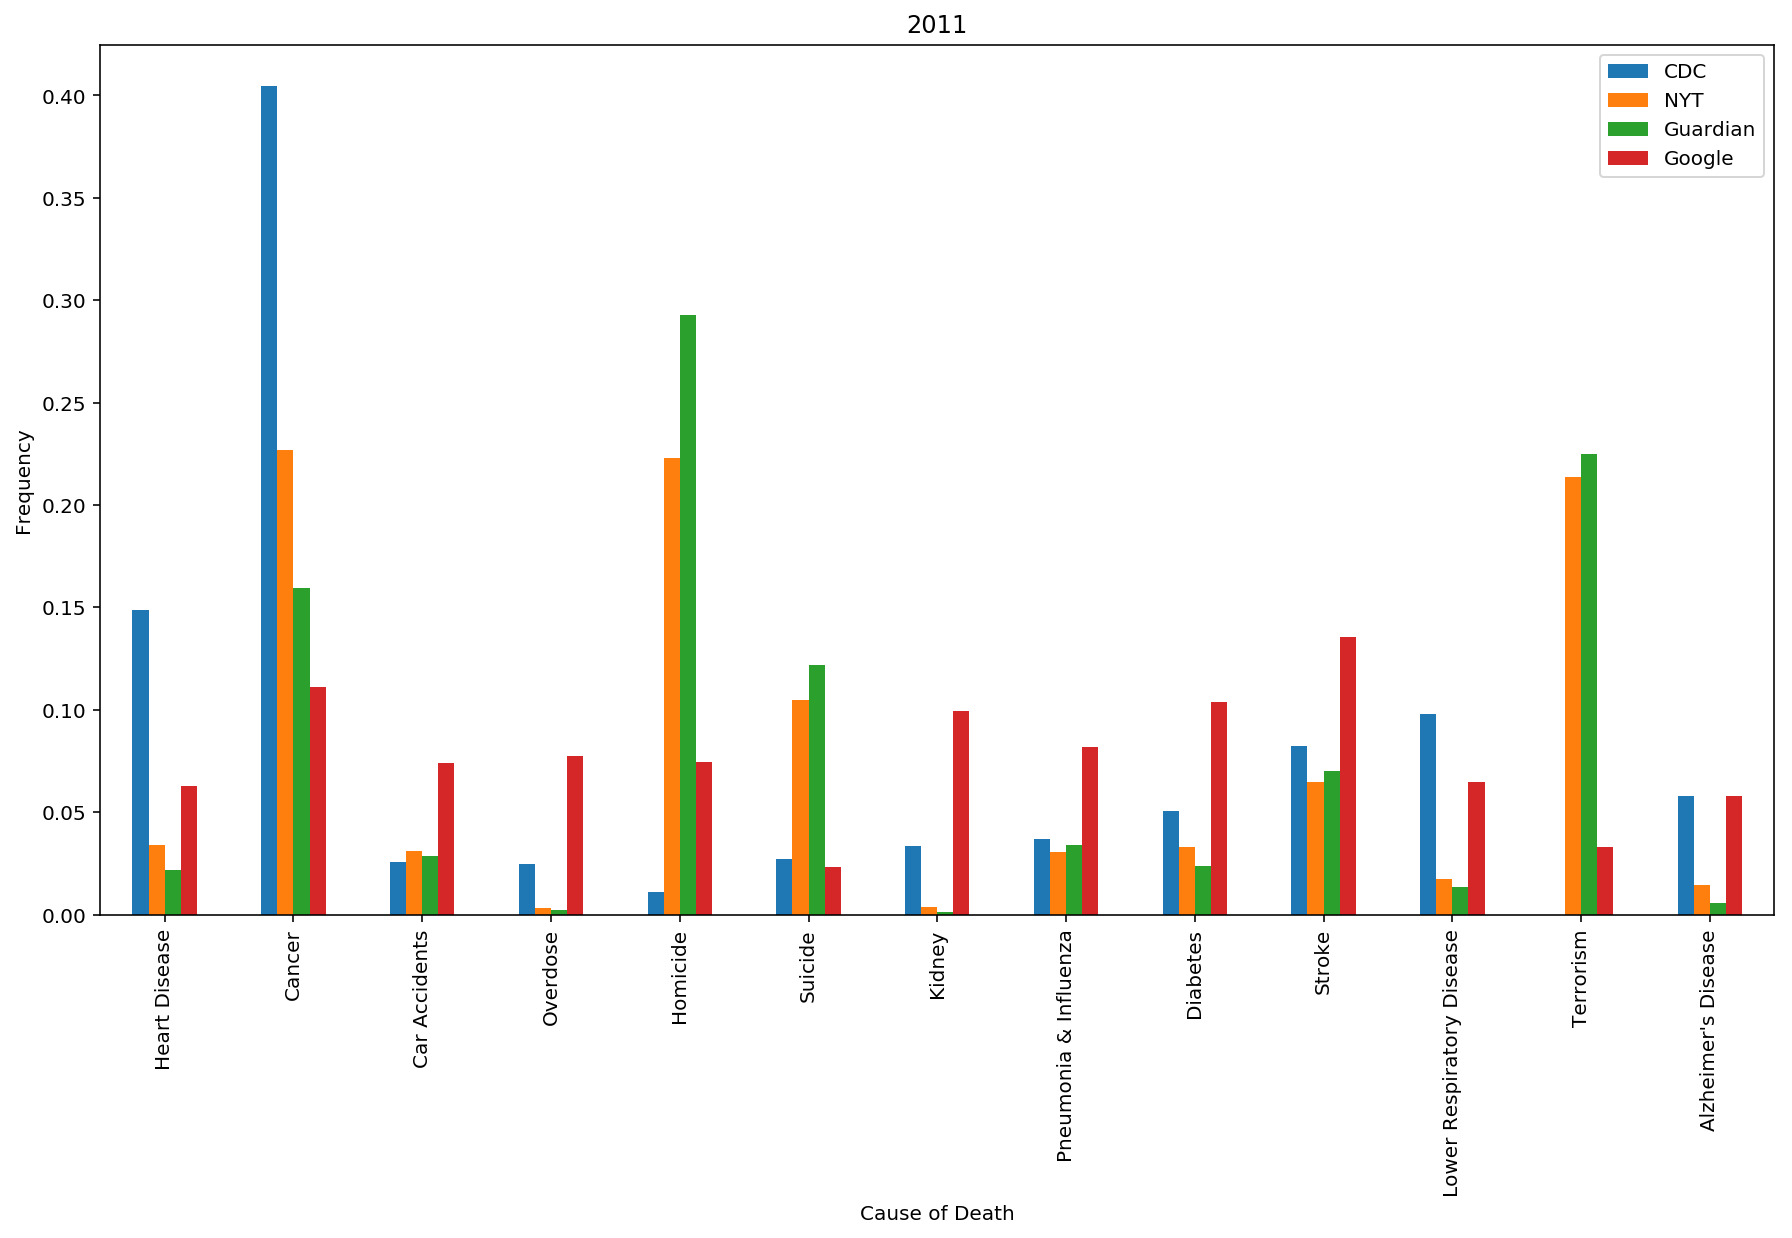

In [46]:
#Plot 2011
ax2011 = df_2011.plot(kind="bar", x="Cause of Death")
ax2011.set_ylabel("Frequency")
ax2011.set_title("2011")

Text(0.5,1,'2012')

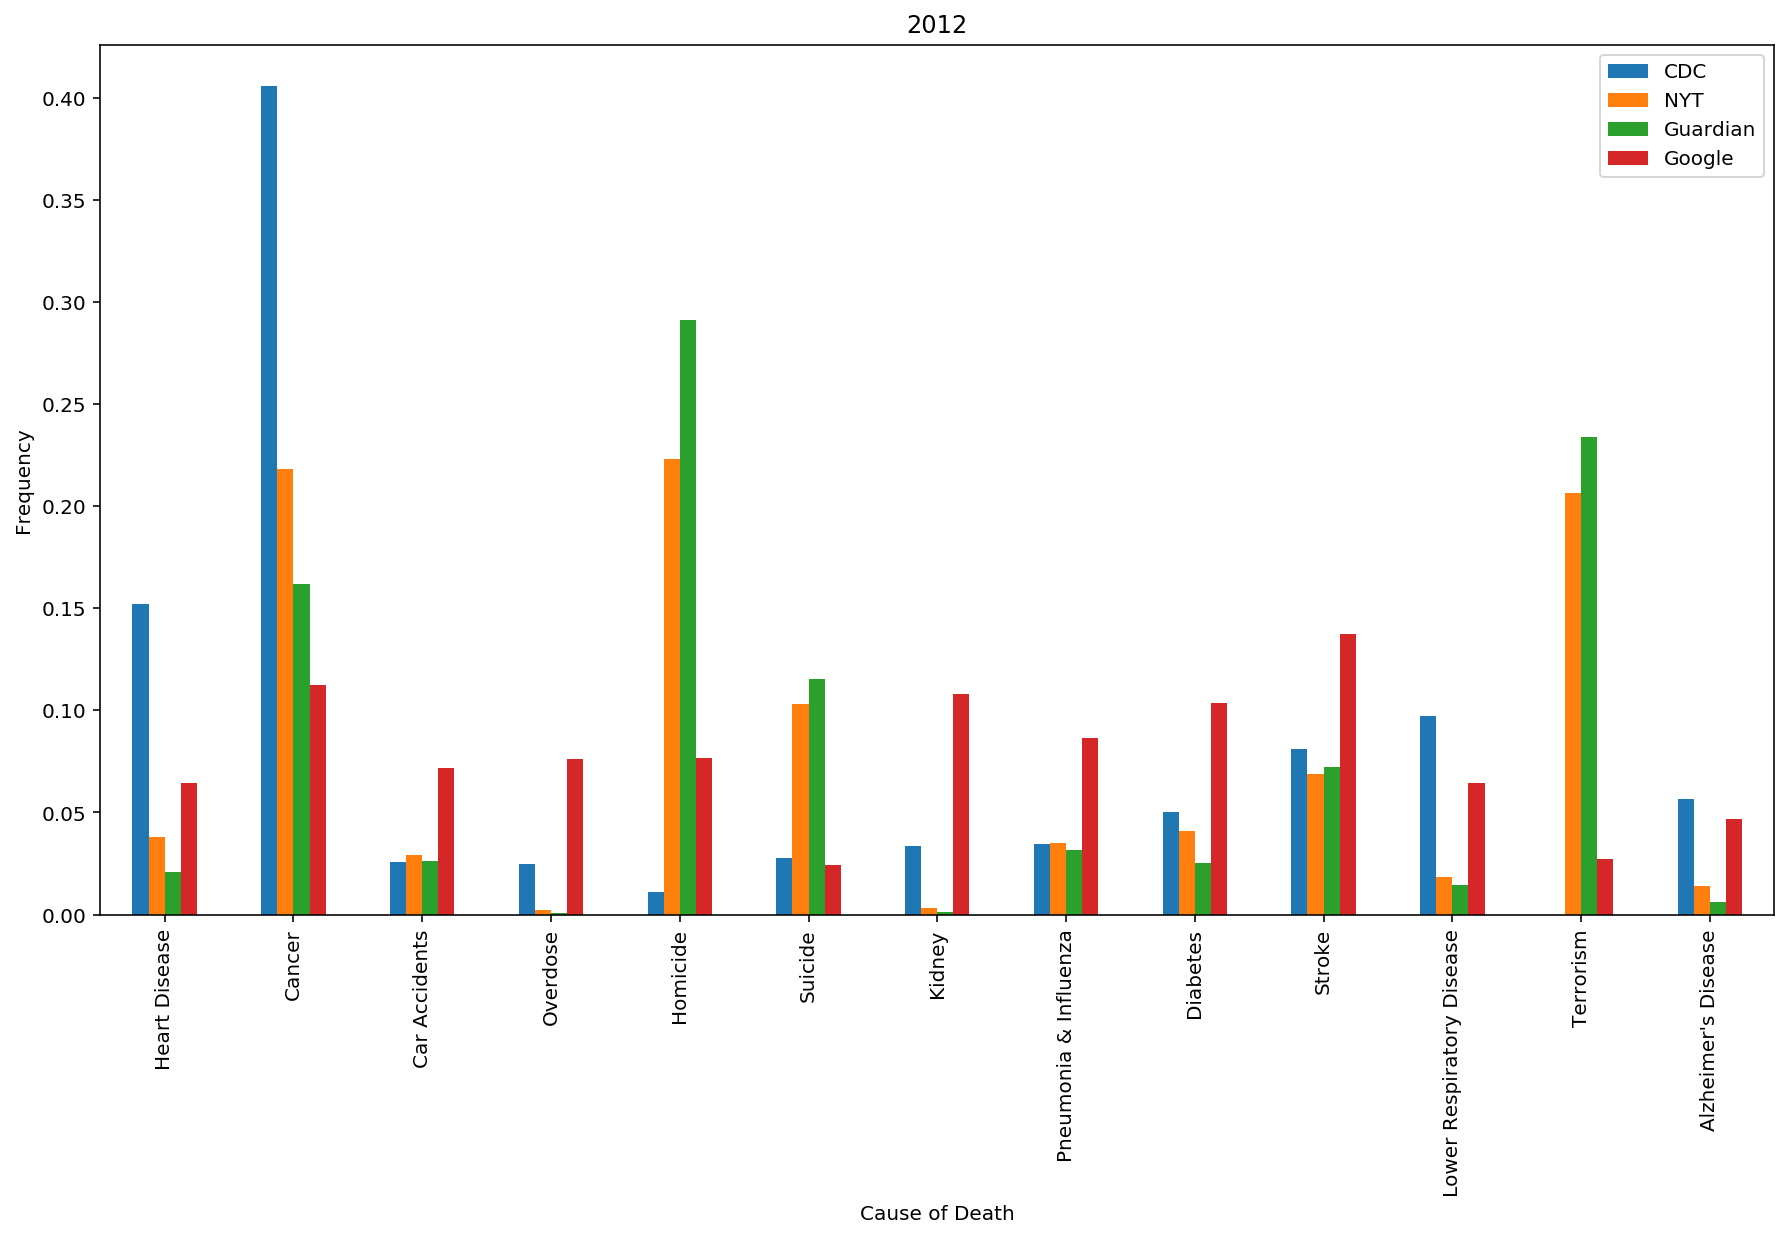

In [47]:
#Plot 2012
ax2012 = df_2012.plot(kind="bar", x="Cause of Death")
ax2012.set_ylabel("Frequency")
ax2012.set_title("2012")

Text(0.5,1,'2013')

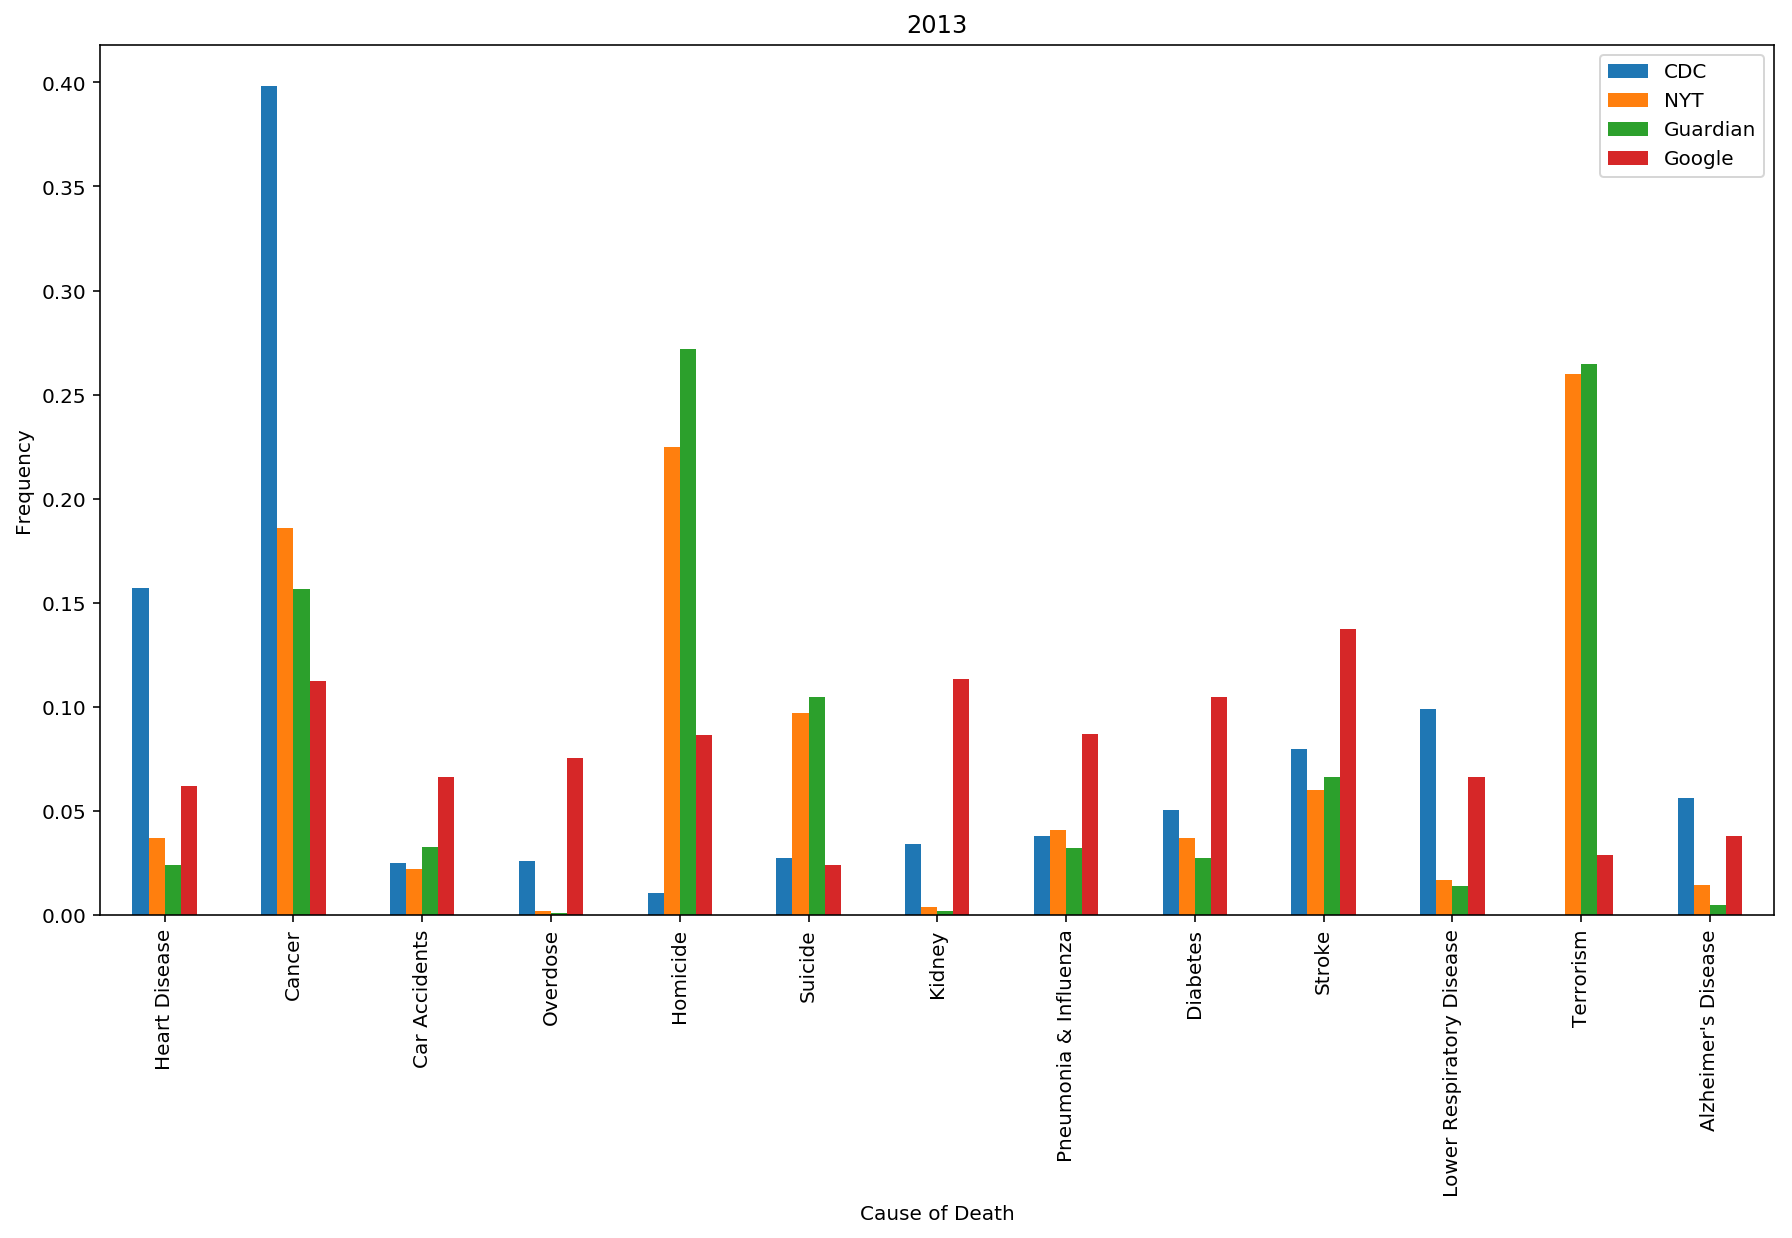

In [48]:
#Plot 2013
ax2013 = df_2013.plot(kind="bar", x="Cause of Death")
ax2013.set_ylabel("Frequency")
ax2013.set_title("2013")

Text(0.5,1,'2014')

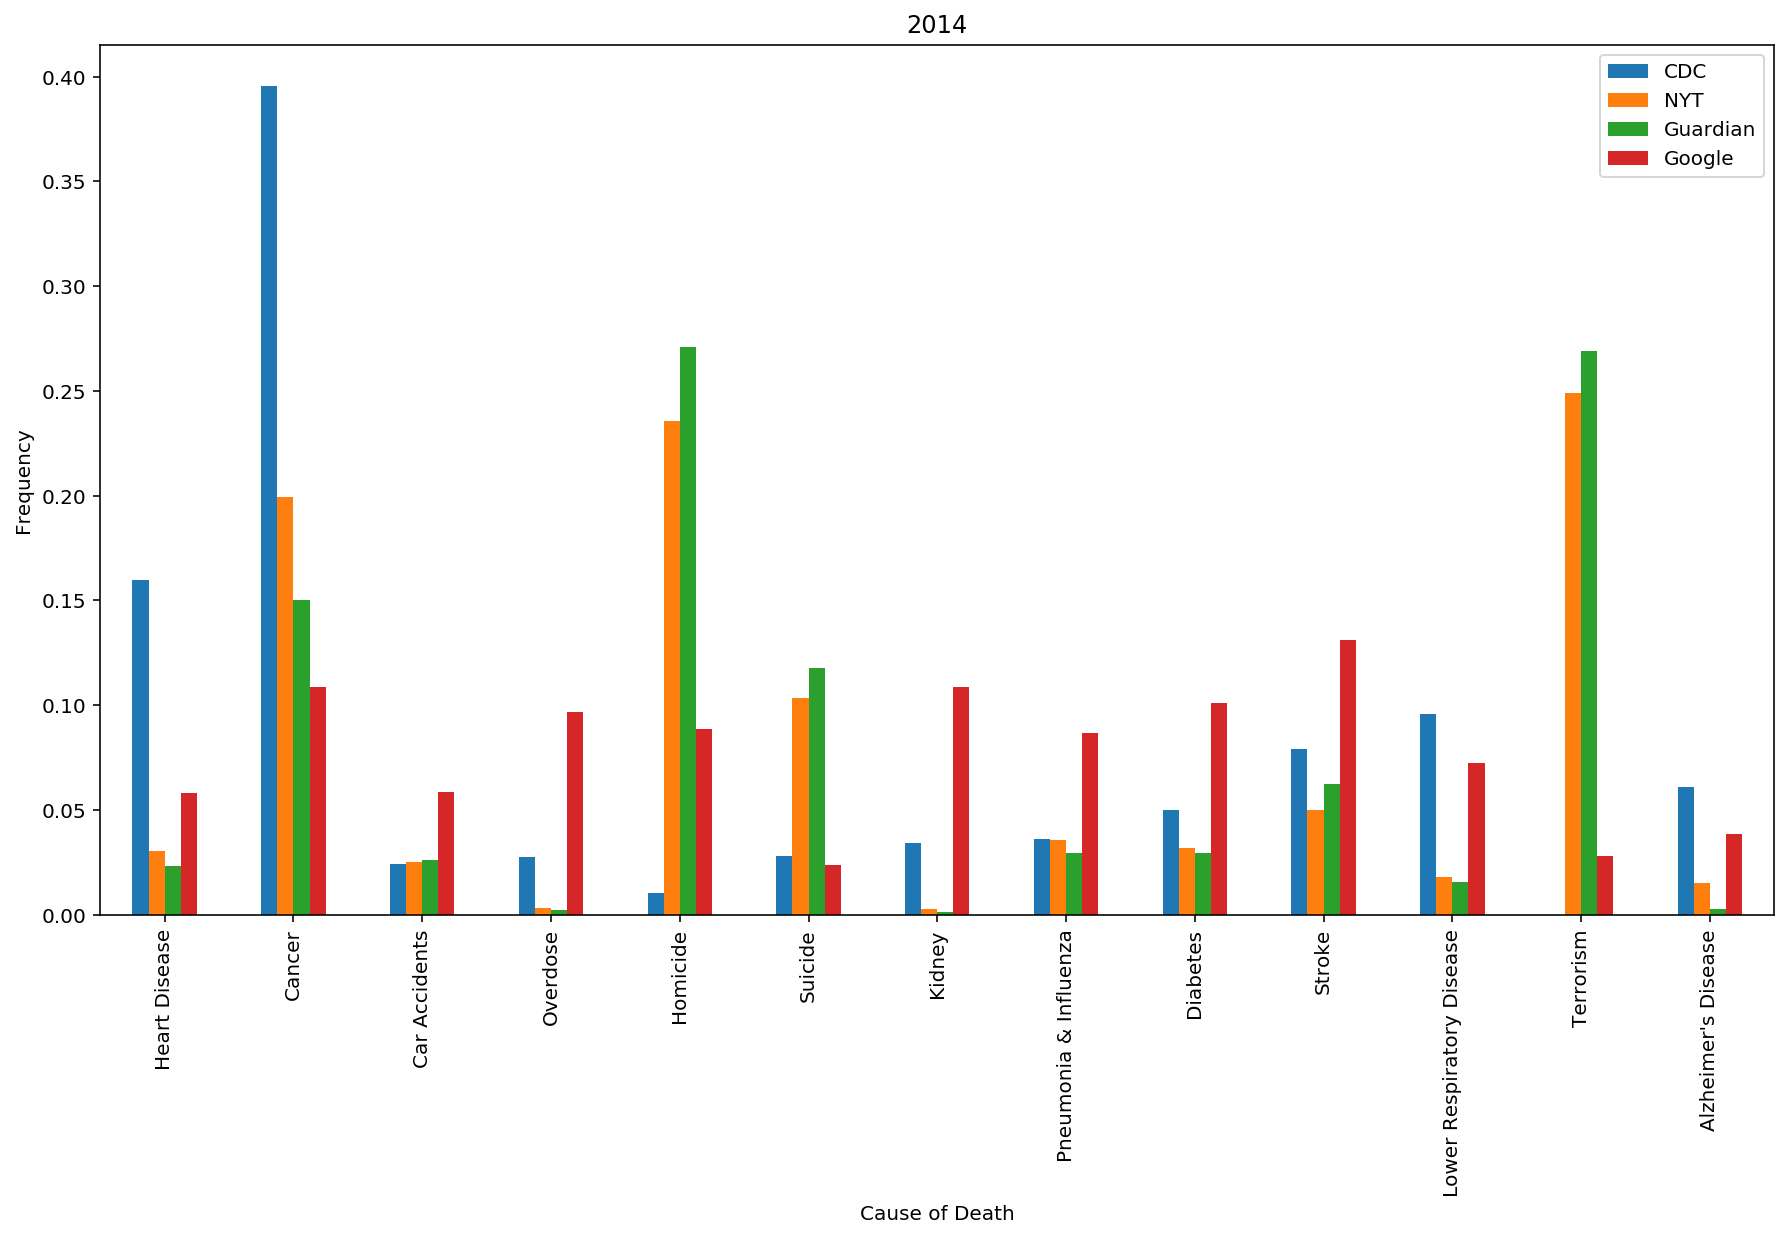

In [49]:
#Plot 2014
ax2014 = df_2014.plot(kind="bar", x="Cause of Death")
ax2014.set_ylabel("Frequency")
ax2014.set_title("2014")

Text(0.5,1,'2015')

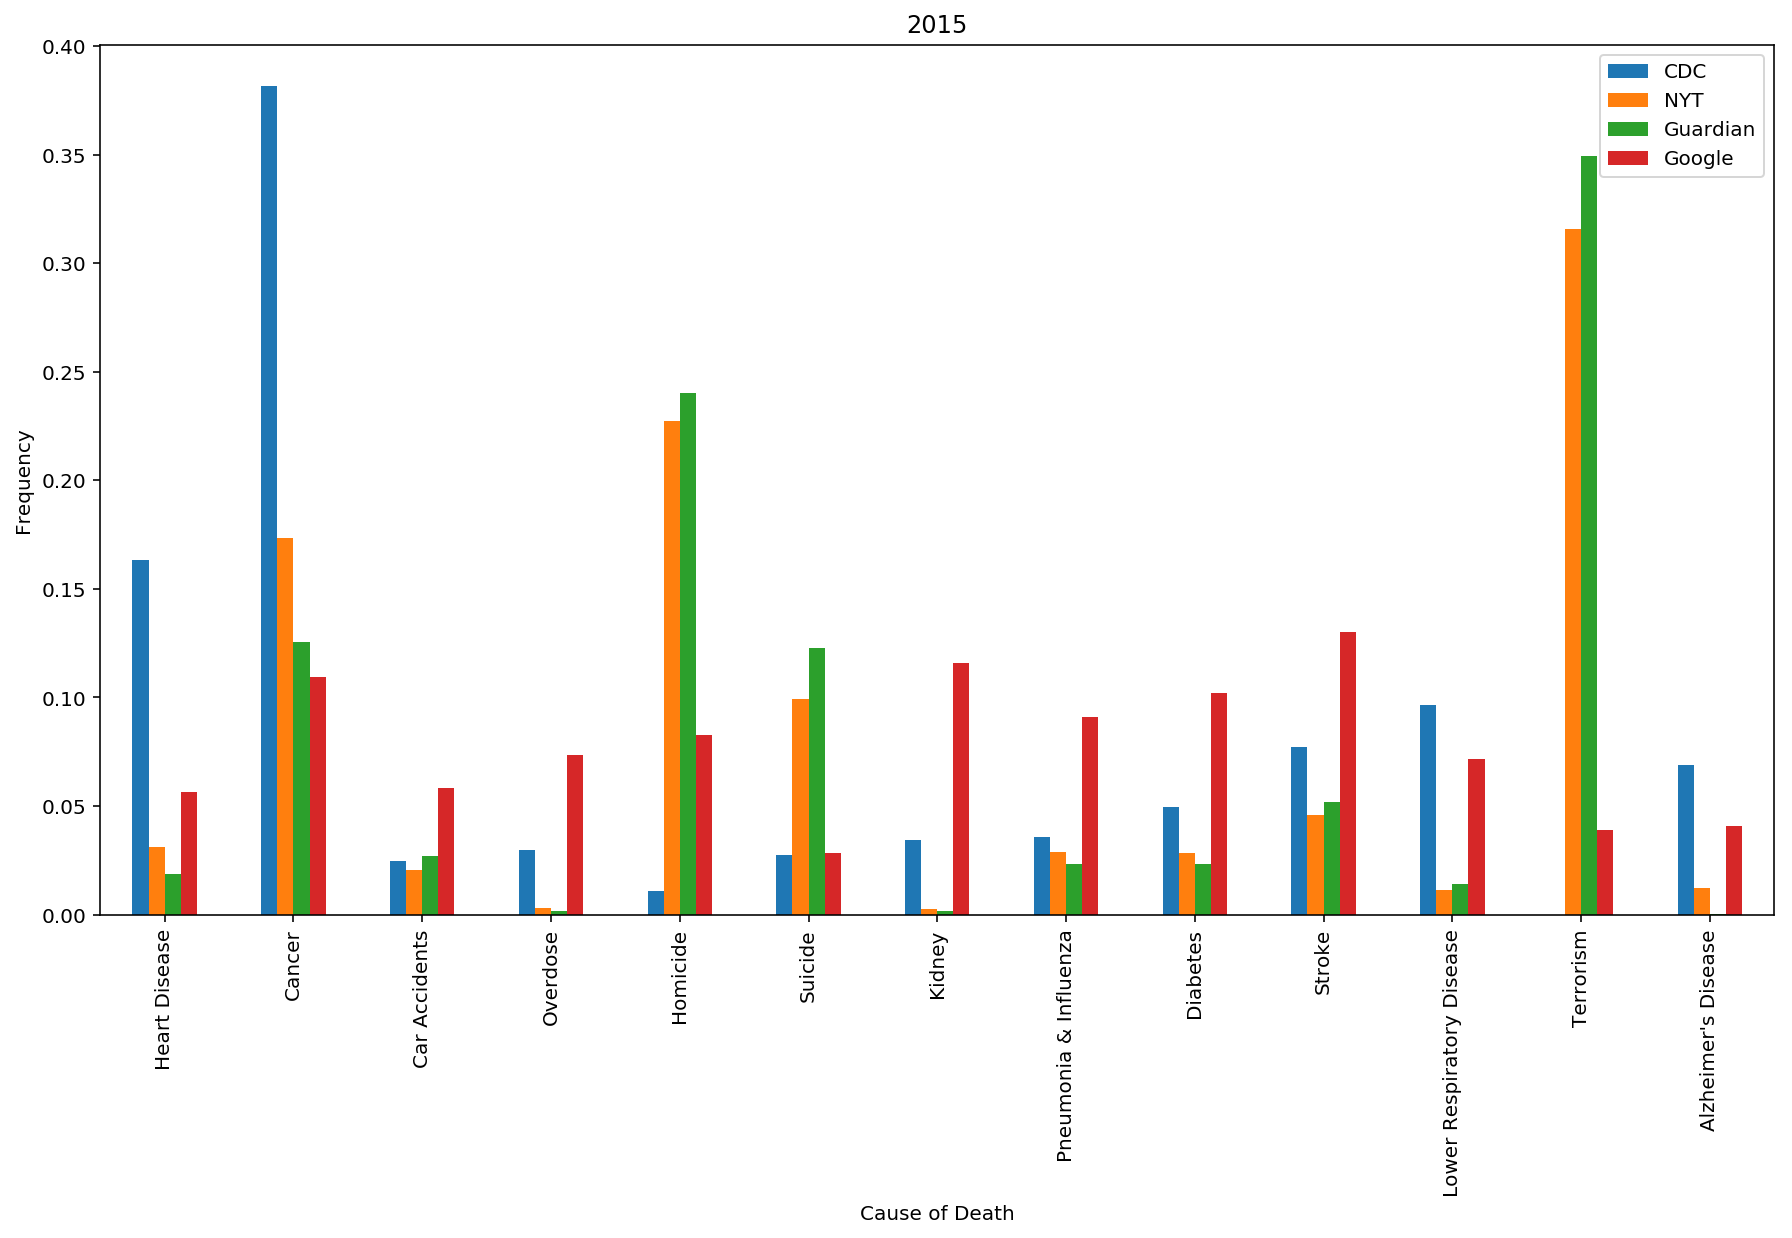

In [50]:
#Plot 2015
ax2015 = df_2015.plot(kind="bar", x="Cause of Death")
ax2015.set_ylabel("Frequency")
ax2015.set_title("2015")

Text(0.5,1,'2016')

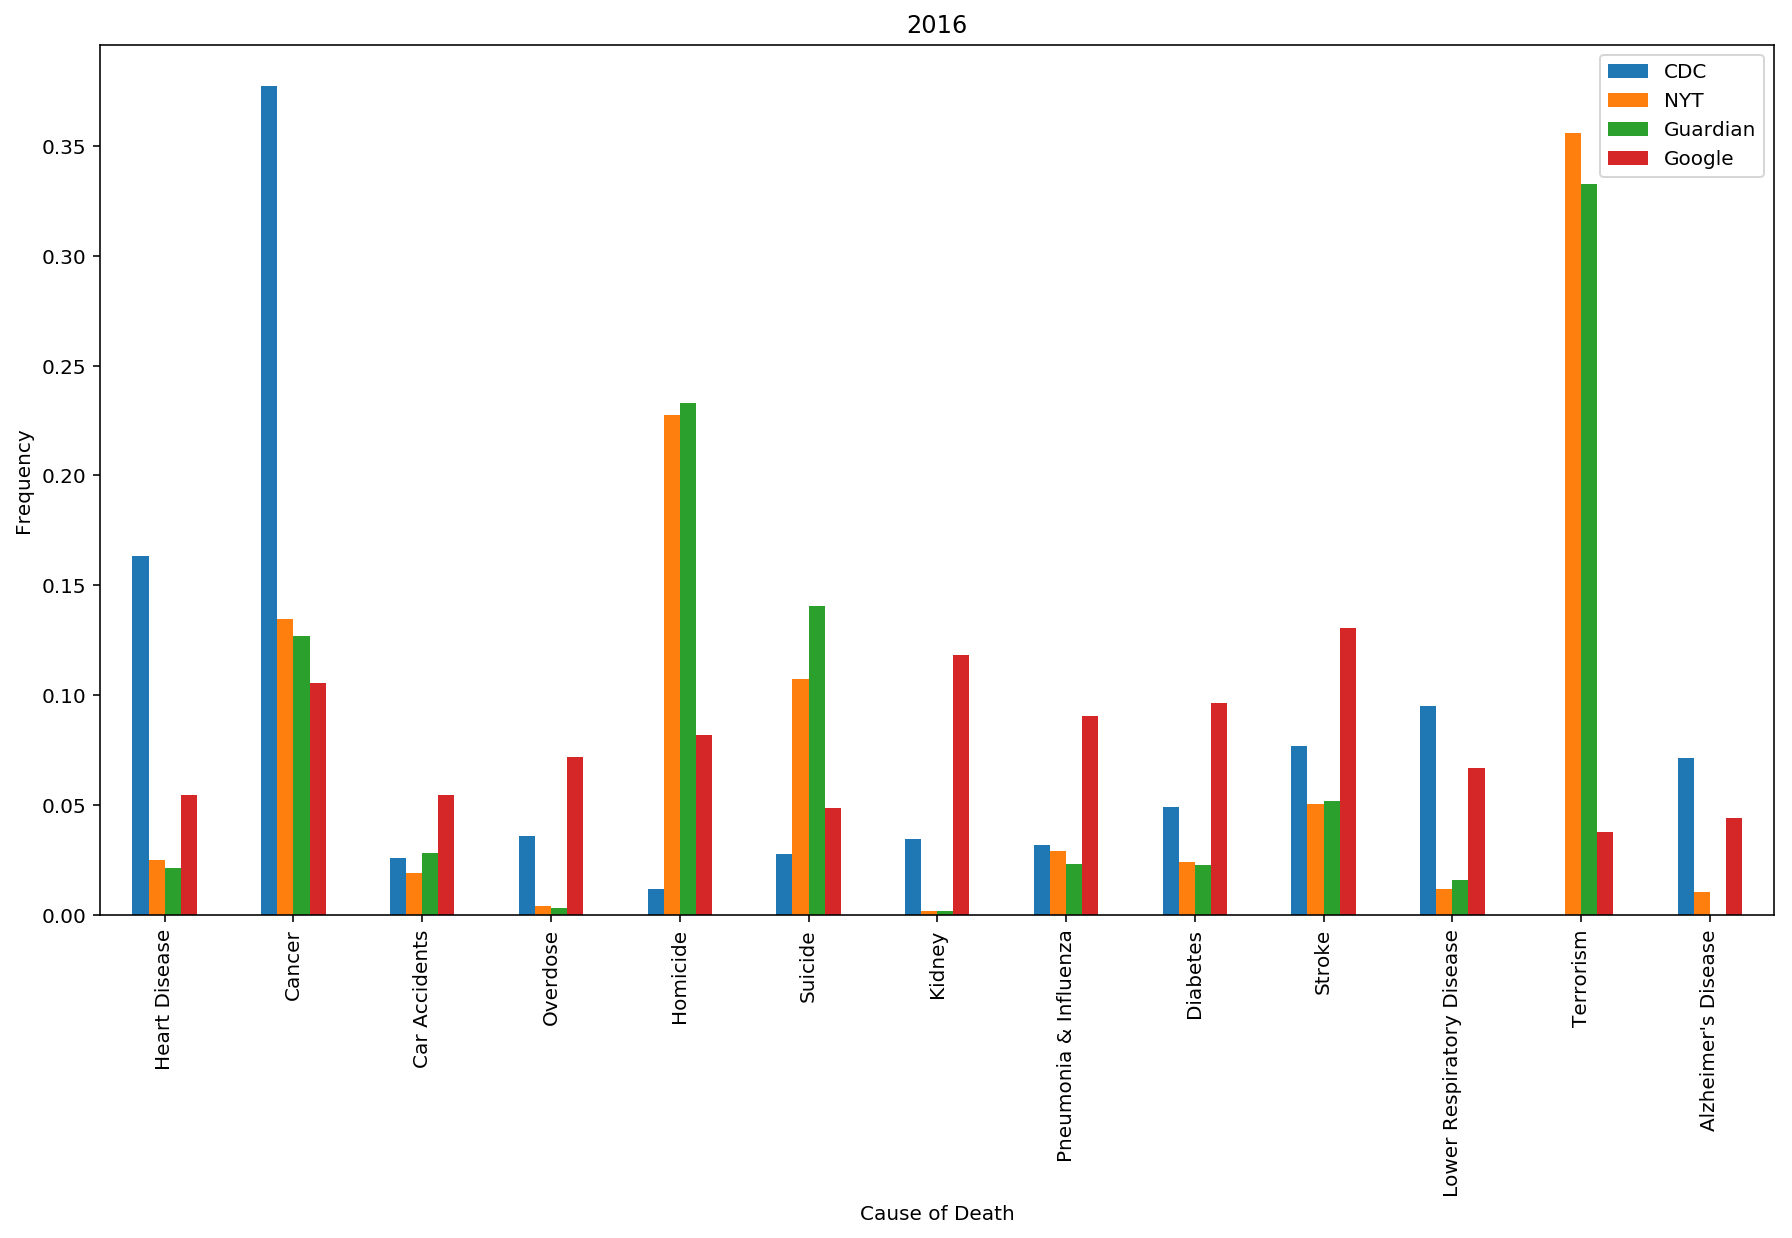

In [51]:
#Plot 2016
ax2016 = df_2016.plot(kind="bar", x="Cause of Death")
ax2016.set_ylabel("Frequency")
ax2016.set_title("2016")

## Chi Squared Test

In [52]:
def changezero(num):
    if (num == 0):
        num = 0.0000000001
    return num

### New York Times

In [53]:
df_1999['Google'] = 0
df_2000['Google'] = 0
df_2001['Google'] = 0
df_2002['Google'] = 0
df_2003['Google'] = 0

In [54]:
#Creating the chistat_df
chistat_df = df_1999 + df_2000 + df_2001 + df_2002 + df_2003 + df_2004 + df_2005 + df_2006 + df_2006 + df_2007 + df_2008 + df_2009 + df_2010 + df_2011 + df_2012 + df_2013 + df_2014 + df_2015 + df_2016
chistat_df['Cause of Death'] = df_1999['Cause of Death']
chistat_df.drop(['Google'], axis=1)

,Cause of Death,CDC,NYT,Guardian
0,Heart Disease,2.81565,0.619941,0.436825
1,Cancer,7.6685,3.574377,2.527341
2,Car Accidents,0.569894,0.413914,0.471184
3,Overdose,0.381485,0.041733,0.027645
4,Homicide,0.2259,3.950038,5.036463
5,Suicide,0.469611,1.869967,2.380084
6,Kidney,0.627074,0.052358,0.023050
7,Pneumonia & Influenza,0.760831,0.779338,0.713968
8,Diabetes,0.960856,0.608147,0.385379
9,Stroke,1.75975,0.997908,1.123152


In [295]:
NYT_Guardian = sp.stats.chisquare(chistat_df['NYT'],chistat_df['Guardian'], ddof=12)[0]
NYT_CDC = sp.stats.chisquare(chistat_df['NYT'],chistat_df['CDC'], ddof=12)[0]
CDC_Guardian = sp.stats.chisquare(chistat_df['Guardian'],chistat_df['CDC'], ddof=12)[0]

In [301]:
print("The Chi Squared Test for Homogeneity between NYT Data and the Guardian data is : " + str(NYT_Guardian))
print("The Chi Squared Test for Homogeneity between NYT Data and the CDC data is : " + str(NYT_CDC))
print("The Chi Squared Test for Homogeneity between Guardian Data and the CDC data is : " + str(CDC_Guardian))

The Chi Squared Test for Homogeneity between NYT Data and the Guardian data is : 1.25646187818
The Chi Squared Test for Homogeneity between NYT Data and the CDC data is : 14385.711770173966
The Chi Squared Test for Homogeneity between Guardian Data and the CDC data is : 14253.46041519278


In [95]:
print("NYT vs. CDC:      Empirical chi squared value: {:.2f}, p: {:.2f}".format(*tuple(sp.stats.chisquare(chistat_df['NYT'], chistat_df['CDC']))))
print("Guardian vs. CDC: Empirical chi squared value: {:.2f}, p: {:.2f}".format(*tuple(sp.stats.chisquare(chistat_df['Guardian'], chistat_df['CDC']))))
print("Google vs. CDC:   Empirical chi squared value: {:.2f}, p: {:.2f}".format(*tuple(sp.stats.chisquare(chistat_df['Google'], chistat_df['CDC']))))

NYT vs. CDC:      Empirical chi squared value: 14385.71, p: 0.00
Guardian vs. CDC: Empirical chi squared value: 14253.46, p: 0.00
Google vs. CDC:   Empirical chi squared value: 203.58, p: 0.00
